In [ ]:
import os
import pickle
from collections import OrderedDict
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn as nn
import cv2
import random
import torchvision.transforms as transforms
from torch.utils import data
from torch.nn import functional as F
from torchvision import models
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import numpy as np
import torch.optim as optim
import torchvision.datasets as td
from torchvision import transforms
from PIL import Image
from skimage.feature import hog as hog
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix,f1_score, accuracy_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder

In [ ]:
from google.colab import drive
import pathlib

drive.mount('/content/drive', force_remount=True)

drive = pathlib.Path('./drive/MyDrive') / 'ML_Project' / 'ML_FP_2022'

Mounted at /content/drive


# Load data

In [ ]:
with open(drive / "data2022" / "multi-task" / "label_v1" / "eval_label.pickle", 'rb') as pickle_file:
  eval_ = pickle.load(pickle_file)
pickle_file.close()

with open(drive / "data2022" / "multi-task" / "label_v1" / "test_label.pickle", 'rb') as pickle_file:
  test_ = pickle.load(pickle_file)
pickle_file.close()

with open(drive / "data2022" / "multi-task" / "label_v1" / "train_label.pickle", 'rb') as pickle_file:
  train_ = pickle.load(pickle_file)
pickle_file.close()

# Define preprocessor and label encoder

In [ ]:
#data augmentation, define image preprocessor
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   
])

labels_c = train_['creator']+test_['creator']+eval_['creator']
encoder_c = LabelEncoder()
encoder_c.fit(labels_c)

labels_m = train_['material']+test_['material']+eval_['material']
encoder_m = MultiLabelBinarizer()
encoder_m.fit(labels_m)

labels_t = train_['type']+test_['type']+eval_['type']
encoder_t = MultiLabelBinarizer()
encoder_t.fit(labels_t)

MultiLabelBinarizer()

In [ ]:
encoder_c.classes_

array(['Callot, Jacques', 'Collaert, Adriaen', 'Fokke, Simon',
       'Galle, Philips', 'Gheyn, Jacob de (II)', 'Goltzius, Hendrick',
       'Hogenberg, Frans', 'Hooghe, Romeyn de', 'Houbraken, Jacob',
       'Luyken, Jan', 'Meissener Porzellan Manufaktur',
       'Passe, Crispijn van de (I)', 'Picart, Bernard',
       'Rembrandt Harmensz. van Rijn', 'Vinkeles, Reinier'], dtype='<U30')

In [ ]:
print(encoder_c.classes_.shape)

(15,)


In [ ]:
encoder_m.classes_

array(['Japans papier', 'dekverf', 'doek', 'ebbenhout', 'eikenhout',
       'fluweel', 'goud', 'hout', 'inkt', 'koper', 'krijt', 'leer',
       'olieverf', 'paneel', 'papier', 'porselein', 'potlood', 'staal',
       'steengoed', 'verf', 'waterverf', 'zilver'], dtype=object)

In [ ]:
print(encoder_m.classes_.shape)

(22,)


In [ ]:
encoder_t.classes_

array(['adreskaart', 'album', 'albumblad', 'almanak', 'beker',
       'bestekfoedraal', 'bierpul', 'boek', 'boekillustratie',
       'bord (vaatwerk)', 'boterspaan', 'brief', 'chocoladekan',
       'chocoladekop', 'dessertbord', 'dienblad', 'eet- en drinkgerei',
       'embleem', 'fragment', 'frontispice', 'handschrift',
       'historieplaat', 'historieprent', 'historisch objectvoorstelling',
       'huwelijksprent', 'kaart', 'kan', 'koffie- en theeservies',
       'koffiekan', 'kom', 'kop', 'kop-en-schotel', 'kostuumprent',
       'lepel', 'lidmaatschapsbewijs', 'loterijprent', 'maculatuur',
       'melkkan', 'modeprent', 'nieuwsprent', 'ontwerp', 'ornamentprent',
       'pamflet', 'pattipan', 'plattegrond', 'portret', 'prent',
       'proefdruk (prent)', 'promotieprent', 'propagandaprent',
       'reisbestek', 'sauskom', 'schaal (objectnaam)', 'schilderij',
       'schotel', 'servies', 'soepbord', 'specerijdoos', 'spoelkom',
       'spotprent', 'suikerbak', 'suikerdoos', 'suikerpot'

In [ ]:
print(encoder_t.classes_.shape)

(76,)


# Dataset

In [ ]:
class train_dataset():
  def __init__(self, dict_ = train_, encoder = [encoder_c, encoder_m, encoder_t]):
    #load data
    self.transform = preprocess
    self.image = dict_['identifier']
    self.creator = encoder[0].transform(dict_['creator'])
    self.material = encoder[1].transform(dict_['material'])
    self.art_type = encoder[2].transform(dict_['type'])
    
  def __len__(self):
    return len(self.image)

  def __getitem__(self, index, img_path=drive / "data2022" / "multi-task" / 'data' / "train set new"):
    # img augmentation
    img = cv2.imread(os.path.join(img_path / self.image[index]))
    img = self.transform(img)
    
    #label
    creator = self.creator[index]
    material = self.material[index]
    art_type = self.art_type[index]

    sample = {'image' : img, 'creator' : creator, 'material' : material, 'type' : art_type}
    return sample

In [ ]:
class test_dataset():
  def __init__(self, dict_ = test_, encoder = [encoder_c, encoder_m, encoder_t]):
    #load data
    self.transform = preprocess
    self.image = dict_['identifier']
    self.creator = encoder[0].transform(dict_['creator'])
    self.material = encoder[1].transform(dict_['material'])
    self.art_type = encoder[2].transform(dict_['type'])
    
  def __len__(self):
    return len(self.image)

  def __getitem__(self, index, img_path=drive / "data2022" / "multi-task" / 'data' / "test set"):
    # img augmentation
    img = cv2.imread(os.path.join(img_path / self.image[index]))
    img = self.transform(img)
    
    #label
    creator = self.creator[index]
    material = self.material[index]
    art_type = self.art_type[index]

    sample = {'image' : img, 'creator' : creator, 'material' : material, 'type' : art_type}
    return sample

In [ ]:
class val_dataset():
  def __init__(self, dict_ = eval_, encoder = [encoder_c, encoder_m, encoder_t]):
    #load data
    self.transform = preprocess
    self.image = dict_['identifier']
    self.creator = encoder[0].transform(dict_['creator'])
    self.material = encoder[1].transform(dict_['material'])
    self.art_type = encoder[2].transform(dict_['type'])
    
  def __len__(self):
    return len(self.image)

  def __getitem__(self, index, img_path=drive / "data2022" / "multi-task" / 'data' / "eval set"):
    # img augmentation
    img = cv2.imread(os.path.join(img_path / self.image[index]))
    img = self.transform(img)
    
    #label
    creator = self.creator[index]
    material = self.material[index]
    art_type = self.art_type[index]

    sample = {'image' : img, 'creator' : creator, 'material' : material, 'type' : art_type}
    return sample

In [ ]:
train = train_dataset()
test = test_dataset()
val = val_dataset()

# Data Loader

In [ ]:
BATCH_SIZE = 16
BATCH_SIZE_VAL = 1

train_dataloader = DataLoader(train, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test, shuffle=False, batch_size=BATCH_SIZE_VAL)
val_dataloader = DataLoader(val, shuffle=False, batch_size=BATCH_SIZE_VAL)

# Train and Evaluate Module

In [ ]:
###main train and evaluate function ###
from tqdm import tqdm
import time

def train_main(model,loss_,optimizer,train_loader,device, epoch):
  loss_epoch=[]
  loss_each=[[],[],[]]
  model.train()
  with tqdm(train_loader, unit="batch") as tepoch:
    for data in tepoch:
      ##(b,c,h,w)
      tepoch.set_description(f"Epoch {epoch}")
      images = torch.Tensor(data['image']).to(device)
      label_c = torch.Tensor(data['creator']).to(device)
      label_m = torch.Tensor(data['material']).to(device)
      label_t = torch.Tensor(data['type']).to(device)
      #print(images.shape)
      optimizer.zero_grad()
      outputs_c, outputs_m, outputs_t = model(images)
      outputs_m=outputs_m.unsqueeze(1).float()
      outputs_t=outputs_t.unsqueeze(1).float()
      label_m=label_m.unsqueeze(1).float()
      label_t=label_t.unsqueeze(1).float()

      loss_c = loss_[0](outputs_c, label_c)
      loss_m = loss_[1](outputs_m, label_m)
      loss_t = loss_[2](outputs_t, label_t)
      print(loss_c.detach().cpu().numpy().ravel(), loss_m.detach().cpu().numpy().ravel() , loss_t.detach().cpu().numpy().ravel())
      loss_each[0].append(loss_c.item())
      loss_each[1].append(loss_m.item())
      loss_each[2].append(loss_t.item())
      # total_loss
      loss= loss_c + 0.08*loss_m + loss_t
      #loss = loss_[1](outputs_m, label_m) + loss_[2](outputs_t, label_t)
      loss_epoch.append(loss.item())
      loss.backward()
      optimizer.step()

      tepoch.set_postfix(loss=loss.item())
      time.sleep(0.0001)

  return loss_epoch,loss_each

def evaluate_whole(model,evaluate_loader):
  predict_clist=[]
  predict_mlist=[]
  predict_tlist=[]
  y_c = []
  y_m = []
  y_t = []
  model.eval()
  with torch.no_grad():
    for batchind,data in enumerate(evaluate_loader):
      images = torch.Tensor(data['image']).to(device)
      label_c = torch.Tensor(data['creator']).to(device)
      label_m = torch.Tensor(data['material']).to(device)
      label_t = torch.Tensor(data['type']).to(device)
      
      outputs_c, outputs_m, outputs_t = model(images)
      softmax = nn.Softmax()
      outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
      outputs_m=outputs_m.float()
      outputs_t=outputs_t.float()
      label_c=label_c
      label_m=label_m.float()
      label_t=label_t.float()
      ##change to (1,c,h,w)

      # predict creator
      predict_clist.append(outputs_c.detach().cpu().numpy().ravel())
      y_c.append(torch.Tensor.round(label_c).detach().cpu().numpy().ravel())
      # predict material
      predict_mlist.append(torch.Tensor.round(outputs_m).detach().cpu().numpy().ravel())
      y_m.append(torch.Tensor.round(label_m).detach().cpu().numpy().ravel())
      # predict type
      predict_tlist.append(torch.Tensor.round(outputs_t).detach().cpu().numpy().ravel())
      y_t.append(torch.Tensor.round(label_t).detach().cpu().numpy().ravel())
  print(y_m[0].shape)
  print(predict_mlist[0].shape)
  print(y_t[0].shape)
  print(predict_tlist[0].shape) 

  #Artist aacc
  aacc = 0
  for index in range(len(predict_clist)):
    aacc = aacc + accuracy_score(y_c[index], predict_clist[index])
  aacc = aacc / len(predict_clist)

  #material mmAP
  mmAp = 0
  for index in range(len(predict_mlist)):
    mmAp = mmAp + average_precision_score(y_m[index], predict_mlist[index])
  mmAp = mmAp / len(predict_mlist)

  #type tmAP
  tmAp = 0
  for index in range(len(predict_tlist)):
    tmAp = tmAp + average_precision_score(y_t[index], predict_tlist[index])
  tmAp = tmAp / len(predict_tlist)
  
  return [predict_clist, predict_mlist, predict_tlist], [y_c, y_m, y_t], [aacc, mmAp, tmAp]

import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,balanced_accuracy_score

def eval_all(predict_list, truth_label):
  #creator
  acc=0
  for index in range(len(predict_list[0])):
    acc = acc + accuracy_score(truth_label[0][index], predict_list[0][index])
  acc = acc / len(predict_list[0])
  f1_c=f1_score(truth_label[0],predict_list[0],average='micro')
  recal_c = recall_score(truth_label[0],predict_list[0],average='micro')
  prec_c = precision_score(truth_label[0],predict_list[0],average='micro')
  mac_c = balanced_accuracy_score(truth_label[0],predict_list[0])
  con_mat_c=confusion_matrix(truth_label[0],predict_list[0])

  #material
  mmAp = 0
  for index in range(len(predict_list[1])):
    mmAp = mmAp + average_precision_score(truth_label[1][index], predict_list[1][index], average='weighted')
  mmAp = mmAp / len(predict_list[1])

  mmRecall = 0
  for index in range(len(predict_list[1])):
    mmRecall = mmRecall + recall_score(truth_label[1][index], predict_list[1][index], average='weighted')
  mmRecall = mmRecall/len(predict_list[1])

  mf1 = 2*(mmAp*mmRecall)/(mmAp+mmRecall)

  #type
  tmAp = 0
  for index in range(len(predict_list[2])):
    tmAp = tmAp + average_precision_score(truth_label[2][index], predict_list[2][index], average='weighted')
  tmAp = tmAp / len(predict_list[2])

  tmRecall = 0
  for index in range(len(predict_list[2])):
    tmRecall = tmRecall + recall_score(truth_label[2][index], predict_list[2][index], average='weighted')
  tmRecall = tmRecall/len(predict_list[2])

  tf1 = 2*(tmAp*tmRecall)/(tmAp+tmRecall)

  return [f1_c,recal_c,prec_c,prec_c,mac_c,con_mat_c,acc], [mmAp,mmRecall,mf1], [tmAp,tmRecall,tf1]

# ResNet 50

In [ ]:
##load pretrained resnet50 network ###
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

class HydraNet(nn.Module):
  def __init__(self, resnet50):
    super().__init__()
    self.net  = resnet50
    self.n_features = self.net.fc.out_features

    # head 1, creator
    self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),
                                              ('relu1', nn.ReLU()),
                                              ('output', nn.Linear(self.n_features, 15))]))
    
    # head 2, material
    self.net.fc2 = nn.Sequential(OrderedDict([('linear1', nn.Linear(self.n_features,self.n_features)),
                                              ('relu1', nn.ReLU()),
                                              ('linear2', nn.Linear(self.n_features, 22)),
                                              ('output', nn.Sigmoid())]))
    # head 3, type
    self.net.fc3 = nn.Sequential(OrderedDict([('linear1', nn.Linear(self.n_features,self.n_features)),
                                          ('relu1', nn.ReLU()),
                                          ('linear2', nn.Linear(self.n_features, 76)),
                                          ('output', nn.Sigmoid())]))
  def forward(self, x):
    output_resnet = self.net(x)
    c_head = self.net.fc1(output_resnet)
    m_head = self.net.fc2(output_resnet)
    t_head = self.net.fc3(output_resnet)
    return c_head, m_head, t_head

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
num_epoch=1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=HydraNet(resnet50).to(device)
loss_c = nn.CrossEntropyLoss()
loss_m = nn.BCELoss()
loss_t = nn.BCELoss()
loss_ = [loss_c, loss_m, loss_t]
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=(1e-5))
# optimizer: changed to use SGD

In [ ]:
# show loss
train_loss, train_loss_each = train_main(model,loss_,optimizer,train_dataloader, device, num_epoch)
predict_r, label, metric =evaluate_whole(model, evaluate_loader=val_dataloader)
print(metric)
print(f'epoch{i+1} has been trained')

Epoch 1:   0%|          | 1/668 [00:00<04:09,  2.67batch/s, loss=3.67]

[2.8418546] [0.79507047] [0.7642524]


Epoch 1:   0%|          | 2/668 [00:00<03:51,  2.88batch/s, loss=3.83]

[2.9883804] [0.81315684] [0.77916366]


Epoch 1:   0%|          | 3/668 [00:01<03:45,  2.94batch/s, loss=3.27]

[2.435481] [0.78439474] [0.76803607]


Epoch 1:   1%|          | 4/668 [00:01<03:39,  3.02batch/s, loss=3.54]

[2.7240326] [0.7599073] [0.7554044]


Epoch 1:   1%|          | 5/668 [00:01<03:37,  3.05batch/s, loss=3.61]

[2.7912216] [0.75511914] [0.7603138]


Epoch 1:   1%|          | 6/668 [00:02<03:37,  3.04batch/s, loss=3.39]

[2.58502] [0.75250405] [0.74597913]


Epoch 1:   1%|          | 7/668 [00:02<03:36,  3.05batch/s, loss=3.33]

[2.53128] [0.73627144] [0.7377612]


Epoch 1:   1%|          | 8/668 [00:02<03:35,  3.07batch/s, loss=3.08]

[2.2899356] [0.72510433] [0.73371744]


Epoch 1:   1%|▏         | 9/668 [00:02<03:35,  3.06batch/s, loss=3.01]

[2.2515955] [0.694668] [0.70607746]


Epoch 1:   1%|▏         | 10/668 [00:03<03:34,  3.06batch/s, loss=3]

[2.232683] [0.6935361] [0.71030563]


Epoch 1:   2%|▏         | 11/668 [00:03<03:32,  3.10batch/s, loss=2.83]

[2.0776265] [0.6777599] [0.6949928]


Epoch 1:   2%|▏         | 12/668 [00:03<03:34,  3.05batch/s, loss=3.15]

[2.4140513] [0.66589826] [0.68255407]


Epoch 1:   2%|▏         | 13/668 [00:04<03:36,  3.02batch/s, loss=2.72]

[1.9908601] [0.6529426] [0.6755201]


Epoch 1:   2%|▏         | 14/668 [00:04<03:33,  3.06batch/s, loss=2.47]

[1.7450395] [0.6377848] [0.6733299]


Epoch 1:   2%|▏         | 15/668 [00:04<03:32,  3.07batch/s, loss=2.53]

[1.8196036] [0.6288755] [0.6564085]


Epoch 1:   2%|▏         | 16/668 [00:05<03:35,  3.03batch/s, loss=2.86]

[2.1573787] [0.61261463] [0.6536289]


Epoch 1:   3%|▎         | 17/668 [00:05<03:34,  3.04batch/s, loss=2.6]

[1.9067081] [0.6006315] [0.64664805]


Epoch 1:   3%|▎         | 18/668 [00:05<03:32,  3.05batch/s, loss=2.75]

[2.0718262] [0.59293854] [0.635248]


Epoch 1:   3%|▎         | 19/668 [00:06<03:31,  3.08batch/s, loss=2.25]

[1.5837829] [0.5776561] [0.6200023]


Epoch 1:   3%|▎         | 20/668 [00:06<03:30,  3.09batch/s, loss=2.39]

[1.725204] [0.5714031] [0.6206761]


Epoch 1:   3%|▎         | 21/668 [00:06<03:28,  3.10batch/s, loss=2.19]

[1.5359633] [0.55825216] [0.6133701]


Epoch 1:   3%|▎         | 22/668 [00:07<03:28,  3.10batch/s, loss=2.17]

[1.5220238] [0.54496384] [0.6025336]


Epoch 1:   3%|▎         | 23/668 [00:07<03:28,  3.09batch/s, loss=2.2]

[1.5649084] [0.534594] [0.59459144]


Epoch 1:   4%|▎         | 24/668 [00:07<03:29,  3.08batch/s, loss=2.32]

[1.688155] [0.53122705] [0.5854608]


Epoch 1:   4%|▎         | 25/668 [00:08<03:28,  3.08batch/s, loss=2.17]

[1.5529438] [0.5111642] [0.5748216]


Epoch 1:   4%|▍         | 26/668 [00:08<03:27,  3.09batch/s, loss=2.11]

[1.4972845] [0.51558286] [0.57543004]


Epoch 1:   4%|▍         | 27/668 [00:08<03:46,  2.83batch/s, loss=2.14]

[1.5204601] [0.5119875] [0.57369685]


Epoch 1:   4%|▍         | 28/668 [00:09<04:04,  2.62batch/s, loss=1.92]

[1.3244915] [0.47758168] [0.5558374]


Epoch 1:   4%|▍         | 29/668 [00:09<04:13,  2.52batch/s, loss=2.07]

[1.4668751] [0.4719919] [0.5645757]


Epoch 1:   4%|▍         | 30/668 [00:10<04:14,  2.51batch/s, loss=1.98]

[1.3890514] [0.48150492] [0.5488711]


Epoch 1:   5%|▍         | 31/668 [00:10<04:23,  2.42batch/s, loss=1.88]

[1.3058689] [0.47660923] [0.53875613]


Epoch 1:   5%|▍         | 32/668 [00:11<05:01,  2.11batch/s, loss=2.04]

[1.4773003] [0.45350423] [0.5250452]


Epoch 1:   5%|▍         | 33/668 [00:11<04:48,  2.20batch/s, loss=1.62]

[1.066412] [0.44060114] [0.51942486]


Epoch 1:   5%|▌         | 34/668 [00:12<04:29,  2.35batch/s, loss=1.71]

[1.1564492] [0.42900285] [0.51465696]


Epoch 1:   5%|▌         | 35/668 [00:12<04:10,  2.53batch/s, loss=1.74]

[1.1927505] [0.42504892] [0.51322794]


Epoch 1:   5%|▌         | 36/668 [00:12<03:55,  2.68batch/s, loss=1.59]

[1.0476216] [0.41969198] [0.50460553]


Epoch 1:   6%|▌         | 37/668 [00:13<03:46,  2.78batch/s, loss=1.39]

[0.8617432] [0.4071592] [0.4938475]


Epoch 1:   6%|▌         | 38/668 [00:13<03:40,  2.85batch/s, loss=1.73]

[1.202359] [0.41081378] [0.49254453]


Epoch 1:   6%|▌         | 39/668 [00:13<03:36,  2.91batch/s, loss=1.69]

[1.1788095] [0.40744853] [0.48323086]


Epoch 1:   6%|▌         | 40/668 [00:14<03:35,  2.92batch/s, loss=1.66]

[1.1544266] [0.38315892] [0.4715271]


Epoch 1:   6%|▌         | 41/668 [00:14<03:32,  2.95batch/s, loss=1.52]

[1.0243969] [0.3706483] [0.4657636]


Epoch 1:   6%|▋         | 42/668 [00:14<03:34,  2.92batch/s, loss=1.59]

[1.0955958] [0.36189976] [0.46568134]


Epoch 1:   6%|▋         | 43/668 [00:15<03:58,  2.62batch/s, loss=1.16]

[0.6899845] [0.35224417] [0.4425185]


Epoch 1:   7%|▋         | 44/668 [00:15<04:49,  2.16batch/s, loss=1.26]

[0.7848905] [0.36634207] [0.44997466]


Epoch 1:   7%|▋         | 45/668 [00:16<05:20,  1.94batch/s, loss=1.26]

[0.79371136] [0.34697735] [0.4408474]


Epoch 1:   7%|▋         | 46/668 [00:16<05:01,  2.06batch/s, loss=1.46]

[0.9836073] [0.35242185] [0.44335446]


Epoch 1:   7%|▋         | 47/668 [00:17<04:51,  2.13batch/s, loss=1.19]

[0.7391824] [0.33483544] [0.42284423]


Epoch 1:   7%|▋         | 48/668 [00:17<04:29,  2.30batch/s, loss=1.26]

[0.80371463] [0.33009735] [0.42622396]


Epoch 1:   7%|▋         | 49/668 [00:18<04:11,  2.46batch/s, loss=1.41]

[0.9466764] [0.34402782] [0.4319246]


Epoch 1:   7%|▋         | 50/668 [00:18<03:58,  2.59batch/s, loss=1.02]

[0.5871767] [0.3130706] [0.40614906]


Epoch 1:   8%|▊         | 51/668 [00:18<03:46,  2.72batch/s, loss=1.13]

[0.70397544] [0.31244126] [0.39953864]


Epoch 1:   8%|▊         | 52/668 [00:18<03:39,  2.81batch/s, loss=0.991]

[0.5629543] [0.31372696] [0.40302876]


Epoch 1:   8%|▊         | 53/668 [00:19<03:36,  2.85batch/s, loss=1.13]

[0.7098015] [0.30548587] [0.3957314]


Epoch 1:   8%|▊         | 54/668 [00:19<03:54,  2.62batch/s, loss=1.04]

[0.62634474] [0.30065915] [0.38900667]


Epoch 1:   8%|▊         | 55/668 [00:20<03:50,  2.66batch/s, loss=1.01]

[0.59865767] [0.30042568] [0.3862534]


Epoch 1:   8%|▊         | 56/668 [00:20<04:12,  2.42batch/s, loss=1.23]

[0.82392913] [0.2952653] [0.38737828]


Epoch 1:   9%|▊         | 57/668 [00:21<04:09,  2.45batch/s, loss=0.887]

[0.49076846] [0.2801732] [0.3742576]


Epoch 1:   9%|▊         | 58/668 [00:21<03:56,  2.58batch/s, loss=0.853]

[0.4668509] [0.26727578] [0.36499202]


Epoch 1:   9%|▉         | 59/668 [00:21<04:24,  2.30batch/s, loss=1.18]

[0.7765833] [0.28320292] [0.3778057]


Epoch 1:   9%|▉         | 60/668 [00:22<04:04,  2.48batch/s, loss=1.12]

[0.7316708] [0.27363658] [0.36563498]


Epoch 1:   9%|▉         | 61/668 [00:22<03:50,  2.63batch/s, loss=0.855]

[0.484995] [0.25102684] [0.35020965]


Epoch 1:   9%|▉         | 62/668 [00:22<03:41,  2.74batch/s, loss=0.85]

[0.48297495] [0.25137672] [0.34648132]


Epoch 1:   9%|▉         | 63/668 [00:23<03:32,  2.85batch/s, loss=1.21]

[0.8321089] [0.25854582] [0.35346645]


Epoch 1:  10%|▉         | 64/668 [00:23<03:26,  2.92batch/s, loss=0.819]

[0.46676445] [0.2415345] [0.33279058]


Epoch 1:  10%|▉         | 65/668 [00:23<03:23,  2.96batch/s, loss=0.866]

[0.5112988] [0.25271216] [0.33470955]


Epoch 1:  10%|▉         | 66/668 [00:24<03:20,  3.00batch/s, loss=1.02]

[0.6798016] [0.23647714] [0.3234936]


Epoch 1:  10%|█         | 67/668 [00:24<03:18,  3.02batch/s, loss=0.887]

[0.5412392] [0.22977851] [0.327173]


Epoch 1:  10%|█         | 68/668 [00:24<03:17,  3.04batch/s, loss=0.71]

[0.366755] [0.2265612] [0.3253394]


Epoch 1:  10%|█         | 69/668 [00:25<03:16,  3.05batch/s, loss=0.798]

[0.45779848] [0.22805738] [0.32171834]


Epoch 1:  10%|█         | 70/668 [00:25<03:17,  3.02batch/s, loss=0.798]

[0.46111283] [0.21776569] [0.31907898]


Epoch 1:  11%|█         | 71/668 [00:25<03:16,  3.04batch/s, loss=0.717]

[0.38104463] [0.21902375] [0.31856182]


Epoch 1:  11%|█         | 72/668 [00:26<03:14,  3.07batch/s, loss=0.626]

[0.3104673] [0.20936863] [0.29916215]


Epoch 1:  11%|█         | 73/668 [00:26<03:15,  3.05batch/s, loss=0.694]

[0.3798592] [0.21515553] [0.29727203]


Epoch 1:  11%|█         | 74/668 [00:26<03:14,  3.05batch/s, loss=0.668]

[0.34817928] [0.20412597] [0.3036999]


Epoch 1:  11%|█         | 75/668 [00:27<03:13,  3.06batch/s, loss=0.724]

[0.42535186] [0.19492197] [0.283032]


Epoch 1:  11%|█▏        | 76/668 [00:27<03:13,  3.05batch/s, loss=0.715]

[0.4093476] [0.2024645] [0.28896794]


Epoch 1:  12%|█▏        | 77/668 [00:27<03:19,  2.96batch/s, loss=0.598]

[0.29583135] [0.199107] [0.2863721]


Epoch 1:  12%|█▏        | 78/668 [00:28<03:18,  2.97batch/s, loss=0.878]

[0.57345974] [0.2063424] [0.28786284]


Epoch 1:  12%|█▏        | 79/668 [00:28<03:17,  2.98batch/s, loss=0.555]

[0.26830927] [0.18281603] [0.27181712]


Epoch 1:  12%|█▏        | 80/668 [00:28<03:15,  3.01batch/s, loss=0.542]

[0.2666152] [0.17728376] [0.26161394]


Epoch 1:  12%|█▏        | 81/668 [00:29<03:15,  3.00batch/s, loss=1.13]

[0.82960075] [0.20463337] [0.28109837]


Epoch 1:  12%|█▏        | 82/668 [00:29<03:14,  3.02batch/s, loss=0.748]

[0.46051854] [0.19453801] [0.27200612]


Epoch 1:  12%|█▏        | 83/668 [00:29<03:13,  3.02batch/s, loss=1.07]

[0.7819928] [0.19872664] [0.2739082]


Epoch 1:  13%|█▎        | 84/668 [00:30<03:12,  3.03batch/s, loss=0.521]

[0.2565921] [0.169292] [0.2504356]


Epoch 1:  13%|█▎        | 85/668 [00:30<03:10,  3.06batch/s, loss=0.719]

[0.4473535] [0.1820807] [0.2572476]


Epoch 1:  13%|█▎        | 86/668 [00:30<03:09,  3.07batch/s, loss=0.741]

[0.46123576] [0.18236816] [0.26556125]


Epoch 1:  13%|█▎        | 87/668 [00:31<03:09,  3.06batch/s, loss=0.539]

[0.2920169] [0.15734093] [0.23404877]


Epoch 1:  13%|█▎        | 88/668 [00:31<03:09,  3.07batch/s, loss=0.722]

[0.45191285] [0.17877267] [0.25572154]


Epoch 1:  13%|█▎        | 89/668 [00:31<03:08,  3.07batch/s, loss=0.632]

[0.3785276] [0.15927567] [0.24047992]


Epoch 1:  13%|█▎        | 90/668 [00:32<03:09,  3.05batch/s, loss=0.501]

[0.26269504] [0.15761986] [0.22560792]


Epoch 1:  14%|█▎        | 91/668 [00:32<03:09,  3.04batch/s, loss=0.516]

[0.27642605] [0.15177861] [0.2278121]


Epoch 1:  14%|█▍        | 92/668 [00:32<03:10,  3.02batch/s, loss=0.668]

[0.4335913] [0.15075353] [0.22273646]


Epoch 1:  14%|█▍        | 93/668 [00:33<03:09,  3.04batch/s, loss=0.391]

[0.1701158] [0.14118637] [0.20998012]


Epoch 1:  14%|█▍        | 94/668 [00:33<03:08,  3.05batch/s, loss=0.82]

[0.57124233] [0.15647687] [0.23601884]


Epoch 1:  14%|█▍        | 95/668 [00:33<03:07,  3.05batch/s, loss=0.702]

[0.47153613] [0.15061039] [0.21808018]


Epoch 1:  14%|█▍        | 96/668 [00:34<03:08,  3.04batch/s, loss=0.757]

[0.5221547] [0.15547378] [0.22210714]


Epoch 1:  15%|█▍        | 97/668 [00:34<03:07,  3.05batch/s, loss=0.505]

[0.27753773] [0.14471875] [0.21556051]


Epoch 1:  15%|█▍        | 98/668 [00:34<03:07,  3.05batch/s, loss=0.486]

[0.26912704] [0.139238] [0.20611858]


Epoch 1:  15%|█▍        | 99/668 [00:35<03:01,  3.13batch/s, loss=0.607]

[0.38787505] [0.14269957] [0.20794468]


Epoch 1:  15%|█▍        | 100/668 [00:35<03:02,  3.11batch/s, loss=0.71]

[0.50376415] [0.12878242] [0.19623102]


Epoch 1:  15%|█▌        | 101/668 [00:35<03:05,  3.05batch/s, loss=0.569]

[0.35625422] [0.13523504] [0.20232522]


Epoch 1:  15%|█▌        | 102/668 [00:36<03:03,  3.08batch/s, loss=0.549]

[0.34232333] [0.13086165] [0.19590943]


Epoch 1:  15%|█▌        | 103/668 [00:36<03:03,  3.09batch/s, loss=0.723]

[0.5199782] [0.12622504] [0.19247487]


Epoch 1:  16%|█▌        | 104/668 [00:36<03:05,  3.05batch/s, loss=0.518]

[0.3192632] [0.12453606] [0.1891413]


Epoch 1:  16%|█▌        | 105/668 [00:37<03:05,  3.04batch/s, loss=0.326]

[0.13446517] [0.11568022] [0.18219848]


Epoch 1:  16%|█▌        | 106/668 [00:37<03:03,  3.06batch/s, loss=0.629]

[0.42519844] [0.12714228] [0.19354762]


Epoch 1:  16%|█▌        | 107/668 [00:37<03:06,  3.01batch/s, loss=0.392]

[0.19502595] [0.12188878] [0.18676639]


Epoch 1:  16%|█▌        | 108/668 [00:38<03:04,  3.04batch/s, loss=0.506]

[0.30905405] [0.12489949] [0.18667643]


Epoch 1:  16%|█▋        | 109/668 [00:38<03:03,  3.05batch/s, loss=0.496]

[0.31602743] [0.11641262] [0.17082855]


Epoch 1:  16%|█▋        | 110/668 [00:38<03:01,  3.07batch/s, loss=0.583]

[0.39801344] [0.11336741] [0.17554125]


Epoch 1:  17%|█▋        | 111/668 [00:38<03:04,  3.02batch/s, loss=0.355]

[0.17252927] [0.1125411] [0.17328967]


Epoch 1:  17%|█▋        | 112/668 [00:39<03:03,  3.03batch/s, loss=0.414]

[0.24139696] [0.10856704] [0.16404328]


Epoch 1:  17%|█▋        | 113/668 [00:39<03:02,  3.04batch/s, loss=0.352]

[0.18013921] [0.10563183] [0.1636422]


Epoch 1:  17%|█▋        | 114/668 [00:39<03:05,  2.99batch/s, loss=0.39]

[0.2149249] [0.106043] [0.16626206]


Epoch 1:  17%|█▋        | 115/668 [00:40<03:02,  3.03batch/s, loss=0.353]

[0.17042522] [0.1128518] [0.17393337]


Epoch 1:  17%|█▋        | 116/668 [00:40<03:03,  3.01batch/s, loss=0.263]

[0.10572267] [0.09485234] [0.15005456]


Epoch 1:  18%|█▊        | 117/668 [00:40<03:02,  3.02batch/s, loss=0.53]

[0.35302988] [0.11875471] [0.16754487]


Epoch 1:  18%|█▊        | 118/668 [00:41<03:01,  3.03batch/s, loss=0.521]

[0.3531555] [0.11897045] [0.15793496]


Epoch 1:  18%|█▊        | 119/668 [00:41<03:03,  2.99batch/s, loss=0.632]

[0.44809178] [0.12124421] [0.17448695]


Epoch 1:  18%|█▊        | 120/668 [00:41<03:02,  3.00batch/s, loss=0.321]

[0.16317973] [0.09412684] [0.15032922]


Epoch 1:  18%|█▊        | 121/668 [00:42<03:00,  3.02batch/s, loss=0.637]

[0.4571786] [0.10958662] [0.17077632]


Epoch 1:  18%|█▊        | 122/668 [00:42<03:01,  3.00batch/s, loss=0.379]

[0.22360082] [0.09512543] [0.14735341]


Epoch 1:  18%|█▊        | 123/668 [00:42<03:00,  3.01batch/s, loss=0.462]

[0.29395676] [0.09824237] [0.16008268]


Epoch 1:  19%|█▊        | 124/668 [00:43<03:01,  3.00batch/s, loss=0.56]

[0.39916825] [0.09623352] [0.15333895]


Epoch 1:  19%|█▊        | 125/668 [00:43<03:00,  3.00batch/s, loss=0.261]

[0.1114743] [0.09147105] [0.14213955]


Epoch 1:  19%|█▉        | 126/668 [00:43<03:00,  3.00batch/s, loss=0.316]

[0.1763863] [0.08462586] [0.13298446]


Epoch 1:  19%|█▉        | 127/668 [00:44<03:00,  3.00batch/s, loss=0.422]

[0.28895983] [0.07794712] [0.12724487]


Epoch 1:  19%|█▉        | 128/668 [00:44<02:59,  3.01batch/s, loss=0.467]

[0.32358992] [0.09635997] [0.13582504]


Epoch 1:  19%|█▉        | 129/668 [00:44<02:59,  3.00batch/s, loss=0.242]

[0.10123391] [0.0874948] [0.13399458]


Epoch 1:  19%|█▉        | 130/668 [00:45<02:57,  3.03batch/s, loss=0.396]

[0.25874847] [0.08068611] [0.13052797]


Epoch 1:  20%|█▉        | 131/668 [00:45<02:57,  3.02batch/s, loss=0.324]

[0.19911908] [0.07637449] [0.11877944]


Epoch 1:  20%|█▉        | 132/668 [00:45<02:56,  3.03batch/s, loss=0.663]

[0.5274608] [0.0845685] [0.12917197]


Epoch 1:  20%|█▉        | 133/668 [00:46<02:55,  3.05batch/s, loss=0.547]

[0.41430673] [0.0829502] [0.12580515]


Epoch 1:  20%|██        | 134/668 [00:46<02:54,  3.06batch/s, loss=0.236]

[0.11214224] [0.07325377] [0.11751206]


Epoch 1:  20%|██        | 135/668 [00:46<02:57,  3.00batch/s, loss=0.461]

[0.33309096] [0.07774641] [0.12201549]


Epoch 1:  20%|██        | 136/668 [00:47<02:57,  3.00batch/s, loss=0.335]

[0.20810936] [0.0818872] [0.12067921]


Epoch 1:  21%|██        | 137/668 [00:47<02:59,  2.97batch/s, loss=0.576]

[0.4374183] [0.08436046] [0.13216227]


Epoch 1:  21%|██        | 138/668 [00:48<03:03,  2.89batch/s, loss=0.45]

[0.32593757] [0.07798859] [0.11781663]


Epoch 1:  21%|██        | 139/668 [00:48<03:02,  2.90batch/s, loss=0.389]

[0.24093428] [0.09068535] [0.14102483]


Epoch 1:  21%|██        | 140/668 [00:48<03:00,  2.93batch/s, loss=0.405]

[0.27342236] [0.07144482] [0.12564133]


Epoch 1:  21%|██        | 141/668 [00:49<02:59,  2.93batch/s, loss=0.582]

[0.44291395] [0.08185538] [0.13211778]


Epoch 1:  21%|██▏       | 142/668 [00:49<02:57,  2.96batch/s, loss=0.411]

[0.292684] [0.07719156] [0.11262377]


Epoch 1:  21%|██▏       | 143/668 [00:49<02:57,  2.96batch/s, loss=0.347]

[0.22170983] [0.07727308] [0.11917151]


Epoch 1:  22%|██▏       | 144/668 [00:50<02:56,  2.97batch/s, loss=0.28]

[0.1707312] [0.0630203] [0.10390394]


Epoch 1:  22%|██▏       | 145/668 [00:50<02:55,  2.99batch/s, loss=0.281]

[0.16085793] [0.07703814] [0.11404151]


Epoch 1:  22%|██▏       | 146/668 [00:50<02:54,  2.99batch/s, loss=0.597]

[0.47760934] [0.07763929] [0.11272119]


Epoch 1:  22%|██▏       | 147/668 [00:51<02:54,  2.99batch/s, loss=0.197]

[0.09236454] [0.07049735] [0.09876937]


Epoch 1:  22%|██▏       | 148/668 [00:51<02:52,  3.01batch/s, loss=0.362]

[0.25400499] [0.06692735] [0.10254467]


Epoch 1:  22%|██▏       | 149/668 [00:51<02:49,  3.06batch/s, loss=0.242]

[0.13665384] [0.05901108] [0.10058782]


Epoch 1:  22%|██▏       | 150/668 [00:52<02:53,  2.98batch/s, loss=0.28]

[0.16443367] [0.07309828] [0.10998728]


Epoch 1:  23%|██▎       | 151/668 [00:52<02:53,  2.99batch/s, loss=0.23]

[0.12355582] [0.06961281] [0.10100194]


Epoch 1:  23%|██▎       | 152/668 [00:52<02:52,  2.98batch/s, loss=0.75]

[0.6296005] [0.08326159] [0.11328612]


Epoch 1:  23%|██▎       | 153/668 [00:53<02:51,  3.00batch/s, loss=0.194]

[0.08886417] [0.06389496] [0.09974396]


Epoch 1:  23%|██▎       | 154/668 [00:53<02:50,  3.02batch/s, loss=0.451]

[0.35193297] [0.05666715] [0.09490437]


Epoch 1:  23%|██▎       | 155/668 [00:53<02:49,  3.03batch/s, loss=0.378]

[0.2646818] [0.06264274] [0.10872511]


Epoch 1:  23%|██▎       | 156/668 [00:54<02:51,  2.99batch/s, loss=0.219]

[0.11526318] [0.06441949] [0.09832163]


Epoch 1:  24%|██▎       | 157/668 [00:54<02:50,  2.99batch/s, loss=0.311]

[0.20947401] [0.0657991] [0.09621675]


Epoch 1:  24%|██▎       | 158/668 [00:54<02:50,  2.99batch/s, loss=0.363]

[0.25591093] [0.06480443] [0.1020119]


Epoch 1:  24%|██▍       | 159/668 [00:55<02:52,  2.96batch/s, loss=0.357]

[0.25674018] [0.05822605] [0.09562171]


Epoch 1:  24%|██▍       | 160/668 [00:55<02:52,  2.95batch/s, loss=0.356]

[0.25857452] [0.06203428] [0.09283549]


Epoch 1:  24%|██▍       | 161/668 [00:55<02:50,  2.97batch/s, loss=0.267]

[0.15060313] [0.06107038] [0.11171007]


Epoch 1:  24%|██▍       | 162/668 [00:56<02:50,  2.97batch/s, loss=0.44]

[0.33843026] [0.05708028] [0.09664904]


Epoch 1:  24%|██▍       | 163/668 [00:56<02:47,  3.01batch/s, loss=0.188]

[0.09902894] [0.05278837] [0.0844121]


Epoch 1:  25%|██▍       | 164/668 [00:56<02:46,  3.02batch/s, loss=0.306]

[0.21678185] [0.05921772] [0.08445595]


Epoch 1:  25%|██▍       | 165/668 [00:57<02:45,  3.03batch/s, loss=0.266]

[0.16292399] [0.06483474] [0.09742376]


Epoch 1:  25%|██▍       | 166/668 [00:57<02:45,  3.04batch/s, loss=0.264]

[0.1590672] [0.05301118] [0.10074764]


Epoch 1:  25%|██▌       | 167/668 [00:57<02:45,  3.02batch/s, loss=0.187]

[0.10133832] [0.0521099] [0.0816777]


Epoch 1:  25%|██▌       | 168/668 [00:58<02:46,  3.01batch/s, loss=0.244]

[0.15332499] [0.05613976] [0.08662111]


Epoch 1:  25%|██▌       | 169/668 [00:58<02:45,  3.02batch/s, loss=0.361]

[0.2804774] [0.05052949] [0.07675789]


Epoch 1:  25%|██▌       | 170/668 [00:58<02:45,  3.01batch/s, loss=0.191]

[0.1110168] [0.04805843] [0.07589978]


Epoch 1:  26%|██▌       | 171/668 [00:59<02:45,  3.00batch/s, loss=0.24]

[0.15124239] [0.05391019] [0.08413889]


Epoch 1:  26%|██▌       | 172/668 [00:59<02:44,  3.02batch/s, loss=0.214]

[0.1337143] [0.04914925] [0.07611791]


Epoch 1:  26%|██▌       | 173/668 [00:59<02:44,  3.01batch/s, loss=0.184]

[0.10339543] [0.05615551] [0.07633383]


Epoch 1:  26%|██▌       | 174/668 [01:00<02:43,  3.01batch/s, loss=0.37]

[0.28256953] [0.05325717] [0.0833195]


Epoch 1:  26%|██▌       | 175/668 [01:00<02:43,  3.02batch/s, loss=0.152]

[0.07849254] [0.05160275] [0.06956566]


Epoch 1:  26%|██▋       | 176/668 [01:00<02:44,  3.00batch/s, loss=0.269]

[0.17916104] [0.05789847] [0.08538707]


Epoch 1:  26%|██▋       | 177/668 [01:01<02:42,  3.01batch/s, loss=0.22]

[0.13646282] [0.04482894] [0.08017106]


Epoch 1:  27%|██▋       | 178/668 [01:01<02:41,  3.02batch/s, loss=0.205]

[0.12636065] [0.04628713] [0.07538694]


Epoch 1:  27%|██▋       | 179/668 [01:01<02:41,  3.03batch/s, loss=0.314]

[0.22881055] [0.04502732] [0.08178511]


Epoch 1:  27%|██▋       | 180/668 [01:01<02:41,  3.01batch/s, loss=0.434]

[0.3375825] [0.05688921] [0.0919183]


Epoch 1:  27%|██▋       | 181/668 [01:02<02:40,  3.03batch/s, loss=0.394]

[0.3215331] [0.04725976] [0.06910744]


Epoch 1:  27%|██▋       | 182/668 [01:02<02:40,  3.03batch/s, loss=0.415]

[0.32799175] [0.0485745] [0.08338583]


Epoch 1:  27%|██▋       | 183/668 [01:02<02:39,  3.03batch/s, loss=0.228]

[0.15519275] [0.0460756] [0.06947767]


Epoch 1:  28%|██▊       | 184/668 [01:03<02:38,  3.05batch/s, loss=0.431]

[0.35037702] [0.05060995] [0.07641194]


Epoch 1:  28%|██▊       | 185/668 [01:03<02:37,  3.06batch/s, loss=0.323]

[0.24132869] [0.0471758] [0.07795355]


Epoch 1:  28%|██▊       | 186/668 [01:03<02:38,  3.04batch/s, loss=0.171]

[0.103761] [0.04202431] [0.06376248]


Epoch 1:  28%|██▊       | 187/668 [01:04<02:39,  3.01batch/s, loss=0.686]

[0.5691379] [0.06697333] [0.11139137]


Epoch 1:  28%|██▊       | 188/668 [01:04<02:39,  3.00batch/s, loss=0.341]

[0.27138543] [0.03857464] [0.06661347]


Epoch 1:  28%|██▊       | 189/668 [01:04<02:40,  2.98batch/s, loss=0.199]

[0.11231515] [0.05364271] [0.08256186]


Epoch 1:  28%|██▊       | 190/668 [01:05<02:40,  2.98batch/s, loss=0.24]

[0.16337822] [0.06489823] [0.07143392]


Epoch 1:  29%|██▊       | 191/668 [01:05<02:40,  2.98batch/s, loss=0.233]

[0.16508503] [0.04095161] [0.06460665]


Epoch 1:  29%|██▊       | 192/668 [01:05<02:40,  2.96batch/s, loss=0.478]

[0.41461483] [0.04173497] [0.05987081]


Epoch 1:  29%|██▉       | 193/668 [01:06<02:41,  2.94batch/s, loss=0.162]

[0.09381179] [0.03872272] [0.06491826]


Epoch 1:  29%|██▉       | 194/668 [01:06<02:40,  2.96batch/s, loss=0.377]

[0.2948119] [0.05149404] [0.07806002]


Epoch 1:  29%|██▉       | 195/668 [01:07<02:40,  2.95batch/s, loss=0.206]

[0.13162374] [0.0400073] [0.07104442]


Epoch 1:  29%|██▉       | 196/668 [01:07<02:38,  2.97batch/s, loss=0.258]

[0.18797731] [0.03932714] [0.06639712]


Epoch 1:  29%|██▉       | 197/668 [01:07<02:36,  3.00batch/s, loss=0.174]

[0.10030697] [0.03894867] [0.07037678]


Epoch 1:  30%|██▉       | 198/668 [01:08<02:37,  2.99batch/s, loss=0.15]

[0.08228765] [0.03534245] [0.06452874]


Epoch 1:  30%|██▉       | 199/668 [01:08<02:37,  2.98batch/s, loss=0.146]

[0.08426566] [0.0376996] [0.05873321]


Epoch 1:  30%|██▉       | 200/668 [01:08<02:37,  2.97batch/s, loss=0.347]

[0.27601779] [0.03685792] [0.06786986]


Epoch 1:  30%|███       | 201/668 [01:09<02:35,  3.00batch/s, loss=0.15]

[0.08327948] [0.03875431] [0.06385966]


Epoch 1:  30%|███       | 202/668 [01:09<02:34,  3.01batch/s, loss=0.103]

[0.04419365] [0.03085551] [0.05598235]


Epoch 1:  30%|███       | 203/668 [01:09<02:34,  3.01batch/s, loss=0.362]

[0.29099643] [0.03763735] [0.06812958]


Epoch 1:  31%|███       | 204/668 [01:10<02:35,  2.98batch/s, loss=0.285]

[0.22507037] [0.03531258] [0.05710708]


Epoch 1:  31%|███       | 205/668 [01:10<02:35,  2.98batch/s, loss=0.268]

[0.20363879] [0.03619172] [0.06097589]


Epoch 1:  31%|███       | 206/668 [01:10<02:35,  2.98batch/s, loss=0.153]

[0.08125956] [0.04062206] [0.06852566]


Epoch 1:  31%|███       | 207/668 [01:11<02:35,  2.96batch/s, loss=0.229]

[0.15843432] [0.04360757] [0.0665951]


Epoch 1:  31%|███       | 208/668 [01:11<02:35,  2.96batch/s, loss=0.417]

[0.3601694] [0.03446478] [0.05360251]


Epoch 1:  31%|███▏      | 209/668 [01:11<02:34,  2.97batch/s, loss=0.18]

[0.12178735] [0.03038555] [0.05543648]


Epoch 1:  31%|███▏      | 210/668 [01:12<02:32,  3.00batch/s, loss=0.478]

[0.42188582] [0.03473578] [0.05380662]


Epoch 1:  32%|███▏      | 211/668 [01:12<02:32,  2.99batch/s, loss=0.166]

[0.10011343] [0.026382] [0.06356353]


Epoch 1:  32%|███▏      | 212/668 [01:12<02:31,  3.00batch/s, loss=0.438]

[0.38478506] [0.02989368] [0.05103648]


Epoch 1:  32%|███▏      | 213/668 [01:13<02:32,  2.98batch/s, loss=0.166]

[0.1118561] [0.03300382] [0.0517717]


Epoch 1:  32%|███▏      | 214/668 [01:13<02:31,  2.99batch/s, loss=0.233]

[0.17827873] [0.03271838] [0.05225363]


Epoch 1:  32%|███▏      | 215/668 [01:13<02:30,  3.01batch/s, loss=0.192]

[0.13041648] [0.06363115] [0.0564001]


Epoch 1:  32%|███▏      | 216/668 [01:14<02:30,  3.01batch/s, loss=0.258]

[0.20552227] [0.03242264] [0.04993012]


Epoch 1:  32%|███▏      | 217/668 [01:14<02:32,  2.96batch/s, loss=0.141]

[0.08950144] [0.03133361] [0.04877654]


Epoch 1:  33%|███▎      | 218/668 [01:14<02:31,  2.97batch/s, loss=0.0854]

[0.03092687] [0.02822706] [0.05223096]


Epoch 1:  33%|███▎      | 219/668 [01:15<02:30,  2.98batch/s, loss=0.378]

[0.3256947] [0.03443333] [0.04955708]


Epoch 1:  33%|███▎      | 220/668 [01:15<02:31,  2.95batch/s, loss=0.219]

[0.14795466] [0.03226779] [0.06895167]


Epoch 1:  33%|███▎      | 221/668 [01:15<02:30,  2.97batch/s, loss=0.14]

[0.09126253] [0.03086924] [0.04616259]


Epoch 1:  33%|███▎      | 222/668 [01:16<02:29,  2.99batch/s, loss=0.288]

[0.23508665] [0.03039588] [0.0499915]


Epoch 1:  33%|███▎      | 223/668 [01:16<02:28,  2.99batch/s, loss=0.164]

[0.11130943] [0.02468901] [0.05114838]


Epoch 1:  34%|███▎      | 224/668 [01:16<02:27,  3.00batch/s, loss=0.176]

[0.11093628] [0.03025106] [0.06295671]


Epoch 1:  34%|███▎      | 225/668 [01:17<02:26,  3.02batch/s, loss=0.328]

[0.2680351] [0.02927529] [0.05758616]


Epoch 1:  34%|███▍      | 226/668 [01:17<02:25,  3.04batch/s, loss=0.104]

[0.06144215] [0.02803383] [0.04003637]


Epoch 1:  34%|███▍      | 227/668 [01:17<02:25,  3.03batch/s, loss=0.118]

[0.06304554] [0.03802013] [0.05230145]


Epoch 1:  34%|███▍      | 228/668 [01:18<02:25,  3.02batch/s, loss=0.196]

[0.14356194] [0.03124072] [0.05038771]


Epoch 1:  34%|███▍      | 229/668 [01:18<02:24,  3.04batch/s, loss=0.108]

[0.05471837] [0.02613869] [0.05143631]


Epoch 1:  34%|███▍      | 230/668 [01:18<02:23,  3.04batch/s, loss=0.105]

[0.06738677] [0.02193406] [0.03565726]


Epoch 1:  35%|███▍      | 231/668 [01:19<02:22,  3.06batch/s, loss=0.359]

[0.29142776] [0.03221844] [0.06470495]


Epoch 1:  35%|███▍      | 232/668 [01:19<02:24,  3.01batch/s, loss=0.0733]

[0.0184283] [0.05550803] [0.05045352]


Epoch 1:  35%|███▍      | 233/668 [01:19<02:23,  3.03batch/s, loss=0.107]

[0.05896388] [0.02701219] [0.04543692]


Epoch 1:  35%|███▌      | 234/668 [01:20<02:23,  3.02batch/s, loss=0.295]

[0.23923528] [0.0331085] [0.0527841]


Epoch 1:  35%|███▌      | 235/668 [01:20<02:22,  3.04batch/s, loss=0.193]

[0.1476575] [0.02481602] [0.04349511]


Epoch 1:  35%|███▌      | 236/668 [01:20<02:24,  2.99batch/s, loss=0.14]

[0.0896863] [0.02492344] [0.04828747]


Epoch 1:  35%|███▌      | 237/668 [01:21<02:24,  2.99batch/s, loss=0.104]

[0.04474685] [0.0268392] [0.05682374]


Epoch 1:  36%|███▌      | 238/668 [01:21<02:23,  3.00batch/s, loss=0.147]

[0.10959305] [0.02996013] [0.03537725]


Epoch 1:  36%|███▌      | 239/668 [01:21<02:23,  2.99batch/s, loss=0.229]

[0.17071658] [0.02943408] [0.05554518]


Epoch 1:  36%|███▌      | 240/668 [01:22<02:24,  2.96batch/s, loss=0.445]

[0.39509875] [0.0307469] [0.04770354]


Epoch 1:  36%|███▌      | 241/668 [01:22<02:24,  2.96batch/s, loss=0.485]

[0.44034806] [0.0234699] [0.04322676]


Epoch 1:  36%|███▌      | 242/668 [01:22<02:22,  2.98batch/s, loss=0.139]

[0.09601846] [0.02176121] [0.04166682]


Epoch 1:  36%|███▋      | 243/668 [01:23<02:22,  2.98batch/s, loss=0.167]

[0.12220357] [0.02484127] [0.04292782]


Epoch 1:  37%|███▋      | 244/668 [01:23<02:21,  3.00batch/s, loss=0.141]

[0.0919331] [0.02235885] [0.04744781]


Epoch 1:  37%|███▋      | 245/668 [01:23<02:21,  2.98batch/s, loss=0.176]

[0.13392471] [0.02213989] [0.03982085]


Epoch 1:  37%|███▋      | 246/668 [01:24<02:20,  3.01batch/s, loss=0.493]

[0.41750526] [0.06391526] [0.07065785]


Epoch 1:  37%|███▋      | 247/668 [01:24<02:20,  3.01batch/s, loss=0.272]

[0.22430184] [0.02065596] [0.04585835]


Epoch 1:  37%|███▋      | 248/668 [01:24<02:20,  2.99batch/s, loss=0.409]

[0.34785092] [0.03227066] [0.05853635]


Epoch 1:  37%|███▋      | 249/668 [01:25<02:20,  2.98batch/s, loss=0.244]

[0.19622837] [0.02217705] [0.04602969]


Epoch 1:  37%|███▋      | 250/668 [01:25<02:20,  2.98batch/s, loss=0.084]

[0.03341296] [0.02106502] [0.04891637]


Epoch 1:  38%|███▊      | 251/668 [01:25<02:24,  2.89batch/s, loss=0.136]

[0.08324655] [0.02213339] [0.05054625]


Epoch 1:  38%|███▊      | 252/668 [01:26<02:25,  2.87batch/s, loss=0.233]

[0.18648177] [0.02398065] [0.04471267]


Epoch 1:  38%|███▊      | 253/668 [01:26<02:23,  2.88batch/s, loss=0.123]

[0.08027928] [0.02125359] [0.04117356]


Epoch 1:  38%|███▊      | 254/668 [01:26<02:23,  2.89batch/s, loss=0.178]

[0.12581865] [0.02235976] [0.05070335]


Epoch 1:  38%|███▊      | 255/668 [01:27<02:22,  2.89batch/s, loss=0.298]

[0.24728411] [0.02747511] [0.04883463]


Epoch 1:  38%|███▊      | 256/668 [01:27<02:21,  2.91batch/s, loss=0.364]

[0.31688595] [0.02380559] [0.0449437]


Epoch 1:  38%|███▊      | 257/668 [01:27<02:20,  2.92batch/s, loss=0.2]

[0.15380184] [0.0467515] [0.04238414]


Epoch 1:  39%|███▊      | 258/668 [01:28<02:21,  2.90batch/s, loss=0.132]

[0.09316498] [0.02209449] [0.03725147]


Epoch 1:  39%|███▉      | 259/668 [01:28<02:19,  2.93batch/s, loss=0.0843]

[0.04905074] [0.02193023] [0.03352468]


Epoch 1:  39%|███▉      | 260/668 [01:28<02:17,  2.96batch/s, loss=0.144]

[0.100219] [0.03069018] [0.04125876]


Epoch 1:  39%|███▉      | 261/668 [01:29<02:18,  2.94batch/s, loss=0.368]

[0.331063] [0.02408502] [0.03541332]


Epoch 1:  39%|███▉      | 262/668 [01:29<02:17,  2.94batch/s, loss=0.15]

[0.11802237] [0.01867575] [0.03031136]


Epoch 1:  39%|███▉      | 263/668 [01:29<02:16,  2.96batch/s, loss=0.429]

[0.38451776] [0.02136733] [0.04280305]


Epoch 1:  40%|███▉      | 264/668 [01:30<02:15,  2.97batch/s, loss=0.239]

[0.19573686] [0.01965636] [0.04166032]


Epoch 1:  40%|███▉      | 265/668 [01:30<02:15,  2.97batch/s, loss=0.24]

[0.20778316] [0.02254263] [0.03021644]


Epoch 1:  40%|███▉      | 266/668 [01:30<02:16,  2.94batch/s, loss=0.162]

[0.1137931] [0.02134047] [0.04668725]


Epoch 1:  40%|███▉      | 267/668 [01:31<02:14,  2.98batch/s, loss=0.137]

[0.09916488] [0.01816751] [0.03657661]


Epoch 1:  40%|████      | 268/668 [01:31<02:13,  2.99batch/s, loss=0.301]

[0.26316178] [0.0211734] [0.0358517]


Epoch 1:  40%|████      | 269/668 [01:31<02:13,  3.00batch/s, loss=0.0865]

[0.04744026] [0.02131889] [0.03730588]


Epoch 1:  40%|████      | 270/668 [01:32<02:13,  2.99batch/s, loss=0.165]

[0.12804745] [0.01959316] [0.03553088]


Epoch 1:  41%|████      | 271/668 [01:32<02:13,  2.96batch/s, loss=0.45]

[0.40962553] [0.02320788] [0.03821674]


Epoch 1:  41%|████      | 272/668 [01:32<02:13,  2.96batch/s, loss=0.302]

[0.27253014] [0.01614491] [0.02819555]


Epoch 1:  41%|████      | 273/668 [01:33<02:13,  2.96batch/s, loss=0.245]

[0.20501865] [0.02392964] [0.03774191]


Epoch 1:  41%|████      | 274/668 [01:33<02:12,  2.98batch/s, loss=0.11]

[0.07069965] [0.01786477] [0.03756393]


Epoch 1:  41%|████      | 275/668 [01:33<02:12,  2.97batch/s, loss=0.191]

[0.15015513] [0.02029384] [0.03900188]


Epoch 1:  41%|████▏     | 276/668 [01:34<02:13,  2.94batch/s, loss=0.131]

[0.07560654] [0.05203703] [0.05088865]


Epoch 1:  41%|████▏     | 277/668 [01:34<02:11,  2.96batch/s, loss=0.276]

[0.23243442] [0.01773824] [0.04252727]


Epoch 1:  42%|████▏     | 278/668 [01:34<02:12,  2.94batch/s, loss=0.068]

[0.03077792] [0.01565535] [0.03594888]


Epoch 1:  42%|████▏     | 279/668 [01:35<02:12,  2.94batch/s, loss=0.195]

[0.15579358] [0.02018885] [0.03786905]


Epoch 1:  42%|████▏     | 280/668 [01:35<02:11,  2.96batch/s, loss=0.312]

[0.26493588] [0.01987915] [0.04512532]


Epoch 1:  42%|████▏     | 281/668 [01:35<02:13,  2.91batch/s, loss=0.273]

[0.22411661] [0.02112813] [0.04674181]


Epoch 1:  42%|████▏     | 282/668 [01:36<02:11,  2.94batch/s, loss=0.0779]

[0.03678188] [0.02047277] [0.0394731]


Epoch 1:  42%|████▏     | 283/668 [01:36<02:09,  2.98batch/s, loss=0.299]

[0.2601732] [0.02140648] [0.03707424]


Epoch 1:  43%|████▎     | 284/668 [01:36<02:09,  2.96batch/s, loss=0.127]

[0.08718266] [0.01863376] [0.03837946]


Epoch 1:  43%|████▎     | 285/668 [01:37<02:08,  2.98batch/s, loss=0.149]

[0.11518516] [0.01778232] [0.0326369]


Epoch 1:  43%|████▎     | 286/668 [01:37<02:08,  2.97batch/s, loss=0.206]

[0.16361955] [0.01915284] [0.04098535]


Epoch 1:  43%|████▎     | 287/668 [01:37<02:09,  2.95batch/s, loss=0.115]

[0.08147041] [0.01680665] [0.03193668]


Epoch 1:  43%|████▎     | 288/668 [01:38<02:08,  2.95batch/s, loss=0.318]

[0.27638307] [0.01914746] [0.04028082]


Epoch 1:  43%|████▎     | 289/668 [01:38<02:08,  2.95batch/s, loss=0.307]

[0.2564778] [0.02145718] [0.04922125]


Epoch 1:  43%|████▎     | 290/668 [01:38<02:08,  2.95batch/s, loss=0.163]

[0.10569005] [0.02766575] [0.05495051]


Epoch 1:  44%|████▎     | 291/668 [01:39<02:07,  2.96batch/s, loss=0.111]

[0.0800573] [0.01530895] [0.02999555]


Epoch 1:  44%|████▎     | 292/668 [01:39<02:06,  2.96batch/s, loss=0.177]

[0.14204836] [0.02102673] [0.03363909]


Epoch 1:  44%|████▍     | 293/668 [01:39<02:07,  2.94batch/s, loss=0.175]

[0.1455804] [0.01629212] [0.02841891]


Epoch 1:  44%|████▍     | 294/668 [01:40<02:07,  2.93batch/s, loss=0.0655]

[0.02767324] [0.01615711] [0.0365821]


Epoch 1:  44%|████▍     | 295/668 [01:40<02:06,  2.94batch/s, loss=0.302]

[0.25449] [0.01830273] [0.04602059]


Epoch 1:  44%|████▍     | 296/668 [01:41<02:07,  2.92batch/s, loss=0.124]

[0.08677444] [0.0158485] [0.03607194]


Epoch 1:  44%|████▍     | 297/668 [01:41<02:06,  2.93batch/s, loss=0.105]

[0.07137615] [0.01811403] [0.03178154]


Epoch 1:  45%|████▍     | 298/668 [01:41<02:06,  2.92batch/s, loss=0.0847]

[0.04140448] [0.0161051] [0.04202566]


Epoch 1:  45%|████▍     | 299/668 [01:42<02:06,  2.92batch/s, loss=0.208]

[0.1729075] [0.01599386] [0.03411365]


Epoch 1:  45%|████▍     | 300/668 [01:42<02:05,  2.92batch/s, loss=0.43]

[0.37988746] [0.0525068] [0.04618384]


Epoch 1:  45%|████▌     | 301/668 [01:42<02:05,  2.94batch/s, loss=0.055]

[0.01869755] [0.0250095] [0.03426053]


Epoch 1:  45%|████▌     | 302/668 [01:43<02:04,  2.93batch/s, loss=0.0819]

[0.04584516] [0.01406214] [0.03490315]


Epoch 1:  45%|████▌     | 303/668 [01:43<02:05,  2.91batch/s, loss=0.203]

[0.16579013] [0.01774269] [0.03532125]


Epoch 1:  46%|████▌     | 304/668 [01:43<02:04,  2.92batch/s, loss=0.0662]

[0.04238891] [0.01342354] [0.02276449]


Epoch 1:  46%|████▌     | 305/668 [01:44<02:03,  2.93batch/s, loss=0.0607]

[0.0192876] [0.01492412] [0.04018661]


Epoch 1:  46%|████▌     | 306/668 [01:44<02:02,  2.95batch/s, loss=0.171]

[0.1298423] [0.0177997] [0.0401157]


Epoch 1:  46%|████▌     | 307/668 [01:44<02:04,  2.90batch/s, loss=0.503]

[0.4523127] [0.01558436] [0.0490264]


Epoch 1:  46%|████▌     | 308/668 [01:45<02:03,  2.91batch/s, loss=0.168]

[0.13598217] [0.01518593] [0.03114673]


Epoch 1:  46%|████▋     | 309/668 [01:45<02:03,  2.90batch/s, loss=0.122]

[0.08417413] [0.0169694] [0.03659632]


Epoch 1:  46%|████▋     | 310/668 [01:45<02:02,  2.93batch/s, loss=0.333]

[0.28604713] [0.01607807] [0.04584755]


Epoch 1:  47%|████▋     | 311/668 [01:46<02:01,  2.93batch/s, loss=0.0893]

[0.05826076] [0.017773] [0.02964996]


Epoch 1:  47%|████▋     | 312/668 [01:46<02:01,  2.93batch/s, loss=0.175]

[0.1378081] [0.01548289] [0.03643455]


Epoch 1:  47%|████▋     | 313/668 [01:46<02:01,  2.93batch/s, loss=0.0527]

[0.01976282] [0.0133235] [0.03184465]


Epoch 1:  47%|████▋     | 314/668 [01:47<01:59,  2.96batch/s, loss=0.275]

[0.24405073] [0.01357045] [0.03029548]


Epoch 1:  47%|████▋     | 315/668 [01:47<01:59,  2.94batch/s, loss=0.202]

[0.15672073] [0.01341877] [0.04433989]


Epoch 1:  47%|████▋     | 316/668 [01:47<01:59,  2.94batch/s, loss=0.179]

[0.145277] [0.01459758] [0.0322095]


Epoch 1:  47%|████▋     | 317/668 [01:48<01:59,  2.93batch/s, loss=0.15]

[0.11146338] [0.01280576] [0.03754512]


Epoch 1:  48%|████▊     | 318/668 [01:48<02:00,  2.91batch/s, loss=0.152]

[0.11969893] [0.01689671] [0.03126793]


Epoch 1:  48%|████▊     | 319/668 [01:48<01:59,  2.92batch/s, loss=0.111]

[0.06480685] [0.02635538] [0.04391455]


Epoch 1:  48%|████▊     | 320/668 [01:49<01:58,  2.94batch/s, loss=0.414]

[0.3709436] [0.04573419] [0.03962552]


Epoch 1:  48%|████▊     | 321/668 [01:49<02:00,  2.88batch/s, loss=0.29]

[0.2556245] [0.01442596] [0.03278838]


Epoch 1:  48%|████▊     | 322/668 [01:49<01:58,  2.92batch/s, loss=0.302]

[0.2684608] [0.01766291] [0.03216069]


Epoch 1:  48%|████▊     | 323/668 [01:50<02:05,  2.74batch/s, loss=0.134]

[0.10085487] [0.01677956] [0.0320662]


Epoch 1:  49%|████▊     | 324/668 [01:50<02:09,  2.65batch/s, loss=0.0971]

[0.06113453] [0.01433749] [0.03480374]


Epoch 1:  49%|████▊     | 325/668 [01:51<02:16,  2.51batch/s, loss=0.0684]

[0.02530062] [0.01151489] [0.0421945]


Epoch 1:  49%|████▉     | 326/668 [01:51<02:23,  2.38batch/s, loss=0.115]

[0.09013273] [0.01314207] [0.02384823]


Epoch 1:  49%|████▉     | 327/668 [01:52<02:27,  2.31batch/s, loss=0.282]

[0.2533837] [0.01513001] [0.027582]


Epoch 1:  49%|████▉     | 328/668 [01:52<02:17,  2.48batch/s, loss=0.101]

[0.07205326] [0.01068485] [0.02821727]


Epoch 1:  49%|████▉     | 329/668 [01:52<02:11,  2.59batch/s, loss=0.433]

[0.39281085] [0.01759351] [0.03882622]


Epoch 1:  49%|████▉     | 330/668 [01:53<02:05,  2.70batch/s, loss=0.0748]

[0.0485591] [0.01389285] [0.02517703]


Epoch 1:  50%|████▉     | 331/668 [01:53<02:01,  2.77batch/s, loss=0.143]

[0.10596051] [0.01491653] [0.03605895]


Epoch 1:  50%|████▉     | 332/668 [01:53<02:09,  2.59batch/s, loss=0.231]

[0.20252436] [0.01200479] [0.02707443]


Epoch 1:  50%|████▉     | 333/668 [01:54<02:31,  2.21batch/s, loss=0.127]

[0.09940475] [0.01306424] [0.02635322]


Epoch 1:  50%|█████     | 334/668 [01:54<02:26,  2.29batch/s, loss=0.185]

[0.15237431] [0.01326725] [0.03200404]


Epoch 1:  50%|█████     | 335/668 [01:55<02:18,  2.40batch/s, loss=0.0929]

[0.05228046] [0.01208351] [0.03960318]


Epoch 1:  50%|█████     | 336/668 [01:55<02:10,  2.54batch/s, loss=0.21]

[0.17827232] [0.01068702] [0.03088955]


Epoch 1:  50%|█████     | 337/668 [01:55<02:05,  2.64batch/s, loss=0.284]

[0.2378703] [0.01790865] [0.04475684]


Epoch 1:  51%|█████     | 338/668 [01:56<02:01,  2.73batch/s, loss=0.195]

[0.16570129] [0.01350983] [0.02864503]


Epoch 1:  51%|█████     | 339/668 [01:56<01:57,  2.79batch/s, loss=0.244]

[0.20953342] [0.01245376] [0.03314668]


Epoch 1:  51%|█████     | 340/668 [01:56<01:56,  2.82batch/s, loss=0.316]

[0.25023776] [0.03001118] [0.06344489]


Epoch 1:  51%|█████     | 341/668 [01:57<01:54,  2.86batch/s, loss=0.0823]

[0.02797574] [0.02443106] [0.0524059]


Epoch 1:  51%|█████     | 342/668 [01:57<01:52,  2.89batch/s, loss=0.285]

[0.24927272] [0.01503813] [0.03490549]


Epoch 1:  51%|█████▏    | 343/668 [01:57<01:51,  2.91batch/s, loss=0.681]

[0.61945945] [0.01317219] [0.0601047]


Epoch 1:  51%|█████▏    | 344/668 [01:58<01:51,  2.90batch/s, loss=0.0593]

[0.03090447] [0.00984983] [0.02762846]


Epoch 1:  52%|█████▏    | 345/668 [01:58<01:52,  2.87batch/s, loss=0.0469]

[0.02408102] [0.01102918] [0.02190231]


Epoch 1:  52%|█████▏    | 346/668 [01:59<02:23,  2.24batch/s, loss=0.135]

[0.10757442] [0.01090606] [0.02623008]


Epoch 1:  52%|█████▏    | 347/668 [01:59<02:13,  2.40batch/s, loss=0.126]

[0.09220591] [0.01291956] [0.0325694]


Epoch 1:  52%|█████▏    | 348/668 [02:00<02:06,  2.54batch/s, loss=0.0789]

[0.04549609] [0.01053037] [0.03260442]


Epoch 1:  52%|█████▏    | 349/668 [02:00<02:01,  2.63batch/s, loss=0.0753]

[0.03437647] [0.01506738] [0.03968222]


Epoch 1:  52%|█████▏    | 350/668 [02:00<01:56,  2.72batch/s, loss=0.211]

[0.18288197] [0.01158941] [0.02718888]


Epoch 1:  53%|█████▎    | 351/668 [02:01<01:55,  2.75batch/s, loss=0.119]

[0.07687663] [0.02539094] [0.03995043]


Epoch 1:  53%|█████▎    | 352/668 [02:01<01:54,  2.76batch/s, loss=0.0766]

[0.04531079] [0.01307262] [0.03020789]


Epoch 1:  53%|█████▎    | 353/668 [02:01<02:02,  2.57batch/s, loss=0.278]

[0.25282305] [0.01206812] [0.0238912]


Epoch 1:  53%|█████▎    | 354/668 [02:02<02:12,  2.37batch/s, loss=0.112]

[0.07684153] [0.02364864] [0.03310177]


Epoch 1:  53%|█████▎    | 355/668 [02:02<02:23,  2.18batch/s, loss=0.18]

[0.15234748] [0.01351891] [0.02691502]


Epoch 1:  53%|█████▎    | 356/668 [02:03<02:31,  2.06batch/s, loss=0.0933]

[0.06251281] [0.01118434] [0.02993737]


Epoch 1:  53%|█████▎    | 357/668 [02:03<02:21,  2.19batch/s, loss=0.1]

[0.06450066] [0.0106808] [0.03507481]


Epoch 1:  54%|█████▎    | 358/668 [02:04<02:39,  1.94batch/s, loss=0.0797]

[0.05466447] [0.01056414] [0.02422193]


Epoch 1:  54%|█████▎    | 359/668 [02:05<02:37,  1.96batch/s, loss=0.0504]

[0.02316967] [0.00837319] [0.02655751]


Epoch 1:  54%|█████▍    | 360/668 [02:05<02:33,  2.00batch/s, loss=0.08]

[0.04127186] [0.01335583] [0.03764489]


Epoch 1:  54%|█████▍    | 361/668 [02:05<02:22,  2.16batch/s, loss=0.0971]

[0.05526083] [0.02212233] [0.04006373]


Epoch 1:  54%|█████▍    | 362/668 [02:06<02:10,  2.34batch/s, loss=0.0484]

[0.02184561] [0.01010413] [0.02576696]


Epoch 1:  54%|█████▍    | 363/668 [02:06<02:02,  2.49batch/s, loss=0.277]

[0.21590689] [0.03600193] [0.05777913]


Epoch 1:  54%|█████▍    | 364/668 [02:06<01:55,  2.62batch/s, loss=0.0881]

[0.04442522] [0.03606907] [0.04080607]


Epoch 1:  55%|█████▍    | 365/668 [02:07<01:55,  2.61batch/s, loss=0.4]

[0.35831204] [0.01636628] [0.04075737]


Epoch 1:  55%|█████▍    | 366/668 [02:07<02:14,  2.24batch/s, loss=0.279]

[0.24465087] [0.01422822] [0.03276741]


Epoch 1:  55%|█████▍    | 367/668 [02:08<02:27,  2.04batch/s, loss=0.173]

[0.14555684] [0.00907149] [0.02708728]


Epoch 1:  55%|█████▌    | 368/668 [02:08<02:24,  2.07batch/s, loss=0.137]

[0.11591084] [0.01089416] [0.01990923]


Epoch 1:  55%|█████▌    | 369/668 [02:09<02:46,  1.80batch/s, loss=0.23]

[0.20125586] [0.01643799] [0.02759369]


Epoch 1:  55%|█████▌    | 370/668 [02:10<02:28,  2.01batch/s, loss=0.0589]

[0.02906534] [0.01005943] [0.02903801]


Epoch 1:  56%|█████▌    | 371/668 [02:10<02:12,  2.23batch/s, loss=0.0691]

[0.03802382] [0.01000461] [0.03023931]


Epoch 1:  56%|█████▌    | 372/668 [02:10<02:04,  2.38batch/s, loss=0.22]

[0.19286919] [0.01172204] [0.02648687]


Epoch 1:  56%|█████▌    | 373/668 [02:11<01:57,  2.52batch/s, loss=0.367]

[0.3282782] [0.01295864] [0.0377992]


Epoch 1:  56%|█████▌    | 374/668 [02:11<01:52,  2.61batch/s, loss=0.168]

[0.140215] [0.01239746] [0.02676135]


Epoch 1:  56%|█████▌    | 375/668 [02:11<01:47,  2.72batch/s, loss=0.079]

[0.04563725] [0.03473802] [0.03058222]


Epoch 1:  56%|█████▋    | 376/668 [02:12<01:45,  2.77batch/s, loss=0.357]

[0.30525628] [0.02666264] [0.0496399]


Epoch 1:  56%|█████▋    | 377/668 [02:12<01:43,  2.81batch/s, loss=0.148]

[0.12156697] [0.0111459] [0.0251637]


Epoch 1:  57%|█████▋    | 378/668 [02:12<01:42,  2.82batch/s, loss=0.101]

[0.07246545] [0.0231208] [0.02708782]


Epoch 1:  57%|█████▋    | 379/668 [02:13<01:42,  2.81batch/s, loss=0.086]

[0.05972326] [0.01038817] [0.02544253]


Epoch 1:  57%|█████▋    | 380/668 [02:13<01:42,  2.82batch/s, loss=0.0452]

[0.02386145] [0.00899954] [0.0206149]


Epoch 1:  57%|█████▋    | 381/668 [02:13<01:41,  2.83batch/s, loss=0.0735]

[0.040695] [0.00861034] [0.03213847]


Epoch 1:  57%|█████▋    | 382/668 [02:14<01:40,  2.83batch/s, loss=0.098]

[0.072555] [0.01274618] [0.02442224]


Epoch 1:  57%|█████▋    | 383/668 [02:14<01:40,  2.85batch/s, loss=0.0881]

[0.04406141] [0.01562624] [0.0427772]


Epoch 1:  57%|█████▋    | 384/668 [02:14<01:42,  2.77batch/s, loss=0.141]

[0.1150419] [0.0091989] [0.02522328]


Epoch 1:  58%|█████▊    | 385/668 [02:15<01:45,  2.69batch/s, loss=0.167]

[0.13600637] [0.01011036] [0.03010163]


Epoch 1:  58%|█████▊    | 386/668 [02:15<01:46,  2.65batch/s, loss=0.0579]

[0.04399461] [0.00859418] [0.01323694]


Epoch 1:  58%|█████▊    | 387/668 [02:16<01:46,  2.65batch/s, loss=0.157]

[0.13477613] [0.00908477] [0.0211926]


Epoch 1:  58%|█████▊    | 388/668 [02:16<01:46,  2.62batch/s, loss=0.292]

[0.2529006] [0.00937497] [0.03836656]


Epoch 1:  58%|█████▊    | 389/668 [02:16<01:47,  2.60batch/s, loss=0.147]

[0.11444538] [0.01929015] [0.03099293]


Epoch 1:  58%|█████▊    | 390/668 [02:17<01:47,  2.59batch/s, loss=0.207]

[0.14944206] [0.02557527] [0.05594707]


Epoch 1:  59%|█████▊    | 391/668 [02:17<01:49,  2.54batch/s, loss=0.183]

[0.16232513] [0.00890242] [0.02000749]


Epoch 1:  59%|█████▊    | 392/668 [02:18<01:49,  2.52batch/s, loss=0.0714]

[0.04926879] [0.00977751] [0.02132097]


Epoch 1:  59%|█████▉    | 393/668 [02:18<01:48,  2.54batch/s, loss=0.29]

[0.2610432] [0.00950004] [0.02770929]


Epoch 1:  59%|█████▉    | 394/668 [02:18<01:48,  2.53batch/s, loss=0.109]

[0.07639289] [0.02075343] [0.0305466]


Epoch 1:  59%|█████▉    | 395/668 [02:19<01:46,  2.55batch/s, loss=0.15]

[0.12008195] [0.01065739] [0.02916096]


Epoch 1:  59%|█████▉    | 396/668 [02:19<01:46,  2.55batch/s, loss=0.32]

[0.2878505] [0.01243362] [0.03159405]


Epoch 1:  59%|█████▉    | 397/668 [02:20<01:47,  2.52batch/s, loss=0.374]

[0.33664095] [0.02700885] [0.03504363]


Epoch 1:  60%|█████▉    | 398/668 [02:20<01:43,  2.62batch/s, loss=0.111]

[0.08717468] [0.0097367] [0.02306024]


Epoch 1:  60%|█████▉    | 399/668 [02:20<01:40,  2.68batch/s, loss=0.127]

[0.08740719] [0.01180657] [0.03901467]


Epoch 1:  60%|█████▉    | 400/668 [02:21<01:37,  2.75batch/s, loss=0.251]

[0.2269165] [0.00874067] [0.02384948]


Epoch 1:  60%|██████    | 401/668 [02:21<01:35,  2.79batch/s, loss=0.144]

[0.11100818] [0.00944067] [0.03179282]


Epoch 1:  60%|██████    | 402/668 [02:21<01:35,  2.79batch/s, loss=0.0799]

[0.04859827] [0.00797392] [0.03069327]


Epoch 1:  60%|██████    | 403/668 [02:22<01:34,  2.80batch/s, loss=0.0913]

[0.07598503] [0.00744834] [0.01474714]


Epoch 1:  60%|██████    | 404/668 [02:22<01:34,  2.79batch/s, loss=0.31]

[0.27643302] [0.00904095] [0.03332623]


Epoch 1:  61%|██████    | 405/668 [02:22<01:33,  2.82batch/s, loss=0.147]

[0.12821586] [0.00782573] [0.01789415]


Epoch 1:  61%|██████    | 406/668 [02:23<01:32,  2.82batch/s, loss=0.0908]

[0.05581277] [0.04485025] [0.03139355]


Epoch 1:  61%|██████    | 407/668 [02:23<01:32,  2.81batch/s, loss=0.0402]

[0.01587643] [0.00748621] [0.02374767]


Epoch 1:  61%|██████    | 408/668 [02:23<01:31,  2.85batch/s, loss=0.181]

[0.1542597] [0.00905659] [0.02576353]


Epoch 1:  61%|██████    | 409/668 [02:24<01:30,  2.88batch/s, loss=0.0464]

[0.0222257] [0.00898627] [0.02340574]


Epoch 1:  61%|██████▏   | 410/668 [02:24<01:29,  2.88batch/s, loss=0.154]

[0.12329268] [0.01119054] [0.02949635]


Epoch 1:  62%|██████▏   | 411/668 [02:24<01:29,  2.87batch/s, loss=0.124]

[0.07939736] [0.01347972] [0.04356679]


Epoch 1:  62%|██████▏   | 412/668 [02:25<01:28,  2.89batch/s, loss=0.133]

[0.09711613] [0.00850442] [0.03474764]


Epoch 1:  62%|██████▏   | 413/668 [02:25<01:27,  2.90batch/s, loss=0.0519]

[0.02760088] [0.00733882] [0.0237028]


Epoch 1:  62%|██████▏   | 414/668 [02:25<01:27,  2.89batch/s, loss=0.0968]

[0.06660631] [0.01226055] [0.02926132]


Epoch 1:  62%|██████▏   | 415/668 [02:26<01:27,  2.91batch/s, loss=0.0856]

[0.05058998] [0.00778379] [0.03435393]


Epoch 1:  62%|██████▏   | 416/668 [02:26<01:25,  2.94batch/s, loss=0.0475]

[0.02092919] [0.00873408] [0.02590814]


Epoch 1:  62%|██████▏   | 417/668 [02:27<01:26,  2.92batch/s, loss=0.135]

[0.11308844] [0.00981959] [0.02109599]


Epoch 1:  63%|██████▎   | 418/668 [02:27<01:25,  2.92batch/s, loss=0.126]

[0.08523043] [0.00660971] [0.04016485]


Epoch 1:  63%|██████▎   | 419/668 [02:27<01:25,  2.91batch/s, loss=0.113]

[0.08063741] [0.00869238] [0.03214713]


Epoch 1:  63%|██████▎   | 420/668 [02:28<01:26,  2.85batch/s, loss=0.22]

[0.19464785] [0.01060004] [0.02406476]


Epoch 1:  63%|██████▎   | 421/668 [02:28<01:25,  2.88batch/s, loss=0.0456]

[0.02122493] [0.00637166] [0.02389371]


Epoch 1:  63%|██████▎   | 422/668 [02:28<01:24,  2.91batch/s, loss=0.176]

[0.13777769] [0.00819989] [0.03786536]


Epoch 1:  63%|██████▎   | 423/668 [02:29<01:24,  2.89batch/s, loss=0.0637]

[0.03414254] [0.00641436] [0.02908748]


Epoch 1:  63%|██████▎   | 424/668 [02:29<01:24,  2.88batch/s, loss=0.152]

[0.13042815] [0.00727278] [0.02059227]


Epoch 1:  64%|██████▎   | 425/668 [02:29<01:23,  2.90batch/s, loss=0.102]

[0.06918493] [0.00982503] [0.03196926]


Epoch 1:  64%|██████▍   | 426/668 [02:30<01:23,  2.90batch/s, loss=0.193]

[0.16186945] [0.00660114] [0.03036473]


Epoch 1:  64%|██████▍   | 427/668 [02:30<01:22,  2.92batch/s, loss=0.0923]

[0.06992045] [0.00910313] [0.0216971]


Epoch 1:  64%|██████▍   | 428/668 [02:30<01:21,  2.95batch/s, loss=0.108]

[0.07852304] [0.00692931] [0.02857722]


Epoch 1:  64%|██████▍   | 429/668 [02:31<01:21,  2.92batch/s, loss=0.269]

[0.24246076] [0.00816088] [0.02611305]


Epoch 1:  64%|██████▍   | 430/668 [02:31<01:21,  2.94batch/s, loss=0.0998]

[0.06768773] [0.00881273] [0.03138852]


Epoch 1:  65%|██████▍   | 431/668 [02:31<01:20,  2.93batch/s, loss=0.0686]

[0.04325899] [0.00727744] [0.02471416]


Epoch 1:  65%|██████▍   | 432/668 [02:32<01:21,  2.91batch/s, loss=0.163]

[0.13628721] [0.00977898] [0.02559812]


Epoch 1:  65%|██████▍   | 433/668 [02:32<01:21,  2.87batch/s, loss=0.155]

[0.13167262] [0.00721646] [0.02226133]


Epoch 1:  65%|██████▍   | 434/668 [02:32<01:22,  2.84batch/s, loss=0.497]

[0.4587525] [0.01126826] [0.03699632]


Epoch 1:  65%|██████▌   | 435/668 [02:33<01:22,  2.82batch/s, loss=0.0471]

[0.02609607] [0.00655212] [0.02046978]


Epoch 1:  65%|██████▌   | 436/668 [02:33<01:22,  2.83batch/s, loss=0.0567]

[0.03098507] [0.00662878] [0.02521892]


Epoch 1:  65%|██████▌   | 437/668 [02:33<01:22,  2.78batch/s, loss=0.0708]

[0.02903748] [0.00798204] [0.04109779]


Epoch 1:  66%|██████▌   | 438/668 [02:34<01:22,  2.80batch/s, loss=0.0772]

[0.05528829] [0.0079327] [0.02131165]


Epoch 1:  66%|██████▌   | 439/668 [02:34<01:21,  2.82batch/s, loss=0.149]

[0.11957712] [0.00701596] [0.02887706]


Epoch 1:  66%|██████▌   | 440/668 [02:35<01:20,  2.85batch/s, loss=0.194]

[0.16782118] [0.02358536] [0.02393514]


Epoch 1:  66%|██████▌   | 441/668 [02:35<01:18,  2.87batch/s, loss=0.0723]

[0.04652091] [0.0375288] [0.02279048]


Epoch 1:  66%|██████▌   | 442/668 [02:35<01:17,  2.90batch/s, loss=0.0612]

[0.03676551] [0.00582623] [0.02392451]


Epoch 1:  66%|██████▋   | 443/668 [02:36<01:16,  2.92batch/s, loss=0.0262]

[0.00752177] [0.00525817] [0.01826986]


Epoch 1:  66%|██████▋   | 444/668 [02:36<01:15,  2.95batch/s, loss=0.066]

[0.04546532] [0.00704226] [0.01994107]


Epoch 1:  67%|██████▋   | 445/668 [02:36<01:15,  2.94batch/s, loss=0.252]

[0.22055902] [0.00541456] [0.03072313]


Epoch 1:  67%|██████▋   | 446/668 [02:37<01:15,  2.95batch/s, loss=0.075]

[0.04373045] [0.0063627] [0.0307434]


Epoch 1:  67%|██████▋   | 447/668 [02:37<01:14,  2.96batch/s, loss=0.0432]

[0.0223342] [0.00850811] [0.02020744]


Epoch 1:  67%|██████▋   | 448/668 [02:37<01:15,  2.91batch/s, loss=0.269]

[0.23796515] [0.00907169] [0.02988343]


Epoch 1:  67%|██████▋   | 449/668 [02:38<01:15,  2.90batch/s, loss=0.0972]

[0.0681162] [0.01015264] [0.02832004]


Epoch 1:  67%|██████▋   | 450/668 [02:38<01:15,  2.90batch/s, loss=0.134]

[0.10357511] [0.00546112] [0.02962598]


Epoch 1:  68%|██████▊   | 451/668 [02:38<01:14,  2.91batch/s, loss=0.172]

[0.151237] [0.00640062] [0.02049992]


Epoch 1:  68%|██████▊   | 452/668 [02:39<01:13,  2.93batch/s, loss=0.315]

[0.2888142] [0.00817672] [0.02523459]


Epoch 1:  68%|██████▊   | 453/668 [02:39<01:13,  2.94batch/s, loss=0.112]

[0.08616931] [0.00628948] [0.02538535]


Epoch 1:  68%|██████▊   | 454/668 [02:39<01:12,  2.94batch/s, loss=0.251]

[0.23195794] [0.00756308] [0.01815928]


Epoch 1:  68%|██████▊   | 455/668 [02:40<01:13,  2.91batch/s, loss=0.178]

[0.15093148] [0.00873157] [0.02672859]


Epoch 1:  68%|██████▊   | 456/668 [02:40<01:12,  2.93batch/s, loss=0.0598]

[0.04074618] [0.01737063] [0.01765055]


Epoch 1:  68%|██████▊   | 457/668 [02:40<01:12,  2.93batch/s, loss=0.0974]

[0.07914859] [0.00752707] [0.01760722]


Epoch 1:  69%|██████▊   | 458/668 [02:41<01:12,  2.91batch/s, loss=0.226]

[0.19002628] [0.00834404] [0.03502335]


Epoch 1:  69%|██████▊   | 459/668 [02:41<01:12,  2.89batch/s, loss=0.0512]

[0.02530694] [0.00696792] [0.02538049]


Epoch 1:  69%|██████▉   | 460/668 [02:41<01:12,  2.88batch/s, loss=0.13]

[0.10297883] [0.00759008] [0.02647591]


Epoch 1:  69%|██████▉   | 461/668 [02:42<01:11,  2.90batch/s, loss=0.0961]

[0.0711315] [0.00624602] [0.02444251]


Epoch 1:  69%|██████▉   | 462/668 [02:42<01:10,  2.92batch/s, loss=0.0558]

[0.03551868] [0.00681629] [0.0197275]


Epoch 1:  69%|██████▉   | 463/668 [02:42<01:10,  2.90batch/s, loss=0.222]

[0.18868394] [0.00983271] [0.03284052]


Epoch 1:  69%|██████▉   | 464/668 [02:43<01:10,  2.89batch/s, loss=0.105]

[0.08542328] [0.00796503] [0.01893858]


Epoch 1:  70%|██████▉   | 465/668 [02:43<01:09,  2.90batch/s, loss=0.148]

[0.11924327] [0.05791857] [0.02423275]


Epoch 1:  70%|██████▉   | 466/668 [02:43<01:09,  2.89batch/s, loss=0.0555]

[0.03789203] [0.0058827] [0.01713419]


Epoch 1:  70%|██████▉   | 467/668 [02:44<01:09,  2.91batch/s, loss=0.22]

[0.17901811] [0.01040927] [0.04015787]


Epoch 1:  70%|███████   | 468/668 [02:44<01:18,  2.56batch/s, loss=0.0506]

[0.03011636] [0.00542675] [0.02005686]


Epoch 1:  70%|███████   | 469/668 [02:45<01:26,  2.31batch/s, loss=0.239]

[0.2088803] [0.007144] [0.02946078]


Epoch 1:  70%|███████   | 470/668 [02:45<01:20,  2.47batch/s, loss=0.0488]

[0.02278192] [0.00607828] [0.02555196]


Epoch 1:  71%|███████   | 471/668 [02:45<01:15,  2.60batch/s, loss=0.338]

[0.3216631] [0.00652327] [0.01544184]


Epoch 1:  71%|███████   | 472/668 [02:46<01:12,  2.70batch/s, loss=0.245]

[0.2244803] [0.00805134] [0.02030035]


Epoch 1:  71%|███████   | 473/668 [02:46<01:10,  2.77batch/s, loss=0.229]

[0.19858886] [0.02151988] [0.02844065]


Epoch 1:  71%|███████   | 474/668 [02:46<01:08,  2.82batch/s, loss=0.0608]

[0.04041998] [0.00492121] [0.0199877]


Epoch 1:  71%|███████   | 475/668 [02:47<01:07,  2.85batch/s, loss=0.0399]

[0.01696564] [0.00496472] [0.02249449]


Epoch 1:  71%|███████▏  | 476/668 [02:47<01:06,  2.88batch/s, loss=0.246]

[0.22766425] [0.00675729] [0.01773555]


Epoch 1:  71%|███████▏  | 477/668 [02:48<01:05,  2.90batch/s, loss=0.361]

[0.3355143] [0.00955923] [0.02431735]


Epoch 1:  72%|███████▏  | 478/668 [02:48<01:05,  2.91batch/s, loss=0.0877]

[0.06405832] [0.00567047] [0.02321209]


Epoch 1:  72%|███████▏  | 479/668 [02:48<01:04,  2.93batch/s, loss=0.0837]

[0.05242395] [0.02109906] [0.02961349]


Epoch 1:  72%|███████▏  | 480/668 [02:49<01:04,  2.93batch/s, loss=0.153]

[0.12159443] [0.00637382] [0.0311662]


Epoch 1:  72%|███████▏  | 481/668 [02:49<01:03,  2.94batch/s, loss=0.2]

[0.18293121] [0.00642834] [0.01648786]


Epoch 1:  72%|███████▏  | 482/668 [02:49<01:03,  2.94batch/s, loss=0.0624]

[0.02677521] [0.00594244] [0.03513511]


Epoch 1:  72%|███████▏  | 483/668 [02:50<01:02,  2.97batch/s, loss=0.0492]

[0.02490881] [0.00552656] [0.02384954]


Epoch 1:  72%|███████▏  | 484/668 [02:50<01:02,  2.96batch/s, loss=0.0701]

[0.05022642] [0.00524855] [0.01947016]


Epoch 1:  73%|███████▎  | 485/668 [02:50<01:01,  2.96batch/s, loss=0.0578]

[0.02558945] [0.0215993] [0.030519]


Epoch 1:  73%|███████▎  | 486/668 [02:51<01:01,  2.95batch/s, loss=0.131]

[0.1035196] [0.0066063] [0.02719672]


Epoch 1:  73%|███████▎  | 487/668 [02:51<01:00,  2.97batch/s, loss=0.067]

[0.03989065] [0.00626226] [0.02657467]


Epoch 1:  73%|███████▎  | 488/668 [02:51<01:00,  2.95batch/s, loss=0.314]

[0.28629464] [0.00826607] [0.02743693]


Epoch 1:  73%|███████▎  | 489/668 [02:52<01:01,  2.92batch/s, loss=0.0376]

[0.01096212] [0.0192958] [0.02504698]


Epoch 1:  73%|███████▎  | 490/668 [02:52<01:01,  2.90batch/s, loss=0.0896]

[0.04836034] [0.00628946] [0.04074757]


Epoch 1:  74%|███████▎  | 491/668 [02:52<01:01,  2.86batch/s, loss=0.3]

[0.27465266] [0.00721005] [0.02454108]


Epoch 1:  74%|███████▎  | 492/668 [02:53<01:00,  2.89batch/s, loss=0.142]

[0.10259542] [0.00614353] [0.03930978]


Epoch 1:  74%|███████▍  | 493/668 [02:53<00:59,  2.92batch/s, loss=0.194]

[0.16585846] [0.02513055] [0.02639123]


Epoch 1:  74%|███████▍  | 494/668 [02:53<00:59,  2.93batch/s, loss=0.0428]

[0.01489465] [0.00505811] [0.02752438]


Epoch 1:  74%|███████▍  | 495/668 [02:54<00:59,  2.92batch/s, loss=0.069]

[0.04898735] [0.00577007] [0.01958201]


Epoch 1:  74%|███████▍  | 496/668 [02:54<00:58,  2.93batch/s, loss=0.0277]

[0.01010335] [0.00471464] [0.01724469]


Epoch 1:  74%|███████▍  | 497/668 [02:54<00:58,  2.94batch/s, loss=0.176]

[0.15017809] [0.0078479] [0.02472821]


Epoch 1:  75%|███████▍  | 498/668 [02:55<00:57,  2.96batch/s, loss=0.186]

[0.160404] [0.0046213] [0.02481906]


Epoch 1:  75%|███████▍  | 499/668 [02:55<00:58,  2.91batch/s, loss=0.0376]

[0.01311895] [0.00514587] [0.02407272]


Epoch 1:  75%|███████▍  | 500/668 [02:55<00:57,  2.93batch/s, loss=0.197]

[0.17974825] [0.00554672] [0.01718104]


Epoch 1:  75%|███████▌  | 501/668 [02:56<00:56,  2.94batch/s, loss=0.0726]

[0.03513055] [0.0058366] [0.03703164]


Epoch 1:  75%|███████▌  | 502/668 [02:56<00:56,  2.94batch/s, loss=0.0759]

[0.05405951] [0.00645844] [0.02137254]


Epoch 1:  75%|███████▌  | 503/668 [02:56<00:56,  2.91batch/s, loss=0.0509]

[0.0246048] [0.00574078] [0.02582419]


Epoch 1:  75%|███████▌  | 504/668 [02:57<00:56,  2.90batch/s, loss=0.0586]

[0.03277378] [0.00598001] [0.02533832]


Epoch 1:  76%|███████▌  | 505/668 [02:57<00:55,  2.93batch/s, loss=0.146]

[0.1143088] [0.00547521] [0.0311241]


Epoch 1:  76%|███████▌  | 506/668 [02:57<00:55,  2.93batch/s, loss=0.0979]

[0.0756164] [0.00618819] [0.0218141]


Epoch 1:  76%|███████▌  | 507/668 [02:58<00:54,  2.96batch/s, loss=0.31]

[0.27834707] [0.01016189] [0.03110017]


Epoch 1:  76%|███████▌  | 508/668 [02:58<00:54,  2.96batch/s, loss=0.278]

[0.23850358] [0.02215816] [0.0380164]


Epoch 1:  76%|███████▌  | 509/668 [02:58<00:53,  2.98batch/s, loss=0.0549]

[0.03174531] [0.00629011] [0.0226481]


Epoch 1:  76%|███████▋  | 510/668 [02:59<00:52,  2.98batch/s, loss=0.0239]

[0.01232066] [0.00537949] [0.01112693]


Epoch 1:  76%|███████▋  | 511/668 [02:59<00:52,  2.97batch/s, loss=0.184]

[0.16725995] [0.00533011] [0.01581832]


Epoch 1:  77%|███████▋  | 512/668 [02:59<00:53,  2.93batch/s, loss=0.247]

[0.22295696] [0.00682545] [0.02397966]


Epoch 1:  77%|███████▋  | 513/668 [03:00<00:53,  2.90batch/s, loss=0.0347]

[0.01528333] [0.00425774] [0.01911945]


Epoch 1:  77%|███████▋  | 514/668 [03:00<00:52,  2.93batch/s, loss=0.0621]

[0.02816942] [0.00899413] [0.03325424]


Epoch 1:  77%|███████▋  | 515/668 [03:00<00:52,  2.91batch/s, loss=0.0683]

[0.0515925] [0.00441249] [0.01631874]


Epoch 1:  77%|███████▋  | 516/668 [03:01<00:52,  2.91batch/s, loss=0.168]

[0.14457457] [0.00683263] [0.02283669]


Epoch 1:  77%|███████▋  | 517/668 [03:01<00:51,  2.91batch/s, loss=0.0432]

[0.02101662] [0.01884438] [0.02067427]


Epoch 1:  78%|███████▊  | 518/668 [03:01<00:51,  2.91batch/s, loss=0.27]

[0.22849037] [0.0084331] [0.04059575]


Epoch 1:  78%|███████▊  | 519/668 [03:02<00:50,  2.93batch/s, loss=0.0672]

[0.04867854] [0.00534314] [0.01808935]


Epoch 1:  78%|███████▊  | 520/668 [03:02<00:50,  2.93batch/s, loss=0.104]

[0.08379949] [0.00513083] [0.01941501]


Epoch 1:  78%|███████▊  | 521/668 [03:03<00:50,  2.92batch/s, loss=0.0822]

[0.06593093] [0.00480574] [0.01588833]


Epoch 1:  78%|███████▊  | 522/668 [03:03<00:49,  2.92batch/s, loss=0.299]

[0.27665913] [0.00665823] [0.02195982]


Epoch 1:  78%|███████▊  | 523/668 [03:03<00:49,  2.93batch/s, loss=0.153]

[0.12958679] [0.00561289] [0.0228742]


Epoch 1:  78%|███████▊  | 524/668 [03:04<00:49,  2.93batch/s, loss=0.0922]

[0.05328431] [0.00437811] [0.03859453]


Epoch 1:  79%|███████▊  | 525/668 [03:04<00:48,  2.92batch/s, loss=0.0568]

[0.02939149] [0.00451511] [0.02707278]


Epoch 1:  79%|███████▊  | 526/668 [03:04<00:48,  2.91batch/s, loss=0.33]

[0.31153882] [0.00493706] [0.01834723]


Epoch 1:  79%|███████▉  | 527/668 [03:05<00:48,  2.91batch/s, loss=0.196]

[0.16941561] [0.00444995] [0.02670324]


Epoch 1:  79%|███████▉  | 528/668 [03:05<00:47,  2.92batch/s, loss=0.241]

[0.20983648] [0.05114261] [0.02752522]


Epoch 1:  79%|███████▉  | 529/668 [03:05<00:47,  2.94batch/s, loss=0.0789]

[0.05177084] [0.00564316] [0.02666652]


Epoch 1:  79%|███████▉  | 530/668 [03:06<00:46,  2.95batch/s, loss=0.0337]

[0.01243702] [0.00487188] [0.02091821]


Epoch 1:  79%|███████▉  | 531/668 [03:06<00:46,  2.95batch/s, loss=0.0687]

[0.04637374] [0.00469621] [0.02192405]


Epoch 1:  80%|███████▉  | 532/668 [03:06<00:45,  2.96batch/s, loss=0.207]

[0.17075507] [0.05125961] [0.03218475]


Epoch 1:  80%|███████▉  | 533/668 [03:07<00:45,  2.97batch/s, loss=0.0994]

[0.0659195] [0.00436685] [0.03310895]


Epoch 1:  80%|███████▉  | 534/668 [03:07<00:45,  2.96batch/s, loss=0.353]

[0.33225584] [0.00497966] [0.02062607]


Epoch 1:  80%|████████  | 535/668 [03:07<00:45,  2.94batch/s, loss=0.133]

[0.1184791] [0.00419492] [0.01463394]


Epoch 1:  80%|████████  | 536/668 [03:08<00:45,  2.90batch/s, loss=0.042]

[0.01213155] [0.02668869] [0.02777437]


Epoch 1:  80%|████████  | 537/668 [03:08<00:44,  2.92batch/s, loss=0.2]

[0.17153625] [0.0044487] [0.02799442]


Epoch 1:  81%|████████  | 538/668 [03:08<00:44,  2.91batch/s, loss=0.0482]

[0.01720383] [0.0584969] [0.02628045]


Epoch 1:  81%|████████  | 539/668 [03:09<00:43,  2.94batch/s, loss=0.185]

[0.15577054] [0.0052353] [0.02855803]


Epoch 1:  81%|████████  | 540/668 [03:09<00:44,  2.90batch/s, loss=0.0442]

[0.01344648] [0.00506204] [0.0303423]


Epoch 1:  81%|████████  | 541/668 [03:09<00:43,  2.90batch/s, loss=0.149]

[0.12143704] [0.05108353] [0.02325298]


Epoch 1:  81%|████████  | 542/668 [03:10<00:43,  2.91batch/s, loss=0.293]

[0.27698827] [0.00557015] [0.01533009]


Epoch 1:  81%|████████▏ | 543/668 [03:10<00:42,  2.92batch/s, loss=0.0302]

[0.00546562] [0.00492026] [0.02437303]


Epoch 1:  81%|████████▏ | 544/668 [03:10<00:42,  2.91batch/s, loss=0.0812]

[0.06636567] [0.00523187] [0.01438624]


Epoch 1:  82%|████████▏ | 545/668 [03:11<00:42,  2.90batch/s, loss=0.0458]

[0.02230739] [0.00440966] [0.02314552]


Epoch 1:  82%|████████▏ | 546/668 [03:11<00:42,  2.86batch/s, loss=0.0384]

[0.01484957] [0.00546072] [0.02309985]


Epoch 1:  82%|████████▏ | 547/668 [03:11<00:42,  2.87batch/s, loss=0.134]

[0.11221324] [0.00657766] [0.02171752]


Epoch 1:  82%|████████▏ | 548/668 [03:12<00:41,  2.87batch/s, loss=0.134]

[0.10402268] [0.00507109] [0.02943008]


Epoch 1:  82%|████████▏ | 549/668 [03:12<00:40,  2.91batch/s, loss=0.261]

[0.2340834] [0.00549236] [0.02618688]


Epoch 1:  82%|████████▏ | 550/668 [03:12<00:40,  2.92batch/s, loss=0.121]

[0.09544346] [0.01601858] [0.02470453]


Epoch 1:  82%|████████▏ | 551/668 [03:13<00:40,  2.92batch/s, loss=0.0597]

[0.04025699] [0.00389771] [0.01912004]


Epoch 1:  83%|████████▎ | 552/668 [03:13<00:39,  2.92batch/s, loss=0.274]

[0.24343015] [0.00549245] [0.03025788]


Epoch 1:  83%|████████▎ | 553/668 [03:13<00:39,  2.91batch/s, loss=0.0929]

[0.06584934] [0.00656502] [0.02654443]


Epoch 1:  83%|████████▎ | 554/668 [03:14<00:38,  2.93batch/s, loss=0.345]

[0.3301798] [0.00408551] [0.01495049]


Epoch 1:  83%|████████▎ | 555/668 [03:14<00:38,  2.95batch/s, loss=0.0911]

[0.07502013] [0.00443594] [0.01577388]


Epoch 1:  83%|████████▎ | 556/668 [03:14<00:37,  2.95batch/s, loss=0.172]

[0.15078597] [0.0078248] [0.02040231]


Epoch 1:  83%|████████▎ | 557/668 [03:15<00:37,  2.96batch/s, loss=0.0537]

[0.01143838] [0.02313303] [0.04044074]


Epoch 1:  84%|████████▎ | 558/668 [03:15<00:37,  2.97batch/s, loss=0.0993]

[0.07391023] [0.00592326] [0.02496448]


Epoch 1:  84%|████████▎ | 559/668 [03:16<00:37,  2.91batch/s, loss=0.211]

[0.18679945] [0.00441392] [0.02348621]


Epoch 1:  84%|████████▍ | 560/668 [03:16<00:37,  2.90batch/s, loss=0.191]

[0.17267863] [0.00454184] [0.0175327]


Epoch 1:  84%|████████▍ | 561/668 [03:16<00:37,  2.89batch/s, loss=0.182]

[0.14767423] [0.01914883] [0.03234647]


Epoch 1:  84%|████████▍ | 562/668 [03:17<00:36,  2.91batch/s, loss=0.0868]

[0.05578704] [0.00581118] [0.0305715]


Epoch 1:  84%|████████▍ | 563/668 [03:17<00:35,  2.94batch/s, loss=0.114]

[0.09307183] [0.00460405] [0.02051624]


Epoch 1:  84%|████████▍ | 564/668 [03:17<00:35,  2.94batch/s, loss=0.0534]

[0.03779713] [0.0044892] [0.01521079]


Epoch 1:  85%|████████▍ | 565/668 [03:18<00:35,  2.92batch/s, loss=0.0885]

[0.06534892] [0.00477393] [0.0227266]


Epoch 1:  85%|████████▍ | 566/668 [03:18<00:34,  2.92batch/s, loss=0.254]

[0.21015747] [0.0057317] [0.04303551]


Epoch 1:  85%|████████▍ | 567/668 [03:18<00:34,  2.90batch/s, loss=0.0626]

[0.03949234] [0.00499304] [0.02272014]


Epoch 1:  85%|████████▌ | 568/668 [03:19<00:34,  2.88batch/s, loss=0.174]

[0.15563492] [0.00446607] [0.01815883]


Epoch 1:  85%|████████▌ | 569/668 [03:19<00:34,  2.88batch/s, loss=0.135]

[0.1019052] [0.00537879] [0.03291976]


Epoch 1:  85%|████████▌ | 570/668 [03:19<00:33,  2.89batch/s, loss=0.327]

[0.30747506] [0.00566046] [0.01925663]


Epoch 1:  85%|████████▌ | 571/668 [03:20<00:34,  2.85batch/s, loss=0.0629]

[0.03489183] [0.00413528] [0.02770832]


Epoch 1:  86%|████████▌ | 572/668 [03:20<00:33,  2.87batch/s, loss=0.094]

[0.06873929] [0.00533117] [0.02479943]


Epoch 1:  86%|████████▌ | 573/668 [03:20<00:32,  2.89batch/s, loss=0.169]

[0.13965106] [0.00827429] [0.02908527]


Epoch 1:  86%|████████▌ | 574/668 [03:21<00:32,  2.86batch/s, loss=0.116]

[0.08396456] [0.01893433] [0.03064378]


Epoch 1:  86%|████████▌ | 575/668 [03:21<00:32,  2.86batch/s, loss=0.321]

[0.30149472] [0.0064027] [0.01931326]


Epoch 1:  86%|████████▌ | 576/668 [03:21<00:32,  2.83batch/s, loss=0.525]

[0.46975338] [0.03021134] [0.05307964]


Epoch 1:  86%|████████▋ | 577/668 [03:22<00:32,  2.80batch/s, loss=0.168]

[0.14246538] [0.00429651] [0.02470727]


Epoch 1:  87%|████████▋ | 578/668 [03:22<00:32,  2.79batch/s, loss=0.0583]

[0.02617036] [0.00421389] [0.03178548]


Epoch 1:  87%|████████▋ | 579/668 [03:23<00:32,  2.76batch/s, loss=0.326]

[0.30606794] [0.00677385] [0.01937928]


Epoch 1:  87%|████████▋ | 580/668 [03:23<00:31,  2.76batch/s, loss=0.148]

[0.13277546] [0.02071373] [0.0137725]


Epoch 1:  87%|████████▋ | 581/668 [03:23<00:31,  2.78batch/s, loss=0.0559]

[0.02963969] [0.00460453] [0.0258639]


Epoch 1:  87%|████████▋ | 582/668 [03:24<00:30,  2.78batch/s, loss=0.0432]

[0.02895543] [0.00455198] [0.01392557]


Epoch 1:  87%|████████▋ | 583/668 [03:24<00:30,  2.82batch/s, loss=0.0638]

[0.04459975] [0.00537049] [0.01876487]


Epoch 1:  87%|████████▋ | 584/668 [03:24<00:29,  2.84batch/s, loss=0.0801]

[0.05762726] [0.00364953] [0.02222866]


Epoch 1:  88%|████████▊ | 585/668 [03:25<00:28,  2.86batch/s, loss=0.197]

[0.1681689] [0.00456526] [0.02839337]


Epoch 1:  88%|████████▊ | 586/668 [03:25<00:28,  2.90batch/s, loss=0.231]

[0.21190241] [0.00381635] [0.01841425]


Epoch 1:  88%|████████▊ | 587/668 [03:25<00:27,  2.90batch/s, loss=0.177]

[0.14132836] [0.01143148] [0.03465874]


Epoch 1:  88%|████████▊ | 588/668 [03:26<00:27,  2.92batch/s, loss=0.0452]

[0.01744045] [0.00497087] [0.02736775]


Epoch 1:  88%|████████▊ | 589/668 [03:26<00:26,  2.94batch/s, loss=0.201]

[0.17433995] [0.00373343] [0.02604945]


Epoch 1:  88%|████████▊ | 590/668 [03:26<00:26,  2.94batch/s, loss=0.194]

[0.1807029] [0.00466824] [0.01320235]


Epoch 1:  88%|████████▊ | 591/668 [03:27<00:26,  2.93batch/s, loss=0.056]

[0.02597222] [0.00401997] [0.02966138]


Epoch 1:  89%|████████▊ | 592/668 [03:27<00:26,  2.92batch/s, loss=0.114]

[0.09248574] [0.00469939] [0.02154716]


Epoch 1:  89%|████████▉ | 593/668 [03:27<00:25,  2.92batch/s, loss=0.0434]

[0.01750768] [0.00380376] [0.02563358]


Epoch 1:  89%|████████▉ | 594/668 [03:28<00:25,  2.88batch/s, loss=0.0261]

[0.01026748] [0.00467792] [0.01541377]


Epoch 1:  89%|████████▉ | 595/668 [03:28<00:25,  2.89batch/s, loss=0.195]

[0.17632933] [0.00488746] [0.01858245]


Epoch 1:  89%|████████▉ | 596/668 [03:28<00:24,  2.89batch/s, loss=0.108]

[0.09270312] [0.00402699] [0.01450861]


Epoch 1:  89%|████████▉ | 597/668 [03:29<00:24,  2.91batch/s, loss=0.115]

[0.09006485] [0.00345949] [0.02494595]


Epoch 1:  90%|████████▉ | 598/668 [03:29<00:24,  2.86batch/s, loss=0.304]

[0.28061277] [0.00456621] [0.02283244]


Epoch 1:  90%|████████▉ | 599/668 [03:29<00:23,  2.88batch/s, loss=0.098]

[0.08212748] [0.0032615] [0.01558714]


Epoch 1:  90%|████████▉ | 600/668 [03:30<00:23,  2.92batch/s, loss=0.084]

[0.06504907] [0.00302309] [0.01871374]


Epoch 1:  90%|████████▉ | 601/668 [03:30<00:22,  2.93batch/s, loss=0.0594]

[0.03718513] [0.00679355] [0.02167325]


Epoch 1:  90%|█████████ | 602/668 [03:30<00:22,  2.91batch/s, loss=0.2]

[0.18583883] [0.00395463] [0.01345532]


Epoch 1:  90%|█████████ | 603/668 [03:31<00:22,  2.94batch/s, loss=0.0572]

[0.0440641] [0.00441801] [0.01280378]


Epoch 1:  90%|█████████ | 604/668 [03:31<00:21,  2.93batch/s, loss=0.211]

[0.1815058] [0.00709131] [0.02854377]


Epoch 1:  91%|█████████ | 605/668 [03:31<00:21,  2.91batch/s, loss=0.0257]

[0.0105009] [0.00416014] [0.0148988]


Epoch 1:  91%|█████████ | 606/668 [03:32<00:21,  2.90batch/s, loss=0.274]

[0.24516378] [0.02215165] [0.02688873]


Epoch 1:  91%|█████████ | 607/668 [03:32<00:21,  2.89batch/s, loss=0.0829]

[0.06437413] [0.00403596] [0.01817799]


Epoch 1:  91%|█████████ | 608/668 [03:33<00:21,  2.85batch/s, loss=0.166]

[0.13773441] [0.00448077] [0.02821292]


Epoch 1:  91%|█████████ | 609/668 [03:33<00:20,  2.83batch/s, loss=0.137]

[0.0942657] [0.09178098] [0.03530792]


Epoch 1:  91%|█████████▏| 610/668 [03:33<00:20,  2.87batch/s, loss=0.0738]

[0.06096817] [0.00476057] [0.01249189]


Epoch 1:  91%|█████████▏| 611/668 [03:34<00:19,  2.87batch/s, loss=0.246]

[0.22775689] [0.00540936] [0.01800737]


Epoch 1:  92%|█████████▏| 612/668 [03:34<00:19,  2.86batch/s, loss=0.0273]

[0.01511784] [0.00417967] [0.01182764]


Epoch 1:  92%|█████████▏| 613/668 [03:34<00:19,  2.87batch/s, loss=0.112]

[0.08094808] [0.00394922] [0.03091722]


Epoch 1:  92%|█████████▏| 614/668 [03:35<00:18,  2.90batch/s, loss=0.0609]

[0.02638575] [0.03395266] [0.03179128]


Epoch 1:  92%|█████████▏| 615/668 [03:35<00:18,  2.90batch/s, loss=0.123]

[0.10170196] [0.0043229] [0.02077552]


Epoch 1:  92%|█████████▏| 616/668 [03:35<00:17,  2.89batch/s, loss=0.204]

[0.18739837] [0.00434533] [0.01618753]


Epoch 1:  92%|█████████▏| 617/668 [03:36<00:17,  2.90batch/s, loss=0.148]

[0.13071515] [0.00646389] [0.01715429]


Epoch 1:  93%|█████████▎| 618/668 [03:36<00:17,  2.90batch/s, loss=0.046]

[0.02276806] [0.00366059] [0.02290439]


Epoch 1:  93%|█████████▎| 619/668 [03:36<00:17,  2.87batch/s, loss=0.19]

[0.16422975] [0.00313083] [0.02504299]


Epoch 1:  93%|█████████▎| 620/668 [03:37<00:16,  2.86batch/s, loss=0.0382]

[0.02420698] [0.00406287] [0.01371259]


Epoch 1:  93%|█████████▎| 621/668 [03:37<00:16,  2.87batch/s, loss=0.132]

[0.11820035] [0.00475126] [0.01391687]


Epoch 1:  93%|█████████▎| 622/668 [03:37<00:16,  2.87batch/s, loss=0.0573]

[0.0291508] [0.0054777] [0.02773575]


Epoch 1:  93%|█████████▎| 623/668 [03:38<00:15,  2.90batch/s, loss=0.0441]

[0.01620428] [0.00394887] [0.02756436]


Epoch 1:  93%|█████████▎| 624/668 [03:38<00:15,  2.90batch/s, loss=0.0425]

[0.01205846] [0.02099133] [0.02876746]


Epoch 1:  94%|█████████▎| 625/668 [03:38<00:14,  2.91batch/s, loss=0.106]

[0.08089419] [0.00379845] [0.02495966]


Epoch 1:  94%|█████████▎| 626/668 [03:39<00:14,  2.90batch/s, loss=0.0655]

[0.04791922] [0.00325887] [0.01729912]


Epoch 1:  94%|█████████▍| 627/668 [03:39<00:14,  2.90batch/s, loss=0.0728]

[0.04161634] [0.00409937] [0.03082525]


Epoch 1:  94%|█████████▍| 628/668 [03:39<00:13,  2.90batch/s, loss=0.0968]

[0.07337112] [0.00370394] [0.02312366]


Epoch 1:  94%|█████████▍| 629/668 [03:40<00:13,  2.92batch/s, loss=0.193]

[0.17219815] [0.00373758] [0.02040936]


Epoch 1:  94%|█████████▍| 630/668 [03:40<00:12,  2.95batch/s, loss=0.189]

[0.16358733] [0.03451727] [0.02247695]


Epoch 1:  94%|█████████▍| 631/668 [03:40<00:12,  2.94batch/s, loss=0.0277]

[0.00570436] [0.00401857] [0.02164679]


Epoch 1:  95%|█████████▍| 632/668 [03:41<00:12,  2.90batch/s, loss=0.0458]

[0.02032532] [0.00332463] [0.02519306]


Epoch 1:  95%|█████████▍| 633/668 [03:41<00:12,  2.90batch/s, loss=0.157]

[0.12552628] [0.00373825] [0.03113154]


Epoch 1:  95%|█████████▍| 634/668 [03:42<00:12,  2.82batch/s, loss=0.0701]

[0.04109855] [0.00349865] [0.02874351]


Epoch 1:  95%|█████████▌| 635/668 [03:42<00:11,  2.82batch/s, loss=0.0559]

[0.02384779] [0.03445094] [0.02925371]


Epoch 1:  95%|█████████▌| 636/668 [03:42<00:11,  2.88batch/s, loss=0.0656]

[0.04395319] [0.00411597] [0.02134993]


Epoch 1:  95%|█████████▌| 637/668 [03:43<00:10,  2.87batch/s, loss=0.11]

[0.08331563] [0.00375707] [0.02595803]


Epoch 1:  96%|█████████▌| 638/668 [03:43<00:10,  2.88batch/s, loss=0.0738]

[0.0471831] [0.00778908] [0.02598161]


Epoch 1:  96%|█████████▌| 639/668 [03:43<00:10,  2.88batch/s, loss=0.0236]

[0.01079324] [0.00290615] [0.0125419]


Epoch 1:  96%|█████████▌| 640/668 [03:44<00:09,  2.88batch/s, loss=0.277]

[0.24619994] [0.02769375] [0.02888336]


Epoch 1:  96%|█████████▌| 641/668 [03:44<00:09,  2.89batch/s, loss=0.736]

[0.70391506] [0.00450417] [0.03150852]


Epoch 1:  96%|█████████▌| 642/668 [03:44<00:09,  2.88batch/s, loss=0.215]

[0.19870509] [0.00482227] [0.01610196]


Epoch 1:  96%|█████████▋| 643/668 [03:45<00:08,  2.88batch/s, loss=0.213]

[0.16356494] [0.00431152] [0.04889879]


Epoch 1:  96%|█████████▋| 644/668 [03:45<00:08,  2.90batch/s, loss=0.021]

[0.00232663] [0.0029983] [0.01839889]


Epoch 1:  97%|█████████▋| 645/668 [03:45<00:07,  2.90batch/s, loss=0.225]

[0.19814691] [0.00425957] [0.02639704]


Epoch 1:  97%|█████████▋| 646/668 [03:46<00:07,  2.93batch/s, loss=0.0614]

[0.03340462] [0.00296919] [0.02773548]


Epoch 1:  97%|█████████▋| 647/668 [03:46<00:07,  2.96batch/s, loss=0.169]

[0.12515801] [0.00740772] [0.0429402]


Epoch 1:  97%|█████████▋| 648/668 [03:46<00:06,  2.94batch/s, loss=0.0589]

[0.03500927] [0.00328924] [0.02359307]


Epoch 1:  97%|█████████▋| 649/668 [03:47<00:06,  2.93batch/s, loss=0.0369]

[0.00800008] [0.00302056] [0.0286859]


Epoch 1:  97%|█████████▋| 650/668 [03:47<00:06,  2.94batch/s, loss=0.252]

[0.23821574] [0.00373717] [0.0131611]


Epoch 1:  97%|█████████▋| 651/668 [03:47<00:05,  2.94batch/s, loss=0.118]

[0.09889522] [0.00620492] [0.01819864]


Epoch 1:  98%|█████████▊| 652/668 [03:48<00:05,  2.93batch/s, loss=0.0503]

[0.0262163] [0.00486008] [0.02366002]


Epoch 1:  98%|█████████▊| 653/668 [03:48<00:05,  2.93batch/s, loss=0.0179]

[0.00253189] [0.00300763] [0.01511406]


Epoch 1:  98%|█████████▊| 654/668 [03:48<00:04,  2.94batch/s, loss=0.0314]

[0.00489525] [0.0218704] [0.02474808]


Epoch 1:  98%|█████████▊| 655/668 [03:49<00:04,  2.94batch/s, loss=0.1]

[0.08588988] [0.00316979] [0.0140085]


Epoch 1:  98%|█████████▊| 656/668 [03:49<00:04,  2.91batch/s, loss=0.0336]

[0.00976061] [0.00289105] [0.02358696]


Epoch 1:  98%|█████████▊| 657/668 [03:49<00:03,  2.90batch/s, loss=0.158]

[0.14688401] [0.00391313] [0.01121186]


Epoch 1:  99%|█████████▊| 658/668 [03:50<00:03,  2.87batch/s, loss=0.0919]

[0.06726708] [0.00415352] [0.02434522]


Epoch 1:  99%|█████████▊| 659/668 [03:50<00:03,  2.90batch/s, loss=0.0514]

[0.01130147] [0.00539839] [0.03971108]


Epoch 1:  99%|█████████▉| 660/668 [03:50<00:02,  2.89batch/s, loss=0.0256]

[0.00481004] [0.00333627] [0.02051932]


Epoch 1:  99%|█████████▉| 661/668 [03:51<00:02,  2.93batch/s, loss=0.0537]

[0.039505] [0.00263444] [0.01400808]


Epoch 1:  99%|█████████▉| 662/668 [03:51<00:02,  2.89batch/s, loss=0.158]

[0.14469534] [0.0038508] [0.01285916]


Epoch 1:  99%|█████████▉| 663/668 [03:52<00:01,  2.90batch/s, loss=0.0381]

[0.00973819] [0.00488878] [0.02793771]


Epoch 1:  99%|█████████▉| 664/668 [03:52<00:01,  2.92batch/s, loss=0.212]

[0.19475289] [0.0044432] [0.01736256]


Epoch 1: 100%|█████████▉| 665/668 [03:52<00:01,  2.92batch/s, loss=0.217]

[0.18487307] [0.00389587] [0.03183007]


Epoch 1: 100%|█████████▉| 666/668 [03:53<00:00,  2.88batch/s, loss=0.182]

[0.17055754] [0.00465941] [0.01147123]


Epoch 1: 100%|█████████▉| 667/668 [03:53<00:00,  2.82batch/s, loss=0.067]

[0.04922578] [0.00300677] [0.01758078]


Epoch 1: 100%|██████████| 668/668 [03:53<00:00,  2.86batch/s, loss=0.269]
<ipython-input-160-0aa11f98f513>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


[0.2345763] [0.00354629] [0.03365903]
(22,)
(22,)
(76,)
(76,)
[0.9855832241153342, 0.995184479129433, 0.8190688878158746]
epoch1 has been trained


In [ ]:
pr, label, metric = evaluate_whole(model, test_dataloader)

<ipython-input-160-0aa11f98f513>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


(22,)
(22,)
(76,)
(76,)


In [ ]:
metric

[0.9760890926957091, 0.994560740056973, 0.8093333563190626]

In [ ]:
c_eval, m_eval, t_eval = eval_all(pr, label)

In [ ]:
c_eval

In [ ]:
m_eval

[0.994560740056973, 0.9993151296787066, 0.9969322664556236]

In [ ]:
t_eval

[0.8093333563190626, 0.9942550037064593, 0.8923141854556922]

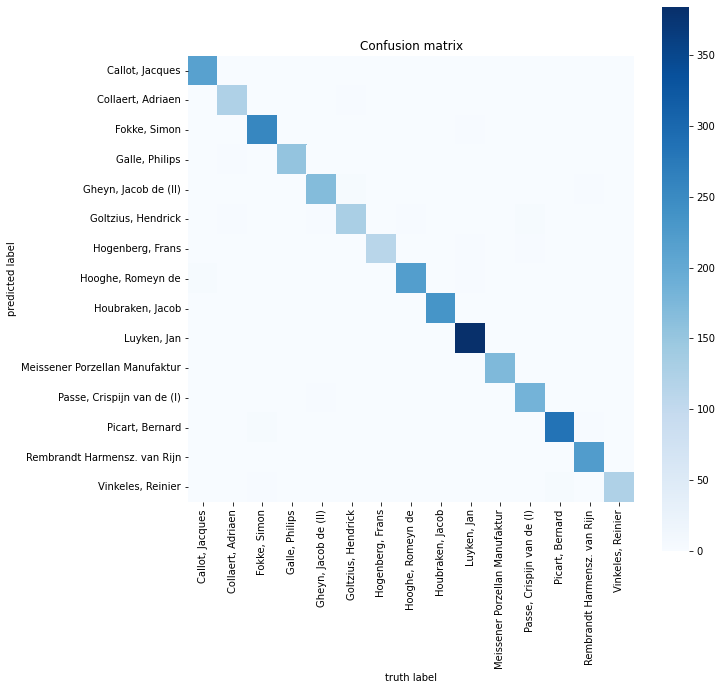

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
sns.heatmap(c_eval[5],square=True,fmt='d',cbar=True,xticklabels=encoder_c.classes_,yticklabels=encoder_c.classes_,cmap=plt.cm.Blues,ax=ax)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix')
plt.show()

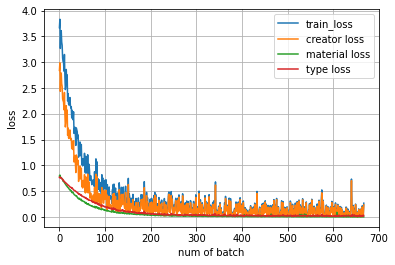

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss,label='train_loss')
plt.plot(train_loss_each[0],label='creator loss')
plt.plot(train_loss_each[1],label='material loss')
plt.plot(train_loss_each[2],label='type loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

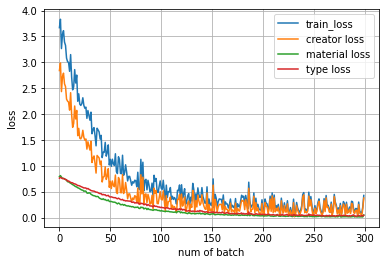

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss[0:300],label='train_loss')
plt.plot(train_loss_each[0][0:300],label='creator loss')
plt.plot(train_loss_each[1][0:300],label='material loss')
plt.plot(train_loss_each[2][0:300],label='type loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

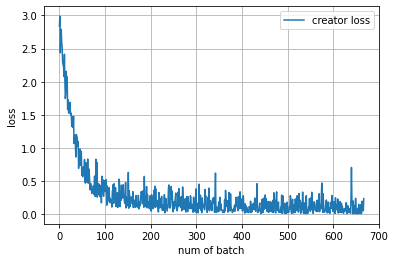

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_each[0],label='creator loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

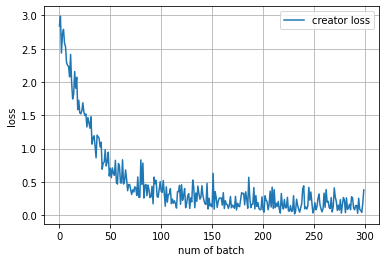

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_each[0][0:300],label='creator loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

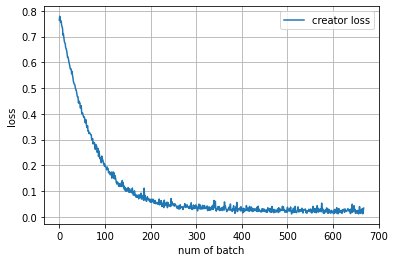

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_each[2],label='creator loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

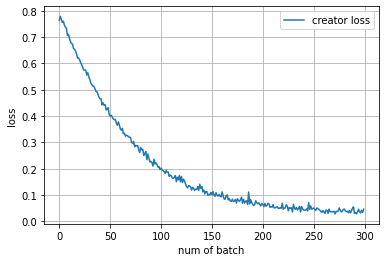

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_each[2][0:300],label='creator loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

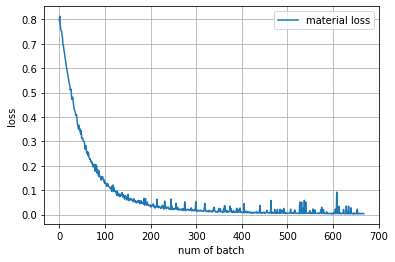

In [ ]:
plt.plot(train_loss_each[1],label='material loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

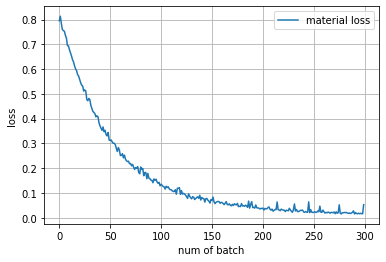

In [ ]:
plt.plot(train_loss_each[1][0:300],label='material loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# show loss
train_loss_1, train_loss_each_2 = train_main(model,loss_,optimizer,train_dataloader, device, num_epoch)
predict_r, label, metric =evaluate_whole(model, evaluate_loader=val_dataloader)
print(metric)
print(f'epoch{i+1} has been trained')

Epoch 1:   0%|          | 1/668 [00:00<04:28,  2.49batch/s, loss=0.0696]

[0.04732094] [0.00395451] [0.02199713]


Epoch 1:   0%|          | 2/668 [00:00<03:58,  2.79batch/s, loss=0.0409]

[0.03001889] [0.00237647] [0.01067202]


Epoch 1:   0%|          | 3/668 [00:01<03:46,  2.94batch/s, loss=0.116]

[0.08463142] [0.01751858] [0.03018924]


Epoch 1:   1%|          | 4/668 [00:01<03:58,  2.78batch/s, loss=0.0744]

[0.03313738] [0.00621339] [0.04080802]


Epoch 1:   1%|          | 5/668 [00:01<04:25,  2.50batch/s, loss=0.191]

[0.1630157] [0.00359453] [0.02813943]


Epoch 1:   1%|          | 6/668 [00:02<05:35,  1.97batch/s, loss=0.026]

[0.00472262] [0.00339793] [0.02102634]


Epoch 1:   1%|          | 7/668 [00:03<05:13,  2.11batch/s, loss=0.182]

[0.15858309] [0.00420814] [0.02328495]


Epoch 1:   1%|          | 8/668 [00:03<04:43,  2.33batch/s, loss=0.0409]

[0.02413511] [0.00250137] [0.01657481]


Epoch 1:   1%|▏         | 9/668 [00:03<04:22,  2.51batch/s, loss=0.0406]

[0.02353534] [0.00310822] [0.01684581]


Epoch 1:   1%|▏         | 10/668 [00:04<04:08,  2.65batch/s, loss=0.048]

[0.02947587] [0.00389275] [0.01825255]


Epoch 1:   2%|▏         | 11/668 [00:04<03:56,  2.78batch/s, loss=0.0867]

[0.06748507] [0.01698983] [0.01788933]


Epoch 1:   2%|▏         | 12/668 [00:04<03:50,  2.84batch/s, loss=0.261]

[0.2501861] [0.003155] [0.01016203]


Epoch 1:   2%|▏         | 13/668 [00:05<03:47,  2.88batch/s, loss=0.0334]

[0.01480973] [0.00321389] [0.01834637]


Epoch 1:   2%|▏         | 14/668 [00:05<03:47,  2.88batch/s, loss=0.139]

[0.11257091] [0.00342641] [0.02609292]


Epoch 1:   2%|▏         | 15/668 [00:05<03:41,  2.95batch/s, loss=0.0685]

[0.04535865] [0.00262444] [0.02293975]


Epoch 1:   2%|▏         | 16/668 [00:06<03:37,  3.00batch/s, loss=0.0226]

[0.00682224] [0.00241174] [0.01556221]


Epoch 1:   3%|▎         | 17/668 [00:06<03:39,  2.96batch/s, loss=0.358]

[0.34278095] [0.00255171] [0.0150354]


Epoch 1:   3%|▎         | 18/668 [00:06<03:35,  3.01batch/s, loss=0.0238]

[0.00936317] [0.00380752] [0.01409335]


Epoch 1:   3%|▎         | 19/668 [00:06<03:34,  3.02batch/s, loss=0.0361]

[0.02218647] [0.00427366] [0.01360853]


Epoch 1:   3%|▎         | 20/668 [00:07<03:34,  3.02batch/s, loss=0.026]

[0.00242459] [0.00298515] [0.02331532]


Epoch 1:   3%|▎         | 21/668 [00:07<03:35,  3.01batch/s, loss=0.0308]

[0.01262537] [0.00296242] [0.01795444]


Epoch 1:   3%|▎         | 22/668 [00:07<03:34,  3.01batch/s, loss=0.0777]

[0.02445561] [0.00395113] [0.05297164]


Epoch 1:   3%|▎         | 23/668 [00:08<03:35,  3.00batch/s, loss=0.112]

[0.09540014] [0.00334007] [0.01591235]


Epoch 1:   4%|▎         | 24/668 [00:08<03:33,  3.02batch/s, loss=0.0708]

[0.0461649] [0.01622022] [0.02336704]


Epoch 1:   4%|▎         | 25/668 [00:08<03:32,  3.03batch/s, loss=0.201]

[0.17031789] [0.00331148] [0.03079214]


Epoch 1:   4%|▍         | 26/668 [00:09<03:31,  3.04batch/s, loss=0.353]

[0.33957377] [0.00442422] [0.01346567]


Epoch 1:   4%|▍         | 27/668 [00:09<03:31,  3.04batch/s, loss=0.0526]

[0.041942] [0.00283583] [0.01038842]


Epoch 1:   4%|▍         | 28/668 [00:09<03:31,  3.02batch/s, loss=0.0817]

[0.06819528] [0.00356712] [0.01320796]


Epoch 1:   4%|▍         | 29/668 [00:10<03:31,  3.02batch/s, loss=0.119]

[0.09489144] [0.00268029] [0.02401]


Epoch 1:   4%|▍         | 30/668 [00:10<03:32,  3.01batch/s, loss=0.241]

[0.21814096] [0.00381973] [0.02280274]


Epoch 1:   5%|▍         | 31/668 [00:10<03:32,  3.00batch/s, loss=0.0309]

[0.01193429] [0.00285597] [0.01872811]


Epoch 1:   5%|▍         | 32/668 [00:11<03:29,  3.03batch/s, loss=0.113]

[0.09847527] [0.00278757] [0.01420467]


Epoch 1:   5%|▍         | 33/668 [00:11<03:32,  2.99batch/s, loss=0.0473]

[0.03265845] [0.00369464] [0.01432647]


Epoch 1:   5%|▌         | 34/668 [00:11<03:30,  3.01batch/s, loss=0.0431]

[0.0181958] [0.00361234] [0.024613]


Epoch 1:   5%|▌         | 35/668 [00:12<03:32,  2.98batch/s, loss=0.0275]

[0.00879709] [0.0302291] [0.01623503]


Epoch 1:   5%|▌         | 36/668 [00:12<03:34,  2.95batch/s, loss=0.0549]

[0.03093173] [0.00357627] [0.02368686]


Epoch 1:   6%|▌         | 37/668 [00:12<03:31,  2.98batch/s, loss=0.103]

[0.08109413] [0.01354] [0.02041258]


Epoch 1:   6%|▌         | 38/668 [00:13<03:27,  3.03batch/s, loss=0.0989]

[0.0859053] [0.0023856] [0.01275994]


Epoch 1:   6%|▌         | 39/668 [00:13<03:28,  3.01batch/s, loss=0.0491]

[0.01319344] [0.00342185] [0.0356406]


Epoch 1:   6%|▌         | 40/668 [00:13<03:26,  3.04batch/s, loss=0.0264]

[0.00735902] [0.002971] [0.01878962]


Epoch 1:   6%|▌         | 41/668 [00:14<03:25,  3.05batch/s, loss=0.146]

[0.13241804] [0.0031005] [0.01301735]


Epoch 1:   6%|▋         | 42/668 [00:14<03:25,  3.04batch/s, loss=0.0342]

[0.00212107] [0.00255014] [0.03185445]


Epoch 1:   6%|▋         | 43/668 [00:14<03:26,  3.03batch/s, loss=0.0377]

[0.02016702] [0.0024648] [0.01731438]


Epoch 1:   7%|▋         | 44/668 [00:15<03:27,  3.01batch/s, loss=0.137]

[0.11816581] [0.0037356] [0.01886514]


Epoch 1:   7%|▋         | 45/668 [00:15<03:27,  3.00batch/s, loss=0.212]

[0.17683436] [0.00555281] [0.03481152]


Epoch 1:   7%|▋         | 46/668 [00:15<03:25,  3.03batch/s, loss=0.0391]

[0.01790155] [0.01929632] [0.01967276]


Epoch 1:   7%|▋         | 47/668 [00:16<03:24,  3.03batch/s, loss=0.0219]

[0.0049168] [0.0029081] [0.01676207]


Epoch 1:   7%|▋         | 48/668 [00:16<03:28,  2.98batch/s, loss=0.0694]

[0.05310631] [0.00332383] [0.01600902]


Epoch 1:   7%|▋         | 49/668 [00:16<03:32,  2.91batch/s, loss=0.362]

[0.34608307] [0.00462906] [0.01601956]


Epoch 1:   7%|▋         | 50/668 [00:17<03:34,  2.88batch/s, loss=0.167]

[0.1156] [0.00365158] [0.05113388]


Epoch 1:   8%|▊         | 51/668 [00:17<03:31,  2.91batch/s, loss=0.288]

[0.26521468] [0.00370747] [0.02202313]


Epoch 1:   8%|▊         | 52/668 [00:18<03:28,  2.96batch/s, loss=0.0917]

[0.05748531] [0.00319362] [0.03400405]


Epoch 1:   8%|▊         | 53/668 [00:18<03:29,  2.94batch/s, loss=0.0781]

[0.06427746] [0.0022308] [0.01368584]


Epoch 1:   8%|▊         | 54/668 [00:18<03:30,  2.91batch/s, loss=0.141]

[0.10368623] [0.01478833] [0.03581044]


Epoch 1:   8%|▊         | 55/668 [00:19<03:27,  2.95batch/s, loss=0.2]

[0.16945803] [0.0032269] [0.03028239]


Epoch 1:   8%|▊         | 56/668 [00:19<03:39,  2.79batch/s, loss=0.165]

[0.14854436] [0.00731653] [0.01540688]


Epoch 1:   9%|▊         | 57/668 [00:19<03:45,  2.71batch/s, loss=0.03]

[0.01911687] [0.00249394] [0.0107226]


Epoch 1:   9%|▊         | 58/668 [00:20<03:51,  2.63batch/s, loss=0.294]

[0.21513425] [0.08150345] [0.07231221]


Epoch 1:   9%|▉         | 59/668 [00:20<04:12,  2.41batch/s, loss=0.0817]

[0.05275212] [0.00426802] [0.02863152]


Epoch 1:   9%|▉         | 60/668 [00:21<04:13,  2.40batch/s, loss=0.0697]

[0.03651728] [0.00325996] [0.03290548]


Epoch 1:   9%|▉         | 61/668 [00:21<03:58,  2.54batch/s, loss=0.221]

[0.1791826] [0.01365118] [0.040505]


Epoch 1:   9%|▉         | 62/668 [00:21<03:48,  2.65batch/s, loss=0.0413]

[0.02633149] [0.00303131] [0.01470116]


Epoch 1:   9%|▉         | 63/668 [00:22<03:42,  2.72batch/s, loss=0.112]

[0.08163093] [0.01339069] [0.02923074]


Epoch 1:  10%|▉         | 64/668 [00:22<03:35,  2.81batch/s, loss=0.0388]

[0.02165996] [0.00267902] [0.01694814]


Epoch 1:  10%|▉         | 65/668 [00:22<03:28,  2.89batch/s, loss=0.112]

[0.07347296] [0.00312758] [0.03847612]


Epoch 1:  10%|▉         | 66/668 [00:23<03:26,  2.91batch/s, loss=0.0332]

[0.00985872] [0.00258219] [0.02314338]


Epoch 1:  10%|█         | 67/668 [00:23<03:26,  2.91batch/s, loss=0.0318]

[0.01746283] [0.0025747] [0.01417515]


Epoch 1:  10%|█         | 68/668 [00:23<03:23,  2.95batch/s, loss=0.0505]

[0.03417091] [0.00364458] [0.01605386]


Epoch 1:  10%|█         | 69/668 [00:24<03:22,  2.96batch/s, loss=0.0905]

[0.07463174] [0.00262949] [0.01564721]


Epoch 1:  10%|█         | 70/668 [00:24<03:22,  2.95batch/s, loss=0.0269]

[0.01013479] [0.0024226] [0.01657844]


Epoch 1:  11%|█         | 71/668 [00:24<03:35,  2.77batch/s, loss=0.0249]

[0.00655152] [0.00259907] [0.01809931]


Epoch 1:  11%|█         | 72/668 [00:25<03:51,  2.58batch/s, loss=0.0641]

[0.04064023] [0.00300951] [0.02325457]


Epoch 1:  11%|█         | 73/668 [00:25<03:47,  2.61batch/s, loss=0.121]

[0.10529573] [0.01751109] [0.01477183]


Epoch 1:  11%|█         | 74/668 [00:26<03:37,  2.73batch/s, loss=0.226]

[0.20178074] [0.00539628] [0.02358181]


Epoch 1:  11%|█         | 75/668 [00:26<03:31,  2.80batch/s, loss=0.0644]

[0.03050837] [0.00314054] [0.03367047]


Epoch 1:  11%|█▏        | 76/668 [00:26<03:25,  2.88batch/s, loss=0.0846]

[0.06482249] [0.00277315] [0.01959278]


Epoch 1:  12%|█▏        | 77/668 [00:27<03:21,  2.93batch/s, loss=0.0215]

[0.01028801] [0.00267456] [0.01094806]


Epoch 1:  12%|█▏        | 78/668 [00:27<03:18,  2.97batch/s, loss=0.0295]

[0.02007407] [0.00291483] [0.0091711]


Epoch 1:  12%|█▏        | 79/668 [00:27<03:18,  2.97batch/s, loss=0.238]

[0.21589154] [0.00439918] [0.02208383]


Epoch 1:  12%|█▏        | 80/668 [00:28<03:18,  2.96batch/s, loss=0.0231]

[0.0074592] [0.00220331] [0.01543651]


Epoch 1:  12%|█▏        | 81/668 [00:28<03:17,  2.98batch/s, loss=0.0349]

[0.01251394] [0.00346289] [0.02214659]


Epoch 1:  12%|█▏        | 82/668 [00:28<03:15,  3.00batch/s, loss=0.304]

[0.2817854] [0.00339989] [0.02152092]


Epoch 1:  12%|█▏        | 83/668 [00:29<03:12,  3.04batch/s, loss=0.0412]

[0.00748202] [0.003306] [0.03348]


Epoch 1:  13%|█▎        | 84/668 [00:29<03:13,  3.01batch/s, loss=0.109]

[0.09017687] [0.00324505] [0.01839421]


Epoch 1:  13%|█▎        | 85/668 [00:29<03:15,  2.99batch/s, loss=0.0364]

[0.01336904] [0.00248649] [0.02284535]


Epoch 1:  13%|█▎        | 86/668 [00:30<03:16,  2.96batch/s, loss=0.0466]

[0.00807806] [0.0030784] [0.03829594]


Epoch 1:  13%|█▎        | 87/668 [00:30<03:16,  2.96batch/s, loss=0.0631]

[0.02550069] [0.00366769] [0.03729029]


Epoch 1:  13%|█▎        | 88/668 [00:30<03:14,  2.98batch/s, loss=0.04]

[0.01965658] [0.00259688] [0.02013003]


Epoch 1:  13%|█▎        | 89/668 [00:31<03:13,  3.00batch/s, loss=0.0572]

[0.02630996] [0.00286111] [0.03068548]


Epoch 1:  13%|█▎        | 90/668 [00:31<03:31,  2.74batch/s, loss=0.0292]

[0.00627882] [0.00253959] [0.02270184]


Epoch 1:  14%|█▎        | 91/668 [00:31<03:30,  2.75batch/s, loss=0.041]

[0.01896066] [0.00325188] [0.02175587]


Epoch 1:  14%|█▍        | 92/668 [00:32<03:23,  2.83batch/s, loss=0.0386]

[0.01921656] [0.00224681] [0.01922649]


Epoch 1:  14%|█▍        | 93/668 [00:32<03:20,  2.86batch/s, loss=0.0716]

[0.04379653] [0.00279989] [0.02754051]


Epoch 1:  14%|█▍        | 94/668 [00:32<03:19,  2.88batch/s, loss=0.0589]

[0.04164661] [0.00270355] [0.01706269]


Epoch 1:  14%|█▍        | 95/668 [00:33<03:15,  2.93batch/s, loss=0.0302]

[0.01349939] [0.00205369] [0.01656609]


Epoch 1:  14%|█▍        | 96/668 [00:33<03:11,  2.99batch/s, loss=0.0589]

[0.04366368] [0.00300353] [0.01502923]


Epoch 1:  15%|█▍        | 97/668 [00:33<03:11,  2.98batch/s, loss=0.0695]

[0.06000977] [0.00253618] [0.00928303]


Epoch 1:  15%|█▍        | 98/668 [00:34<03:13,  2.95batch/s, loss=0.0558]

[0.03301824] [0.00245761] [0.02261561]


Epoch 1:  15%|█▍        | 99/668 [00:34<03:15,  2.92batch/s, loss=0.159]

[0.14936474] [0.00435285] [0.00895568]


Epoch 1:  15%|█▍        | 100/668 [00:34<03:28,  2.73batch/s, loss=0.0183]

[0.00682705] [0.00239938] [0.01130986]


Epoch 1:  15%|█▌        | 101/668 [00:35<03:40,  2.57batch/s, loss=0.161]

[0.1440605] [0.00290191] [0.01660985]


Epoch 1:  15%|█▌        | 102/668 [00:36<04:19,  2.18batch/s, loss=0.0523]

[0.03615219] [0.00230392] [0.01593433]


Epoch 1:  15%|█▌        | 103/668 [00:36<04:20,  2.17batch/s, loss=0.0449]

[0.0281495] [0.00343861] [0.01645619]


Epoch 1:  16%|█▌        | 104/668 [00:36<04:00,  2.35batch/s, loss=0.154]

[0.13574357] [0.00228599] [0.01856414]


Epoch 1:  16%|█▌        | 105/668 [00:37<03:44,  2.51batch/s, loss=0.0317]

[0.01387684] [0.00236617] [0.01762245]


Epoch 1:  16%|█▌        | 106/668 [00:37<03:56,  2.38batch/s, loss=0.0662]

[0.03470002] [0.04103547] [0.02823529]


Epoch 1:  16%|█▌        | 107/668 [00:37<03:39,  2.56batch/s, loss=0.191]

[0.1568153] [0.00670039] [0.03320435]


Epoch 1:  16%|█▌        | 108/668 [00:38<03:44,  2.49batch/s, loss=0.0365]

[0.02556545] [0.00368774] [0.01065523]


Epoch 1:  16%|█▋        | 109/668 [00:38<04:02,  2.31batch/s, loss=0.0436]

[0.02421249] [0.00205193] [0.01923831]


Epoch 1:  16%|█▋        | 110/668 [00:39<04:04,  2.28batch/s, loss=0.0738]

[0.04095748] [0.02011031] [0.03121453]


Epoch 1:  17%|█▋        | 111/668 [00:39<04:02,  2.30batch/s, loss=0.2]

[0.17768952] [0.00306377] [0.02169108]


Epoch 1:  17%|█▋        | 112/668 [00:40<03:55,  2.36batch/s, loss=0.0306]

[0.00795745] [0.0020981] [0.02250434]


Epoch 1:  17%|█▋        | 113/668 [00:40<04:20,  2.13batch/s, loss=0.0383]

[0.02276213] [0.00274206] [0.01530426]


Epoch 1:  17%|█▋        | 114/668 [00:41<04:25,  2.09batch/s, loss=0.028]

[0.00489447] [0.00263256] [0.02292178]


Epoch 1:  17%|█▋        | 115/668 [00:41<04:31,  2.03batch/s, loss=0.163]

[0.14448273] [0.00454239] [0.01768119]


Epoch 1:  17%|█▋        | 116/668 [00:42<04:06,  2.24batch/s, loss=0.0705]

[0.05639751] [0.00369158] [0.01375805]


Epoch 1:  18%|█▊        | 117/668 [00:42<03:48,  2.41batch/s, loss=0.179]

[0.1368079] [0.0182967] [0.04032466]


Epoch 1:  18%|█▊        | 118/668 [00:42<03:33,  2.57batch/s, loss=0.0287]

[0.01348502] [0.00283051] [0.01499069]


Epoch 1:  18%|█▊        | 119/668 [00:43<03:25,  2.67batch/s, loss=0.0464]

[0.02868834] [0.00283698] [0.01748776]


Epoch 1:  18%|█▊        | 120/668 [00:43<03:18,  2.76batch/s, loss=0.116]

[0.08802658] [0.01578072] [0.0269799]


Epoch 1:  18%|█▊        | 121/668 [00:43<03:14,  2.82batch/s, loss=0.0348]

[0.01473435] [0.00191032] [0.01988771]


Epoch 1:  18%|█▊        | 122/668 [00:44<03:10,  2.87batch/s, loss=0.0352]

[0.01484761] [0.01595852] [0.01910042]


Epoch 1:  18%|█▊        | 123/668 [00:44<03:06,  2.92batch/s, loss=0.034]

[0.01500082] [0.0024453] [0.01881914]


Epoch 1:  19%|█▊        | 124/668 [00:44<03:04,  2.95batch/s, loss=0.119]

[0.09774528] [0.03921212] [0.01807689]


Epoch 1:  19%|█▊        | 125/668 [00:45<03:02,  2.98batch/s, loss=0.17]

[0.1586936] [0.00238459] [0.01113673]


Epoch 1:  19%|█▉        | 126/668 [00:45<03:04,  2.94batch/s, loss=0.0658]

[0.04820226] [0.00236523] [0.0173828]


Epoch 1:  19%|█▉        | 127/668 [00:45<03:03,  2.94batch/s, loss=0.0584]

[0.03040865] [0.00255532] [0.02782067]


Epoch 1:  19%|█▉        | 128/668 [00:46<03:03,  2.95batch/s, loss=0.0317]

[0.01053814] [0.00227664] [0.02097306]


Epoch 1:  19%|█▉        | 129/668 [00:46<03:09,  2.85batch/s, loss=0.104]

[0.07600655] [0.00336343] [0.02793965]


Epoch 1:  19%|█▉        | 130/668 [00:46<03:24,  2.63batch/s, loss=0.0671]

[0.03695008] [0.03500352] [0.02734458]


Epoch 1:  20%|█▉        | 131/668 [00:47<03:17,  2.72batch/s, loss=0.0283]

[0.01534428] [0.00225168] [0.01273942]


Epoch 1:  20%|█▉        | 132/668 [00:47<03:13,  2.77batch/s, loss=0.0368]

[0.02747532] [0.00249939] [0.0090911]


Epoch 1:  20%|█▉        | 133/668 [00:48<03:10,  2.81batch/s, loss=0.112]

[0.0882517] [0.03729172] [0.02062744]


Epoch 1:  20%|██        | 134/668 [00:48<03:05,  2.88batch/s, loss=0.187]

[0.16723825] [0.00551269] [0.01959362]


Epoch 1:  20%|██        | 135/668 [00:48<03:04,  2.89batch/s, loss=0.031]

[0.01255167] [0.00303992] [0.01824921]


Epoch 1:  20%|██        | 136/668 [00:49<03:03,  2.91batch/s, loss=0.256]

[0.23556273] [0.00302755] [0.02022589]


Epoch 1:  21%|██        | 137/668 [00:49<03:01,  2.92batch/s, loss=0.0239]

[0.01211828] [0.00269334] [0.0115496]


Epoch 1:  21%|██        | 138/668 [00:49<03:00,  2.93batch/s, loss=0.112]

[0.08707128] [0.00394562] [0.02483056]


Epoch 1:  21%|██        | 139/668 [00:50<03:00,  2.93batch/s, loss=0.0572]

[0.04031983] [0.00318892] [0.01658682]


Epoch 1:  21%|██        | 140/668 [00:50<03:00,  2.93batch/s, loss=0.262]

[0.23419294] [0.00222129] [0.02739513]


Epoch 1:  21%|██        | 141/668 [00:50<02:58,  2.95batch/s, loss=0.0159]

[0.00537444] [0.00165829] [0.01035809]


Epoch 1:  21%|██▏       | 142/668 [00:51<02:57,  2.97batch/s, loss=0.0956]

[0.07397585] [0.00312707] [0.0213733]


Epoch 1:  21%|██▏       | 143/668 [00:51<02:58,  2.94batch/s, loss=0.03]

[0.0116369] [0.00256461] [0.01811929]


Epoch 1:  22%|██▏       | 144/668 [00:51<03:12,  2.72batch/s, loss=0.139]

[0.1262252] [0.00400282] [0.01195771]


Epoch 1:  22%|██▏       | 145/668 [00:52<03:18,  2.64batch/s, loss=0.0428]

[0.02442888] [0.00219467] [0.01823129]


Epoch 1:  22%|██▏       | 146/668 [00:52<03:25,  2.54batch/s, loss=0.0158]

[0.00679926] [0.00242943] [0.00875998]


Epoch 1:  22%|██▏       | 147/668 [00:53<03:28,  2.50batch/s, loss=0.0967]

[0.07644309] [0.00261519] [0.02006338]


Epoch 1:  22%|██▏       | 148/668 [00:53<03:25,  2.54batch/s, loss=0.0192]

[0.0024995] [0.00213035] [0.01652581]


Epoch 1:  22%|██▏       | 149/668 [00:53<03:16,  2.65batch/s, loss=0.0321]

[0.00795798] [0.00256807] [0.02398628]


Epoch 1:  22%|██▏       | 150/668 [00:54<03:22,  2.56batch/s, loss=0.28]

[0.2611861] [0.002458] [0.01841426]


Epoch 1:  23%|██▎       | 151/668 [00:54<04:19,  1.99batch/s, loss=0.0528]

[0.02507307] [0.0019743] [0.02756961]


Epoch 1:  23%|██▎       | 152/668 [00:55<03:55,  2.20batch/s, loss=0.0191]

[0.0015726] [0.0022757] [0.01731467]


Epoch 1:  23%|██▎       | 153/668 [00:55<03:37,  2.37batch/s, loss=0.148]

[0.13099913] [0.00266024] [0.01665016]


Epoch 1:  23%|██▎       | 154/668 [00:56<03:24,  2.51batch/s, loss=0.142]

[0.11047249] [0.00193027] [0.03130115]


Epoch 1:  23%|██▎       | 155/668 [00:56<03:14,  2.64batch/s, loss=0.0468]

[0.03524903] [0.00245414] [0.01139807]


Epoch 1:  23%|██▎       | 156/668 [00:56<03:06,  2.75batch/s, loss=0.0305]

[0.01044965] [0.00238948] [0.01982827]


Epoch 1:  24%|██▎       | 157/668 [00:57<03:02,  2.79batch/s, loss=0.0303]

[0.02077551] [0.00274757] [0.00932619]


Epoch 1:  24%|██▎       | 158/668 [00:57<03:00,  2.83batch/s, loss=0.19]

[0.16460398] [0.00732506] [0.02506239]


Epoch 1:  24%|██▍       | 159/668 [00:57<02:56,  2.89batch/s, loss=0.0387]

[0.02003894] [0.00150291] [0.01850986]


Epoch 1:  24%|██▍       | 160/668 [00:58<02:56,  2.88batch/s, loss=0.118]

[0.09172261] [0.00390161] [0.02626744]


Epoch 1:  24%|██▍       | 161/668 [00:58<02:55,  2.89batch/s, loss=0.0655]

[0.04747128] [0.00213657] [0.0179029]


Epoch 1:  24%|██▍       | 162/668 [00:58<02:53,  2.92batch/s, loss=0.225]

[0.20228417] [0.00227157] [0.02242889]


Epoch 1:  24%|██▍       | 163/668 [00:59<02:53,  2.91batch/s, loss=0.0157]

[0.00410311] [0.00193297] [0.01147329]


Epoch 1:  25%|██▍       | 164/668 [00:59<02:51,  2.94batch/s, loss=0.0707]

[0.05281495] [0.00208267] [0.01769266]


Epoch 1:  25%|██▍       | 165/668 [00:59<02:52,  2.91batch/s, loss=0.341]

[0.2989885] [0.03234474] [0.03965994]


Epoch 1:  25%|██▍       | 166/668 [01:00<02:53,  2.89batch/s, loss=0.042]

[0.01086274] [0.00224853] [0.03099136]


Epoch 1:  25%|██▌       | 167/668 [01:00<02:52,  2.90batch/s, loss=0.0415]

[0.01944556] [0.00275003] [0.02180957]


Epoch 1:  25%|██▌       | 168/668 [01:00<02:50,  2.93batch/s, loss=0.0443]

[0.02849903] [0.00234273] [0.01558796]


Epoch 1:  25%|██▌       | 169/668 [01:01<02:49,  2.94batch/s, loss=0.0437]

[0.02665932] [0.00257788] [0.0168374]


Epoch 1:  25%|██▌       | 170/668 [01:01<02:49,  2.95batch/s, loss=0.0587]

[0.04000972] [0.00355295] [0.01843523]


Epoch 1:  26%|██▌       | 171/668 [01:01<02:50,  2.91batch/s, loss=0.105]

[0.07735372] [0.00252812] [0.02721825]


Epoch 1:  26%|██▌       | 172/668 [01:02<02:47,  2.96batch/s, loss=0.0201]

[0.00634585] [0.00152541] [0.01359709]


Epoch 1:  26%|██▌       | 173/668 [01:02<02:47,  2.95batch/s, loss=0.0599]

[0.04616898] [0.00203693] [0.01359994]


Epoch 1:  26%|██▌       | 174/668 [01:02<02:45,  2.98batch/s, loss=0.0846]

[0.05457935] [0.00213148] [0.02982]


Epoch 1:  26%|██▌       | 175/668 [01:03<02:45,  2.97batch/s, loss=0.0281]

[0.01656805] [0.00276572] [0.01128862]


Epoch 1:  26%|██▋       | 176/668 [01:03<02:45,  2.97batch/s, loss=0.038]

[0.02684365] [0.00238363] [0.01093719]


Epoch 1:  26%|██▋       | 177/668 [01:03<02:46,  2.95batch/s, loss=0.04]

[0.02325127] [0.01912108] [0.01519155]


Epoch 1:  27%|██▋       | 178/668 [01:04<02:45,  2.95batch/s, loss=0.0467]

[0.00902247] [0.00238799] [0.03745354]


Epoch 1:  27%|██▋       | 179/668 [01:04<02:45,  2.95batch/s, loss=0.113]

[0.0892337] [0.00275571] [0.02400272]


Epoch 1:  27%|██▋       | 180/668 [01:04<02:45,  2.95batch/s, loss=0.118]

[0.10365028] [0.00199353] [0.01397217]


Epoch 1:  27%|██▋       | 181/668 [01:05<02:44,  2.95batch/s, loss=0.159]

[0.1402691] [0.00217402] [0.01861716]


Epoch 1:  27%|██▋       | 182/668 [01:05<02:45,  2.94batch/s, loss=0.0677]

[0.04552944] [0.00198391] [0.02198836]


Epoch 1:  27%|██▋       | 183/668 [01:05<02:45,  2.93batch/s, loss=0.211]

[0.18569432] [0.00234677] [0.02551315]


Epoch 1:  28%|██▊       | 184/668 [01:06<02:45,  2.93batch/s, loss=0.028]

[0.01670834] [0.00194724] [0.01112496]


Epoch 1:  28%|██▊       | 185/668 [01:06<02:45,  2.92batch/s, loss=0.0579]

[0.04725698] [0.00176769] [0.01052248]


Epoch 1:  28%|██▊       | 186/668 [01:06<02:45,  2.91batch/s, loss=0.0406]

[0.03090985] [0.00183778] [0.00957644]


Epoch 1:  28%|██▊       | 187/668 [01:07<03:31,  2.27batch/s, loss=0.0861]

[0.05717682] [0.00233081] [0.02877874]


Epoch 1:  28%|██▊       | 188/668 [01:08<04:11,  1.91batch/s, loss=0.0421]

[0.02069857] [0.00225836] [0.02125196]


Epoch 1:  28%|██▊       | 189/668 [01:08<03:51,  2.07batch/s, loss=0.0956]

[0.077113] [0.00186132] [0.01832698]


Epoch 1:  28%|██▊       | 190/668 [01:09<03:35,  2.22batch/s, loss=0.129]

[0.11317057] [0.00146651] [0.01593335]


Epoch 1:  29%|██▊       | 191/668 [01:09<03:25,  2.32batch/s, loss=0.0186]

[0.00681363] [0.00185335] [0.01165699]


Epoch 1:  29%|██▊       | 192/668 [01:09<03:18,  2.39batch/s, loss=0.0716]

[0.04647981] [0.00166513] [0.02496064]


Epoch 1:  29%|██▉       | 193/668 [01:10<03:11,  2.48batch/s, loss=0.0466]

[0.02753408] [0.00269187] [0.01881835]


Epoch 1:  29%|██▉       | 194/668 [01:10<03:09,  2.50batch/s, loss=0.0281]

[0.00654225] [0.00183319] [0.02144735]


Epoch 1:  29%|██▉       | 195/668 [01:10<03:05,  2.55batch/s, loss=0.0883]

[0.07193543] [0.00205359] [0.01620214]


Epoch 1:  29%|██▉       | 196/668 [01:11<03:04,  2.56batch/s, loss=0.0691]

[0.05383527] [0.00248824] [0.01504527]


Epoch 1:  29%|██▉       | 197/668 [01:11<03:04,  2.56batch/s, loss=0.0316]

[0.01047196] [0.01817735] [0.01970359]


Epoch 1:  30%|██▉       | 198/668 [01:12<03:05,  2.53batch/s, loss=0.106]

[0.08187144] [0.00312535] [0.02380884]


Epoch 1:  30%|██▉       | 199/668 [01:12<03:04,  2.54batch/s, loss=0.0579]

[0.03882588] [0.00219303] [0.018861]


Epoch 1:  30%|██▉       | 200/668 [01:12<02:56,  2.66batch/s, loss=0.161]

[0.13513571] [0.03677464] [0.02255681]


Epoch 1:  30%|███       | 201/668 [01:13<02:49,  2.76batch/s, loss=0.0998]

[0.074062] [0.00254403] [0.02554946]


Epoch 1:  30%|███       | 202/668 [01:13<02:45,  2.82batch/s, loss=0.0688]

[0.04788243] [0.00234578] [0.02070437]


Epoch 1:  30%|███       | 203/668 [01:13<02:41,  2.88batch/s, loss=0.0243]

[0.01207876] [0.0025477] [0.01198496]


Epoch 1:  31%|███       | 204/668 [01:14<02:38,  2.92batch/s, loss=0.215]

[0.18633313] [0.00205918] [0.02857744]


Epoch 1:  31%|███       | 205/668 [01:14<02:37,  2.93batch/s, loss=0.0284]

[0.01021599] [0.00166495] [0.0180425]


Epoch 1:  31%|███       | 206/668 [01:14<02:37,  2.93batch/s, loss=0.162]

[0.13038296] [0.02913993] [0.02896123]


Epoch 1:  31%|███       | 207/668 [01:15<02:36,  2.95batch/s, loss=0.0442]

[0.00753546] [0.00190766] [0.03648692]


Epoch 1:  31%|███       | 208/668 [01:15<02:35,  2.96batch/s, loss=0.0202]

[0.00771114] [0.0019703] [0.01228608]


Epoch 1:  31%|███▏      | 209/668 [01:15<02:35,  2.95batch/s, loss=0.0164]

[0.00230092] [0.00200557] [0.01394919]


Epoch 1:  31%|███▏      | 210/668 [01:16<02:34,  2.97batch/s, loss=0.149]

[0.12939554] [0.00254386] [0.01948993]


Epoch 1:  32%|███▏      | 211/668 [01:16<02:32,  3.00batch/s, loss=0.204]

[0.16193573] [0.00299135] [0.04181557]


Epoch 1:  32%|███▏      | 212/668 [01:16<02:31,  3.02batch/s, loss=0.0312]

[0.00479368] [0.00172905] [0.02622701]


Epoch 1:  32%|███▏      | 213/668 [01:17<02:34,  2.95batch/s, loss=0.0287]

[0.01664227] [0.00255579] [0.01189201]


Epoch 1:  32%|███▏      | 214/668 [01:17<02:36,  2.90batch/s, loss=0.162]

[0.14663903] [0.00180879] [0.01559205]


Epoch 1:  32%|███▏      | 215/668 [01:17<02:38,  2.86batch/s, loss=0.332]

[0.3036002] [0.02540666] [0.02650937]


Epoch 1:  32%|███▏      | 216/668 [01:18<02:38,  2.86batch/s, loss=0.0257]

[0.00525109] [0.00373799] [0.02019531]


Epoch 1:  32%|███▏      | 217/668 [01:18<02:36,  2.89batch/s, loss=0.129]

[0.10922418] [0.00234465] [0.01945327]


Epoch 1:  33%|███▎      | 218/668 [01:18<02:33,  2.93batch/s, loss=0.118]

[0.09911206] [0.00219157] [0.01884591]


Epoch 1:  33%|███▎      | 219/668 [01:19<02:32,  2.95batch/s, loss=0.0489]

[0.03062968] [0.00264844] [0.01807485]


Epoch 1:  33%|███▎      | 220/668 [01:19<02:30,  2.97batch/s, loss=0.0414]

[0.02114911] [0.00210185] [0.020112]


Epoch 1:  33%|███▎      | 221/668 [01:19<02:30,  2.97batch/s, loss=0.0552]

[0.04148735] [0.00176104] [0.01356305]


Epoch 1:  33%|███▎      | 222/668 [01:20<02:29,  2.99batch/s, loss=0.0363]

[0.01195688] [0.00192038] [0.02422356]


Epoch 1:  33%|███▎      | 223/668 [01:20<02:28,  2.99batch/s, loss=0.233]

[0.21671236] [0.0024019] [0.01599628]


Epoch 1:  34%|███▎      | 224/668 [01:20<02:26,  3.02batch/s, loss=0.0731]

[0.04280489] [0.00617045] [0.02978247]


Epoch 1:  34%|███▎      | 225/668 [01:21<02:28,  2.98batch/s, loss=0.237]

[0.21133062] [0.01169059] [0.0243419]


Epoch 1:  34%|███▍      | 226/668 [01:21<02:30,  2.93batch/s, loss=0.0827]

[0.06346186] [0.00313418] [0.01898137]


Epoch 1:  34%|███▍      | 227/668 [01:21<02:31,  2.91batch/s, loss=0.0499]

[0.02891843] [0.00196885] [0.02078401]


Epoch 1:  34%|███▍      | 228/668 [01:22<02:29,  2.94batch/s, loss=0.454]

[0.43773425] [0.00276032] [0.01639464]


Epoch 1:  34%|███▍      | 229/668 [01:22<02:26,  2.99batch/s, loss=0.0457]

[0.01937676] [0.00199398] [0.02615304]


Epoch 1:  34%|███▍      | 230/668 [01:22<02:25,  3.00batch/s, loss=0.0746]

[0.06218648] [0.00204033] [0.0122854]


Epoch 1:  35%|███▍      | 231/668 [01:23<02:24,  3.02batch/s, loss=0.0417]

[0.01562546] [0.00322989] [0.02580532]


Epoch 1:  35%|███▍      | 232/668 [01:23<02:25,  2.99batch/s, loss=0.0176]

[0.00646891] [0.00179753] [0.0109516]


Epoch 1:  35%|███▍      | 233/668 [01:23<02:25,  3.00batch/s, loss=0.148]

[0.13010484] [0.00214778] [0.01749595]


Epoch 1:  35%|███▌      | 234/668 [01:24<02:23,  3.02batch/s, loss=0.0911]

[0.06936521] [0.00249353] [0.02153013]


Epoch 1:  35%|███▌      | 235/668 [01:24<02:24,  2.99batch/s, loss=0.0742]

[0.05623295] [0.0018586] [0.01777662]


Epoch 1:  35%|███▌      | 236/668 [01:24<02:23,  3.00batch/s, loss=0.0399]

[0.01665853] [0.02983065] [0.02082223]


Epoch 1:  35%|███▌      | 237/668 [01:25<02:23,  3.01batch/s, loss=0.086]

[0.05759286] [0.00292506] [0.02817622]


Epoch 1:  36%|███▌      | 238/668 [01:25<02:24,  2.98batch/s, loss=0.148]

[0.12115478] [0.0156021] [0.02551197]


Epoch 1:  36%|███▌      | 239/668 [01:25<02:23,  2.99batch/s, loss=0.0537]

[0.04120402] [0.00258922] [0.01233441]


Epoch 1:  36%|███▌      | 240/668 [01:26<02:31,  2.83batch/s, loss=0.1]

[0.07096073] [0.00200459] [0.0292682]


Epoch 1:  36%|███▌      | 241/668 [01:26<02:40,  2.66batch/s, loss=0.0666]

[0.04692057] [0.00176264] [0.01955625]


Epoch 1:  36%|███▌      | 242/668 [01:27<02:48,  2.53batch/s, loss=0.0393]

[0.00925546] [0.00173202] [0.02989391]


Epoch 1:  36%|███▋      | 243/668 [01:27<02:39,  2.67batch/s, loss=0.0311]

[0.01376378] [0.0015675] [0.01724981]


Epoch 1:  37%|███▋      | 244/668 [01:27<02:33,  2.76batch/s, loss=0.0184]

[0.00398899] [0.00199776] [0.01426489]


Epoch 1:  37%|███▋      | 245/668 [01:28<02:30,  2.81batch/s, loss=0.0355]

[0.01289165] [0.00167677] [0.02251345]


Epoch 1:  37%|███▋      | 246/668 [01:28<02:27,  2.85batch/s, loss=0.185]

[0.16210942] [0.02156961] [0.02131881]


Epoch 1:  37%|███▋      | 247/668 [01:28<02:24,  2.92batch/s, loss=0.0457]

[0.02728111] [0.00205371] [0.01824093]


Epoch 1:  37%|███▋      | 248/668 [01:29<02:21,  2.96batch/s, loss=0.243]

[0.2274966] [0.00237348] [0.01574467]


Epoch 1:  37%|███▋      | 249/668 [01:29<02:21,  2.96batch/s, loss=0.0631]

[0.03594851] [0.00219799] [0.0269793]


Epoch 1:  37%|███▋      | 250/668 [01:29<02:21,  2.96batch/s, loss=0.0178]

[0.00259534] [0.00176711] [0.01509564]


Epoch 1:  38%|███▊      | 251/668 [01:30<02:37,  2.65batch/s, loss=0.122]

[0.10042097] [0.0017516] [0.02100672]


Epoch 1:  38%|███▊      | 252/668 [01:30<02:33,  2.70batch/s, loss=0.0477]

[0.0316271] [0.00174444] [0.01596705]


Epoch 1:  38%|███▊      | 253/668 [01:31<02:28,  2.80batch/s, loss=0.211]

[0.1819475] [0.00239898] [0.02919285]


Epoch 1:  38%|███▊      | 254/668 [01:31<02:25,  2.85batch/s, loss=0.175]

[0.15804346] [0.00254749] [0.01692132]


Epoch 1:  38%|███▊      | 255/668 [01:31<02:21,  2.91batch/s, loss=0.026]

[0.01122213] [0.00176874] [0.01465649]


Epoch 1:  38%|███▊      | 256/668 [01:32<02:20,  2.94batch/s, loss=0.065]

[0.04498282] [0.00269936] [0.01976979]


Epoch 1:  38%|███▊      | 257/668 [01:32<02:21,  2.91batch/s, loss=0.0837]

[0.0593014] [0.0021849] [0.02419262]


Epoch 1:  39%|███▊      | 258/668 [01:32<02:21,  2.90batch/s, loss=0.0273]

[0.00467851] [0.00162675] [0.02245506]


Epoch 1:  39%|███▉      | 259/668 [01:33<02:19,  2.93batch/s, loss=0.0419]

[0.02075104] [0.00213024] [0.02095507]


Epoch 1:  39%|███▉      | 260/668 [01:33<02:18,  2.94batch/s, loss=0.0401]

[0.02604955] [0.00154738] [0.01391574]


Epoch 1:  39%|███▉      | 261/668 [01:33<02:18,  2.95batch/s, loss=0.0999]

[0.08282661] [0.00267488] [0.01688473]


Epoch 1:  39%|███▉      | 262/668 [01:34<02:22,  2.85batch/s, loss=0.0595]

[0.01594017] [0.04271939] [0.0401697]


Epoch 1:  39%|███▉      | 263/668 [01:34<02:34,  2.62batch/s, loss=0.0739]

[0.03281463] [0.00224946] [0.04089907]


Epoch 1:  40%|███▉      | 264/668 [01:34<02:27,  2.74batch/s, loss=0.03]

[0.01866232] [0.00193183] [0.01113631]


Epoch 1:  40%|███▉      | 265/668 [01:35<02:23,  2.81batch/s, loss=0.137]

[0.10557031] [0.04867978] [0.02772358]


Epoch 1:  40%|███▉      | 266/668 [01:35<02:19,  2.88batch/s, loss=0.0297]

[0.01438702] [0.00133929] [0.01524312]


Epoch 1:  40%|███▉      | 267/668 [01:35<02:17,  2.91batch/s, loss=0.29]

[0.2648529] [0.00260219] [0.02498324]


Epoch 1:  40%|████      | 268/668 [01:36<02:16,  2.94batch/s, loss=0.0647]

[0.03877611] [0.03493632] [0.02310405]


Epoch 1:  40%|████      | 269/668 [01:36<02:18,  2.88batch/s, loss=0.0572]

[0.01994591] [0.00211565] [0.03706158]


Epoch 1:  40%|████      | 270/668 [01:36<02:17,  2.90batch/s, loss=0.0728]

[0.05634566] [0.00180697] [0.01632146]


Epoch 1:  41%|████      | 271/668 [01:37<02:15,  2.93batch/s, loss=0.0229]

[0.00599454] [0.00157622] [0.0167542]


Epoch 1:  41%|████      | 272/668 [01:37<02:14,  2.95batch/s, loss=0.0495]

[0.03646116] [0.00235687] [0.01289667]


Epoch 1:  41%|████      | 273/668 [01:37<02:15,  2.92batch/s, loss=0.0711]

[0.0372134] [0.0015357] [0.03377961]


Epoch 1:  41%|████      | 274/668 [01:38<02:16,  2.89batch/s, loss=0.0679]

[0.0564942] [0.00222542] [0.01119899]


Epoch 1:  41%|████      | 275/668 [01:38<02:24,  2.71batch/s, loss=0.0447]

[0.0245883] [0.00204015] [0.01992485]


Epoch 1:  41%|████▏     | 276/668 [01:39<02:43,  2.40batch/s, loss=0.0915]

[0.07877529] [0.00142588] [0.0126042]


Epoch 1:  41%|████▏     | 277/668 [01:39<02:51,  2.28batch/s, loss=0.227]

[0.1995844] [0.0019986] [0.02765116]


Epoch 1:  42%|████▏     | 278/668 [01:40<02:39,  2.45batch/s, loss=0.249]

[0.22234188] [0.02113142] [0.02536605]


Epoch 1:  42%|████▏     | 279/668 [01:40<02:30,  2.58batch/s, loss=0.031]

[0.01283606] [0.00260534] [0.01798914]


Epoch 1:  42%|████▏     | 280/668 [01:40<02:23,  2.70batch/s, loss=0.0258]

[0.00543215] [0.00156331] [0.02019466]


Epoch 1:  42%|████▏     | 281/668 [01:41<02:18,  2.79batch/s, loss=0.0376]

[0.01180711] [0.00189179] [0.02564303]


Epoch 1:  42%|████▏     | 282/668 [01:41<02:18,  2.79batch/s, loss=0.0474]

[0.02827791] [0.00179503] [0.01896104]


Epoch 1:  42%|████▏     | 283/668 [01:41<02:27,  2.61batch/s, loss=0.0909]

[0.07261422] [0.00196107] [0.01811946]


Epoch 1:  43%|████▎     | 284/668 [01:42<02:22,  2.69batch/s, loss=0.0366]

[0.0209722] [0.00167237] [0.01554145]


Epoch 1:  43%|████▎     | 285/668 [01:42<02:49,  2.26batch/s, loss=0.157]

[0.13895532] [0.00167368] [0.0177563]


Epoch 1:  43%|████▎     | 286/668 [01:43<02:49,  2.25batch/s, loss=0.042]

[0.01732924] [0.00178559] [0.02456379]


Epoch 1:  43%|████▎     | 287/668 [01:43<02:46,  2.29batch/s, loss=0.117]

[0.09558235] [0.00166685] [0.02114913]


Epoch 1:  43%|████▎     | 288/668 [01:44<03:15,  1.95batch/s, loss=0.0971]

[0.07310165] [0.00189691] [0.02386862]


Epoch 1:  43%|████▎     | 289/668 [01:44<02:55,  2.16batch/s, loss=0.0766]

[0.05197857] [0.0175672] [0.02322163]


Epoch 1:  43%|████▎     | 290/668 [01:45<02:42,  2.33batch/s, loss=0.18]

[0.16466215] [0.00193223] [0.0149054]


Epoch 1:  44%|████▎     | 291/668 [01:45<02:30,  2.51batch/s, loss=0.199]

[0.17893605] [0.00318312] [0.02002453]


Epoch 1:  44%|████▎     | 292/668 [01:45<02:22,  2.64batch/s, loss=0.0263]

[0.01095382] [0.00191669] [0.01516883]


Epoch 1:  44%|████▍     | 293/668 [01:46<02:17,  2.72batch/s, loss=0.0379]

[0.02572505] [0.00157322] [0.01206844]


Epoch 1:  44%|████▍     | 294/668 [01:46<02:14,  2.79batch/s, loss=0.0412]

[0.0235537] [0.00168206] [0.0174772]


Epoch 1:  44%|████▍     | 295/668 [01:46<02:10,  2.86batch/s, loss=0.102]

[0.08940683] [0.00216901] [0.01249335]


Epoch 1:  44%|████▍     | 296/668 [01:47<02:08,  2.89batch/s, loss=0.0223]

[0.00429896] [0.00172756] [0.0178389]


Epoch 1:  44%|████▍     | 297/668 [01:47<02:11,  2.82batch/s, loss=0.0728]

[0.04928877] [0.00283316] [0.02329683]


Epoch 1:  45%|████▍     | 298/668 [01:47<02:11,  2.82batch/s, loss=0.0354]

[0.01324841] [0.00168804] [0.02203058]


Epoch 1:  45%|████▍     | 299/668 [01:48<02:10,  2.83batch/s, loss=0.0483]

[0.02676518] [0.00259364] [0.02135532]


Epoch 1:  45%|████▍     | 300/668 [01:48<02:10,  2.83batch/s, loss=0.0489]

[0.0317665] [0.0019488] [0.01701841]


Epoch 1:  45%|████▌     | 301/668 [01:48<02:09,  2.83batch/s, loss=0.0568]

[0.04055303] [0.00191649] [0.0160908]


Epoch 1:  45%|████▌     | 302/668 [01:49<02:08,  2.84batch/s, loss=0.0815]

[0.05311459] [0.00270024] [0.02813142]


Epoch 1:  45%|████▌     | 303/668 [01:49<02:06,  2.89batch/s, loss=0.193]

[0.16659012] [0.00268846] [0.0261765]


Epoch 1:  46%|████▌     | 304/668 [01:49<02:05,  2.91batch/s, loss=0.0302]

[0.00944616] [0.00198096] [0.02055241]


Epoch 1:  46%|████▌     | 305/668 [01:50<02:03,  2.93batch/s, loss=0.016]

[0.00224155] [0.00139173] [0.01360311]


Epoch 1:  46%|████▌     | 306/668 [01:50<02:02,  2.96batch/s, loss=0.0383]

[0.01966007] [0.00176008] [0.01851013]


Epoch 1:  46%|████▌     | 307/668 [01:50<02:01,  2.97batch/s, loss=0.0207]

[0.0017845] [0.01409176] [0.01777624]


Epoch 1:  46%|████▌     | 308/668 [01:51<02:00,  2.98batch/s, loss=0.0719]

[0.05544836] [0.00193037] [0.01632345]


Epoch 1:  46%|████▋     | 309/668 [01:51<01:59,  3.00batch/s, loss=0.0548]

[0.02509858] [0.03565121] [0.02682059]


Epoch 1:  46%|████▋     | 310/668 [01:51<01:58,  3.01batch/s, loss=0.0691]

[0.04268054] [0.01864068] [0.02490947]


Epoch 1:  47%|████▋     | 311/668 [01:52<02:01,  2.95batch/s, loss=0.0383]

[0.00444699] [0.00178369] [0.03366593]


Epoch 1:  47%|████▋     | 312/668 [01:52<02:00,  2.95batch/s, loss=0.0413]

[0.00140111] [0.0413767] [0.03657053]


Epoch 1:  47%|████▋     | 313/668 [01:52<02:00,  2.95batch/s, loss=0.044]

[0.027733] [0.00170918] [0.01616818]


Epoch 1:  47%|████▋     | 314/668 [01:53<02:01,  2.92batch/s, loss=0.155]

[0.13229543] [0.00163857] [0.02218444]


Epoch 1:  47%|████▋     | 315/668 [01:53<02:02,  2.88batch/s, loss=0.0354]

[0.01789973] [0.00183679] [0.01732057]


Epoch 1:  47%|████▋     | 316/668 [01:53<02:01,  2.90batch/s, loss=0.27]

[0.24439594] [0.00252693] [0.02522324]


Epoch 1:  47%|████▋     | 317/668 [01:54<02:00,  2.90batch/s, loss=0.224]

[0.20607024] [0.00220613] [0.01754625]


Epoch 1:  48%|████▊     | 318/668 [01:54<02:00,  2.91batch/s, loss=0.0249]

[0.00672546] [0.00248525] [0.01796818]


Epoch 1:  48%|████▊     | 319/668 [01:55<01:58,  2.95batch/s, loss=0.0767]

[0.06603931] [0.00162068] [0.01053903]


Epoch 1:  48%|████▊     | 320/668 [01:55<01:58,  2.94batch/s, loss=0.0715]

[0.05118299] [0.00241884] [0.02007946]


Epoch 1:  48%|████▊     | 321/668 [01:55<01:56,  2.97batch/s, loss=0.292]

[0.24502423] [0.01683904] [0.04551603]


Epoch 1:  48%|████▊     | 322/668 [01:56<01:57,  2.94batch/s, loss=0.0815]

[0.04603647] [0.00192995] [0.03533013]


Epoch 1:  48%|████▊     | 323/668 [01:56<01:57,  2.93batch/s, loss=0.149]

[0.1294689] [0.00219168] [0.01947005]


Epoch 1:  49%|████▊     | 324/668 [01:56<01:57,  2.93batch/s, loss=0.0542]

[0.0222161] [0.00238101] [0.03183215]


Epoch 1:  49%|████▊     | 325/668 [01:57<01:57,  2.93batch/s, loss=0.0328]

[0.01157484] [0.00168421] [0.02111904]


Epoch 1:  49%|████▉     | 326/668 [01:57<01:57,  2.91batch/s, loss=0.077]

[0.05813669] [0.00180271] [0.01872569]


Epoch 1:  49%|████▉     | 327/668 [01:57<01:56,  2.93batch/s, loss=0.148]

[0.13348413] [0.00239017] [0.01478934]


Epoch 1:  49%|████▉     | 328/668 [01:58<01:56,  2.93batch/s, loss=0.098]

[0.07903429] [0.00163495] [0.01884148]


Epoch 1:  49%|████▉     | 329/668 [01:58<01:55,  2.94batch/s, loss=0.0161]

[0.00288416] [0.00137414] [0.01309222]


Epoch 1:  49%|████▉     | 330/668 [01:58<01:54,  2.96batch/s, loss=0.0184]

[0.00506257] [0.00243326] [0.01311026]


Epoch 1:  50%|████▉     | 331/668 [01:59<01:53,  2.97batch/s, loss=0.0241]

[0.00844447] [0.00153186] [0.01550287]


Epoch 1:  50%|████▉     | 332/668 [01:59<01:53,  2.96batch/s, loss=0.0289]

[0.00934721] [0.01355485] [0.01843852]


Epoch 1:  50%|████▉     | 333/668 [01:59<01:54,  2.93batch/s, loss=0.0369]

[0.00629325] [0.00235645] [0.03039214]


Epoch 1:  50%|█████     | 334/668 [02:00<01:54,  2.91batch/s, loss=0.0765]

[0.06142922] [0.00182573] [0.01490316]


Epoch 1:  50%|█████     | 335/668 [02:00<01:53,  2.92batch/s, loss=0.0332]

[0.0171268] [0.00183283] [0.01593308]


Epoch 1:  50%|█████     | 336/668 [02:00<01:53,  2.93batch/s, loss=0.216]

[0.18976013] [0.00201264] [0.02582589]


Epoch 1:  50%|█████     | 337/668 [02:01<01:52,  2.94batch/s, loss=0.0421]

[0.02598014] [0.0207158] [0.01447721]


Epoch 1:  51%|█████     | 338/668 [02:01<01:52,  2.94batch/s, loss=0.0732]

[0.04729137] [0.01677136] [0.0245552]


Epoch 1:  51%|█████     | 339/668 [02:01<01:51,  2.96batch/s, loss=0.0266]

[0.00850532] [0.00195115] [0.01793325]


Epoch 1:  51%|█████     | 340/668 [02:02<01:50,  2.96batch/s, loss=0.168]

[0.14225462] [0.0139052] [0.02419613]


Epoch 1:  51%|█████     | 341/668 [02:02<01:51,  2.94batch/s, loss=0.0766]

[0.06107882] [0.00151681] [0.01538107]


Epoch 1:  51%|█████     | 342/668 [02:02<01:51,  2.93batch/s, loss=0.0367]

[0.01031433] [0.00122978] [0.02632383]


Epoch 1:  51%|█████▏    | 343/668 [02:03<01:50,  2.95batch/s, loss=0.0212]

[0.0055255] [0.00264937] [0.01544065]


Epoch 1:  51%|█████▏    | 344/668 [02:03<01:51,  2.91batch/s, loss=0.0756]

[0.04634577] [0.00171755] [0.02912525]


Epoch 1:  52%|█████▏    | 345/668 [02:03<01:49,  2.94batch/s, loss=0.0666]

[0.04193542] [0.0121479] [0.02364571]


Epoch 1:  52%|█████▏    | 346/668 [02:04<01:52,  2.86batch/s, loss=0.0488]

[0.02799827] [0.00134827] [0.02069067]


Epoch 1:  52%|█████▏    | 347/668 [02:04<02:01,  2.64batch/s, loss=0.0726]

[0.05761724] [0.00286942] [0.01476891]


Epoch 1:  52%|█████▏    | 348/668 [02:05<02:00,  2.66batch/s, loss=0.248]

[0.23846568] [0.00206897] [0.00976277]


Epoch 1:  52%|█████▏    | 349/668 [02:05<01:57,  2.72batch/s, loss=0.13]

[0.10545975] [0.02089369] [0.02248368]


Epoch 1:  52%|█████▏    | 350/668 [02:05<01:53,  2.79batch/s, loss=0.025]

[0.00449457] [0.02529866] [0.01853111]


Epoch 1:  53%|█████▎    | 351/668 [02:06<01:51,  2.86batch/s, loss=0.0248]

[0.00794711] [0.00165575] [0.01674411]


Epoch 1:  53%|█████▎    | 352/668 [02:06<01:51,  2.83batch/s, loss=0.292]

[0.28306383] [0.00168541] [0.00909864]


Epoch 1:  53%|█████▎    | 353/668 [02:06<01:49,  2.87batch/s, loss=0.0475]

[0.01858563] [0.01345518] [0.02780194]


Epoch 1:  53%|█████▎    | 354/668 [02:07<01:48,  2.89batch/s, loss=0.228]

[0.20610411] [0.00164688] [0.02221368]


Epoch 1:  53%|█████▎    | 355/668 [02:07<01:49,  2.87batch/s, loss=0.485]

[0.46616226] [0.02587094] [0.01692128]


Epoch 1:  53%|█████▎    | 356/668 [02:07<01:48,  2.86batch/s, loss=0.0911]

[0.06230224] [0.00148157] [0.02864515]


Epoch 1:  53%|█████▎    | 357/668 [02:08<01:48,  2.86batch/s, loss=0.0238]

[0.00586144] [0.00151661] [0.01777446]


Epoch 1:  54%|█████▎    | 358/668 [02:08<01:48,  2.87batch/s, loss=0.0277]

[0.00531465] [0.04252527] [0.01899882]


Epoch 1:  54%|█████▎    | 359/668 [02:08<01:47,  2.87batch/s, loss=0.204]

[0.18510512] [0.01793009] [0.01729844]


Epoch 1:  54%|█████▍    | 360/668 [02:09<01:46,  2.90batch/s, loss=0.0472]

[0.02922804] [0.00185397] [0.01781482]


Epoch 1:  54%|█████▍    | 361/668 [02:09<01:46,  2.89batch/s, loss=0.0607]

[0.04376571] [0.0017931] [0.0167843]


Epoch 1:  54%|█████▍    | 362/668 [02:09<01:45,  2.91batch/s, loss=0.0328]

[0.0201276] [0.0015182] [0.0125966]


Epoch 1:  54%|█████▍    | 363/668 [02:10<01:47,  2.84batch/s, loss=0.11]

[0.09540604] [0.00257913] [0.01464516]


Epoch 1:  54%|█████▍    | 364/668 [02:10<01:45,  2.87batch/s, loss=0.0311]

[0.00615554] [0.00130404] [0.02479748]


Epoch 1:  55%|█████▍    | 365/668 [02:10<01:45,  2.87batch/s, loss=0.0891]

[0.05641185] [0.00277926] [0.03245768]


Epoch 1:  55%|█████▍    | 366/668 [02:11<01:45,  2.85batch/s, loss=0.0622]

[0.05213823] [0.00341385] [0.00974308]


Epoch 1:  55%|█████▍    | 367/668 [02:11<01:47,  2.80batch/s, loss=0.0479]

[0.03227144] [0.00160483] [0.01552894]


Epoch 1:  55%|█████▌    | 368/668 [02:12<01:45,  2.84batch/s, loss=0.0272]

[0.00247128] [0.00238522] [0.02451895]


Epoch 1:  55%|█████▌    | 369/668 [02:12<01:44,  2.86batch/s, loss=0.0199]

[0.00893302] [0.00199897] [0.01082879]


Epoch 1:  55%|█████▌    | 370/668 [02:12<01:44,  2.85batch/s, loss=0.0339]

[0.022289] [0.00149795] [0.01152095]


Epoch 1:  56%|█████▌    | 371/668 [02:13<01:43,  2.87batch/s, loss=0.0228]

[0.00692572] [0.00153406] [0.0157618]


Epoch 1:  56%|█████▌    | 372/668 [02:13<01:42,  2.89batch/s, loss=0.0563]

[0.03975475] [0.00235137] [0.01636384]


Epoch 1:  56%|█████▌    | 373/668 [02:13<01:42,  2.89batch/s, loss=0.036]

[0.00431225] [0.03642474] [0.0287497]


Epoch 1:  56%|█████▌    | 374/668 [02:14<01:41,  2.90batch/s, loss=0.133]

[0.10899462] [0.00243919] [0.02395656]


Epoch 1:  56%|█████▌    | 375/668 [02:14<01:41,  2.90batch/s, loss=0.125]

[0.10860358] [0.0023635] [0.01662612]


Epoch 1:  56%|█████▋    | 376/668 [02:14<01:41,  2.89batch/s, loss=0.0999]

[0.07456775] [0.00169764] [0.0252407]


Epoch 1:  56%|█████▋    | 377/668 [02:15<01:40,  2.91batch/s, loss=0.419]

[0.40317392] [0.00511402] [0.01542185]


Epoch 1:  57%|█████▋    | 378/668 [02:15<01:39,  2.90batch/s, loss=0.0798]

[0.05791799] [0.00244463] [0.02168417]


Epoch 1:  57%|█████▋    | 379/668 [02:15<01:38,  2.93batch/s, loss=0.0638]

[0.04852466] [0.00115735] [0.01515255]


Epoch 1:  57%|█████▋    | 380/668 [02:16<01:43,  2.78batch/s, loss=0.0535]

[0.03024706] [0.00155686] [0.02315752]


Epoch 1:  57%|█████▋    | 381/668 [02:16<01:50,  2.61batch/s, loss=0.0852]

[0.0599677] [0.00175938] [0.0250768]


Epoch 1:  57%|█████▋    | 382/668 [02:17<01:57,  2.43batch/s, loss=0.0761]

[0.05580484] [0.00264806] [0.02012062]


Epoch 1:  57%|█████▋    | 383/668 [02:17<01:59,  2.38batch/s, loss=0.0192]

[0.00620646] [0.00175818] [0.01282838]


Epoch 1:  57%|█████▋    | 384/668 [02:17<01:59,  2.38batch/s, loss=0.0323]

[0.01279491] [0.00188617] [0.01930838]


Epoch 1:  58%|█████▊    | 385/668 [02:18<01:54,  2.48batch/s, loss=0.165]

[0.1434047] [0.01258631] [0.02095143]


Epoch 1:  58%|█████▊    | 386/668 [02:18<01:49,  2.56batch/s, loss=0.043]

[0.01250919] [0.00137726] [0.03035258]


Epoch 1:  58%|█████▊    | 387/668 [02:19<01:45,  2.67batch/s, loss=0.0252]

[0.00339637] [0.00196115] [0.0216364]


Epoch 1:  58%|█████▊    | 388/668 [02:19<01:42,  2.74batch/s, loss=0.0384]

[0.02318495] [0.0024625] [0.01502672]


Epoch 1:  58%|█████▊    | 389/668 [02:19<01:40,  2.79batch/s, loss=0.0197]

[0.00293955] [0.00173441] [0.01667044]


Epoch 1:  58%|█████▊    | 390/668 [02:20<01:37,  2.84batch/s, loss=0.0252]

[0.01246251] [0.02782573] [0.01052405]


Epoch 1:  59%|█████▊    | 391/668 [02:20<01:37,  2.85batch/s, loss=0.0282]

[0.00937944] [0.00141721] [0.01866527]


Epoch 1:  59%|█████▊    | 392/668 [02:20<01:43,  2.67batch/s, loss=0.0383]

[0.01834401] [0.00161959] [0.01979491]


Epoch 1:  59%|█████▉    | 393/668 [02:21<01:49,  2.52batch/s, loss=0.079]

[0.06633233] [0.00227325] [0.01252948]


Epoch 1:  59%|█████▉    | 394/668 [02:21<01:53,  2.41batch/s, loss=0.158]

[0.13937476] [0.00330106] [0.01836043]


Epoch 1:  59%|█████▉    | 395/668 [02:22<01:52,  2.43batch/s, loss=0.0324]

[0.01185361] [0.00159601] [0.0204246]


Epoch 1:  59%|█████▉    | 396/668 [02:22<01:46,  2.55batch/s, loss=0.0312]

[0.00688476] [0.0013251] [0.02419963]


Epoch 1:  59%|█████▉    | 397/668 [02:22<01:42,  2.65batch/s, loss=0.02]

[0.00308611] [0.00174014] [0.01678522]


Epoch 1:  60%|█████▉    | 398/668 [02:23<01:38,  2.73batch/s, loss=0.0269]

[0.0089933] [0.00152812] [0.01779089]


Epoch 1:  60%|█████▉    | 399/668 [02:23<01:40,  2.67batch/s, loss=0.0335]

[0.0130063] [0.0013915] [0.02036829]


Epoch 1:  60%|█████▉    | 400/668 [02:23<01:40,  2.67batch/s, loss=0.072]

[0.04932844] [0.00251063] [0.02249947]


Epoch 1:  60%|██████    | 401/668 [02:24<01:44,  2.57batch/s, loss=0.133]

[0.12222928] [0.00101883] [0.0104231]


Epoch 1:  60%|██████    | 402/668 [02:24<01:49,  2.43batch/s, loss=0.0944]

[0.08560394] [0.00257988] [0.00863397]


Epoch 1:  60%|██████    | 403/668 [02:25<01:48,  2.45batch/s, loss=0.127]

[0.09134392] [0.01929027] [0.03429407]


Epoch 1:  60%|██████    | 404/668 [02:25<01:42,  2.58batch/s, loss=0.0249]

[0.00932799] [0.0010485] [0.01546975]


Epoch 1:  61%|██████    | 405/668 [02:25<01:39,  2.64batch/s, loss=0.0216]

[0.00466598] [0.00175242] [0.01684073]


Epoch 1:  61%|██████    | 406/668 [02:26<01:36,  2.72batch/s, loss=0.197]

[0.17798488] [0.00132973] [0.01889537]


Epoch 1:  61%|██████    | 407/668 [02:26<01:34,  2.77batch/s, loss=0.397]

[0.37927866] [0.00202865] [0.01741209]


Epoch 1:  61%|██████    | 408/668 [02:26<01:32,  2.80batch/s, loss=0.0451]

[0.01207398] [0.00134034] [0.03295405]


Epoch 1:  61%|██████    | 409/668 [02:27<01:30,  2.87batch/s, loss=0.0392]

[0.0158837] [0.01281783] [0.0222788]


Epoch 1:  61%|██████▏   | 410/668 [02:27<01:28,  2.90batch/s, loss=0.121]

[0.09206694] [0.00154456] [0.02928346]


Epoch 1:  62%|██████▏   | 411/668 [02:27<01:28,  2.91batch/s, loss=0.035]

[0.00406527] [0.00124105] [0.03085896]


Epoch 1:  62%|██████▏   | 412/668 [02:28<01:28,  2.91batch/s, loss=0.0691]

[0.05032594] [0.00273379] [0.01853787]


Epoch 1:  62%|██████▏   | 413/668 [02:28<01:27,  2.91batch/s, loss=0.0357]

[0.01926426] [0.00177539] [0.01632649]


Epoch 1:  62%|██████▏   | 414/668 [02:29<01:27,  2.89batch/s, loss=0.0488]

[0.01537367] [0.04501958] [0.02979597]


Epoch 1:  62%|██████▏   | 415/668 [02:29<01:26,  2.92batch/s, loss=0.0922]

[0.07794204] [0.00168203] [0.01412739]


Epoch 1:  62%|██████▏   | 416/668 [02:29<01:26,  2.92batch/s, loss=0.0667]

[0.04484321] [0.00258386] [0.02161654]


Epoch 1:  62%|██████▏   | 417/668 [02:30<01:26,  2.90batch/s, loss=0.0453]

[0.03205653] [0.00204652] [0.01309528]


Epoch 1:  63%|██████▎   | 418/668 [02:30<01:25,  2.92batch/s, loss=0.112]

[0.09048499] [0.00201913] [0.02155126]


Epoch 1:  63%|██████▎   | 419/668 [02:30<01:24,  2.94batch/s, loss=0.0218]

[0.00703261] [0.00143574] [0.01467359]


Epoch 1:  63%|██████▎   | 420/668 [02:31<01:25,  2.89batch/s, loss=0.336]

[0.31413144] [0.00246945] [0.02183715]


Epoch 1:  63%|██████▎   | 421/668 [02:31<01:26,  2.86batch/s, loss=0.0733]

[0.06394601] [0.00228341] [0.00920442]


Epoch 1:  63%|██████▎   | 422/668 [02:31<01:24,  2.90batch/s, loss=0.0444]

[0.01916013] [0.01567628] [0.02396701]


Epoch 1:  63%|██████▎   | 423/668 [02:32<01:24,  2.89batch/s, loss=0.103]

[0.0804341] [0.00237239] [0.02222065]


Epoch 1:  63%|██████▎   | 424/668 [02:32<01:22,  2.95batch/s, loss=0.0324]

[0.01133348] [0.00249673] [0.02086447]


Epoch 1:  64%|██████▎   | 425/668 [02:32<01:22,  2.96batch/s, loss=0.0166]

[0.00872625] [0.00184192] [0.00771999]


Epoch 1:  64%|██████▍   | 426/668 [02:33<01:22,  2.95batch/s, loss=0.0654]

[0.04552954] [0.00156029] [0.01974669]


Epoch 1:  64%|██████▍   | 427/668 [02:33<01:21,  2.95batch/s, loss=0.201]

[0.19296603] [0.00127862] [0.00797011]


Epoch 1:  64%|██████▍   | 428/668 [02:33<01:21,  2.95batch/s, loss=0.131]

[0.0913621] [0.01368972] [0.03872175]


Epoch 1:  64%|██████▍   | 429/668 [02:34<01:22,  2.90batch/s, loss=0.0459]

[0.02798153] [0.0018104] [0.01772619]


Epoch 1:  64%|██████▍   | 430/668 [02:34<01:20,  2.94batch/s, loss=0.0138]

[0.00434507] [0.00234861] [0.00922955]


Epoch 1:  65%|██████▍   | 431/668 [02:34<01:20,  2.93batch/s, loss=0.0288]

[0.00340194] [0.0022512] [0.02524618]


Epoch 1:  65%|██████▍   | 432/668 [02:35<01:21,  2.91batch/s, loss=0.18]

[0.1604977] [0.00300377] [0.01908456]


Epoch 1:  65%|██████▍   | 433/668 [02:35<01:20,  2.91batch/s, loss=0.0902]

[0.0650859] [0.00143495] [0.02497377]


Epoch 1:  65%|██████▍   | 434/668 [02:35<01:20,  2.90batch/s, loss=0.0469]

[0.02590175] [0.00152334] [0.02083216]


Epoch 1:  65%|██████▌   | 435/668 [02:36<01:20,  2.89batch/s, loss=0.015]

[0.0024161] [0.0020651] [0.012462]


Epoch 1:  65%|██████▌   | 436/668 [02:36<01:19,  2.91batch/s, loss=0.06]

[0.03631094] [0.00186463] [0.02352707]


Epoch 1:  65%|██████▌   | 437/668 [02:36<01:18,  2.94batch/s, loss=0.182]

[0.16627853] [0.00221907] [0.01552799]


Epoch 1:  66%|██████▌   | 438/668 [02:37<01:18,  2.94batch/s, loss=0.048]

[0.02413379] [0.00128115] [0.02377315]


Epoch 1:  66%|██████▌   | 439/668 [02:37<01:18,  2.93batch/s, loss=0.0293]

[0.01489397] [0.01258198] [0.01335589]


Epoch 1:  66%|██████▌   | 440/668 [02:37<01:17,  2.94batch/s, loss=0.183]

[0.15729116] [0.00140081] [0.02584816]


Epoch 1:  66%|██████▌   | 441/668 [02:38<01:18,  2.90batch/s, loss=0.0391]

[0.01213356] [0.00146076] [0.02684124]


Epoch 1:  66%|██████▌   | 442/668 [02:38<01:19,  2.84batch/s, loss=0.0936]

[0.06404218] [0.00286025] [0.02931515]


Epoch 1:  66%|██████▋   | 443/668 [02:39<01:43,  2.18batch/s, loss=0.198]

[0.16149665] [0.00261974] [0.03638431]


Epoch 1:  66%|██████▋   | 444/668 [02:39<01:35,  2.34batch/s, loss=0.0389]

[0.01196089] [0.00220104] [0.02680483]


Epoch 1:  67%|██████▋   | 445/668 [02:40<01:28,  2.51batch/s, loss=0.053]

[0.00530611] [0.0027604] [0.04748709]


Epoch 1:  67%|██████▋   | 446/668 [02:40<01:24,  2.62batch/s, loss=0.0283]

[0.00971918] [0.00208648] [0.01843769]


Epoch 1:  67%|██████▋   | 447/668 [02:40<01:21,  2.71batch/s, loss=0.0342]

[0.00943898] [0.00138168] [0.02466929]


Epoch 1:  67%|██████▋   | 448/668 [02:41<01:18,  2.80batch/s, loss=0.0732]

[0.06000675] [0.00198897] [0.012992]


Epoch 1:  67%|██████▋   | 449/668 [02:41<01:16,  2.85batch/s, loss=0.0263]

[0.00646099] [0.00144364] [0.01976702]


Epoch 1:  67%|██████▋   | 450/668 [02:41<01:16,  2.86batch/s, loss=0.0526]

[0.03662532] [0.00135185] [0.01589433]


Epoch 1:  68%|██████▊   | 451/668 [02:42<01:14,  2.90batch/s, loss=0.0329]

[0.01611456] [0.00146573] [0.01668679]


Epoch 1:  68%|██████▊   | 452/668 [02:42<01:13,  2.94batch/s, loss=0.0264]

[0.01022351] [0.00175435] [0.0160468]


Epoch 1:  68%|██████▊   | 453/668 [02:42<01:13,  2.94batch/s, loss=0.0193]

[0.00676035] [0.00087979] [0.0125012]


Epoch 1:  68%|██████▊   | 454/668 [02:43<01:12,  2.95batch/s, loss=0.0499]

[0.03039927] [0.00129719] [0.01935914]


Epoch 1:  68%|██████▊   | 455/668 [02:43<01:12,  2.96batch/s, loss=0.0605]

[0.04366603] [0.00166908] [0.01674497]


Epoch 1:  68%|██████▊   | 456/668 [02:43<01:11,  2.96batch/s, loss=0.0241]

[0.00683461] [0.00139637] [0.01712356]


Epoch 1:  68%|██████▊   | 457/668 [02:44<01:11,  2.94batch/s, loss=0.0211]

[0.00474655] [0.00124458] [0.01624857]


Epoch 1:  69%|██████▊   | 458/668 [02:44<01:11,  2.94batch/s, loss=0.0591]

[0.04480956] [0.00132837] [0.0141883]


Epoch 1:  69%|██████▊   | 459/668 [02:44<01:10,  2.95batch/s, loss=0.018]

[0.00912969] [0.00099246] [0.00880841]


Epoch 1:  69%|██████▉   | 460/668 [02:45<01:10,  2.96batch/s, loss=0.0296]

[0.01165967] [0.01597201] [0.01669906]


Epoch 1:  69%|██████▉   | 461/668 [02:45<01:09,  2.96batch/s, loss=0.0243]

[0.00681251] [0.00277627] [0.01731247]


Epoch 1:  69%|██████▉   | 462/668 [02:45<01:09,  2.96batch/s, loss=0.0319]

[0.02038342] [0.001136] [0.01146376]


Epoch 1:  69%|██████▉   | 463/668 [02:46<01:09,  2.95batch/s, loss=0.0488]

[0.02427574] [0.00144572] [0.02443001]


Epoch 1:  69%|██████▉   | 464/668 [02:46<01:09,  2.92batch/s, loss=0.025]

[0.00476584] [0.0015363] [0.02013651]


Epoch 1:  70%|██████▉   | 465/668 [02:46<01:09,  2.92batch/s, loss=0.0197]

[0.00425232] [0.00133679] [0.01535526]


Epoch 1:  70%|██████▉   | 466/668 [02:47<01:09,  2.93batch/s, loss=0.361]

[0.33941534] [0.00217946] [0.02143462]


Epoch 1:  70%|██████▉   | 467/668 [02:47<01:08,  2.94batch/s, loss=0.0226]

[0.00812875] [0.02067921] [0.0128283]


Epoch 1:  70%|███████   | 468/668 [02:47<01:08,  2.94batch/s, loss=0.0671]

[0.0373066] [0.00507236] [0.02937955]


Epoch 1:  70%|███████   | 469/668 [02:48<01:19,  2.49batch/s, loss=0.031]

[0.00271045] [0.00104284] [0.02825401]


Epoch 1:  70%|███████   | 470/668 [02:48<01:34,  2.11batch/s, loss=0.0282]

[0.00738857] [0.00133116] [0.02068175]


Epoch 1:  71%|███████   | 471/668 [02:49<01:27,  2.26batch/s, loss=0.119]

[0.09348139] [0.03482286] [0.02263609]


Epoch 1:  71%|███████   | 472/668 [02:50<01:40,  1.95batch/s, loss=0.0249]

[0.0097933] [0.00171874] [0.01493554]


Epoch 1:  71%|███████   | 473/668 [02:50<01:30,  2.15batch/s, loss=0.0993]

[0.08078274] [0.00140377] [0.01838196]


Epoch 1:  71%|███████   | 474/668 [02:50<01:22,  2.34batch/s, loss=0.0273]

[0.00771581] [0.00129668] [0.01945477]


Epoch 1:  71%|███████   | 475/668 [02:51<01:16,  2.51batch/s, loss=0.0348]

[0.00701873] [0.00402959] [0.02741577]


Epoch 1:  71%|███████▏  | 476/668 [02:51<01:13,  2.63batch/s, loss=0.0165]

[0.00385811] [0.00127509] [0.01257403]


Epoch 1:  71%|███████▏  | 477/668 [02:51<01:10,  2.71batch/s, loss=0.0242]

[0.00972217] [0.00124344] [0.01439616]


Epoch 1:  72%|███████▏  | 478/668 [02:52<01:08,  2.78batch/s, loss=0.342]

[0.32317376] [0.00136908] [0.01846963]


Epoch 1:  72%|███████▏  | 479/668 [02:52<01:08,  2.75batch/s, loss=0.0371]

[0.02072019] [0.00109102] [0.01633388]


Epoch 1:  72%|███████▏  | 480/668 [02:52<01:06,  2.82batch/s, loss=0.0543]

[0.02709257] [0.00139929] [0.02705151]


Epoch 1:  72%|███████▏  | 481/668 [02:53<01:05,  2.86batch/s, loss=0.101]

[0.07488754] [0.00126496] [0.02632871]


Epoch 1:  72%|███████▏  | 482/668 [02:53<01:05,  2.85batch/s, loss=0.0381]

[0.015017] [0.00166206] [0.02294767]


Epoch 1:  72%|███████▏  | 483/668 [02:53<01:04,  2.88batch/s, loss=0.0471]

[0.01825191] [0.00257262] [0.02862083]


Epoch 1:  72%|███████▏  | 484/668 [02:54<01:03,  2.90batch/s, loss=0.0644]

[0.04908606] [0.00111701] [0.01522986]


Epoch 1:  73%|███████▎  | 485/668 [02:54<01:03,  2.89batch/s, loss=0.0189]

[0.0041701] [0.00125074] [0.01467295]


Epoch 1:  73%|███████▎  | 486/668 [02:54<01:02,  2.89batch/s, loss=0.0169]

[0.00562962] [0.00125498] [0.0111396]


Epoch 1:  73%|███████▎  | 487/668 [02:55<01:02,  2.88batch/s, loss=0.041]

[0.01627674] [0.00091085] [0.02465131]


Epoch 1:  73%|███████▎  | 488/668 [02:55<01:02,  2.90batch/s, loss=0.191]

[0.16595258] [0.00206474] [0.02445105]


Epoch 1:  73%|███████▎  | 489/668 [02:55<01:01,  2.91batch/s, loss=0.0445]

[0.02685999] [0.00183032] [0.0174457]


Epoch 1:  73%|███████▎  | 490/668 [02:56<01:00,  2.93batch/s, loss=0.0216]

[0.00536172] [0.00096016] [0.01611279]


Epoch 1:  74%|███████▎  | 491/668 [02:56<01:00,  2.92batch/s, loss=0.0455]

[0.02972883] [0.00112454] [0.01572656]


Epoch 1:  74%|███████▎  | 492/668 [02:56<01:00,  2.93batch/s, loss=0.121]

[0.09386687] [0.00110319] [0.0268444]


Epoch 1:  74%|███████▍  | 493/668 [02:57<00:59,  2.95batch/s, loss=0.0201]

[0.00378887] [0.00100268] [0.01624555]


Epoch 1:  74%|███████▍  | 494/668 [02:57<00:59,  2.95batch/s, loss=0.0308]

[0.02176391] [0.0010797] [0.00898356]


Epoch 1:  74%|███████▍  | 495/668 [02:57<00:58,  2.97batch/s, loss=0.158]

[0.14020541] [0.00154572] [0.0173701]


Epoch 1:  74%|███████▍  | 496/668 [02:58<00:58,  2.95batch/s, loss=0.182]

[0.16483791] [0.00121144] [0.01739749]


Epoch 1:  74%|███████▍  | 497/668 [02:58<00:57,  2.95batch/s, loss=0.0215]

[0.00562378] [0.00121979] [0.01574943]


Epoch 1:  75%|███████▍  | 498/668 [02:58<00:57,  2.96batch/s, loss=0.183]

[0.16806889] [0.00230832] [0.01474175]


Epoch 1:  75%|███████▍  | 499/668 [02:59<00:57,  2.96batch/s, loss=0.0425]

[0.01954603] [0.00098403] [0.02286485]


Epoch 1:  75%|███████▍  | 500/668 [02:59<00:57,  2.95batch/s, loss=0.0647]

[0.03601755] [0.03789715] [0.02566885]


Epoch 1:  75%|███████▌  | 501/668 [02:59<00:56,  2.95batch/s, loss=0.0157]

[0.0012223] [0.02036349] [0.01281595]


Epoch 1:  75%|███████▌  | 502/668 [03:00<00:56,  2.93batch/s, loss=0.0235]

[0.00215625] [0.00123046] [0.02129253]


Epoch 1:  75%|███████▌  | 503/668 [03:00<00:56,  2.93batch/s, loss=0.198]

[0.17976052] [0.00120677] [0.01766129]


Epoch 1:  75%|███████▌  | 504/668 [03:00<00:55,  2.95batch/s, loss=0.151]

[0.13439512] [0.00149866] [0.01652538]


Epoch 1:  76%|███████▌  | 505/668 [03:01<00:55,  2.96batch/s, loss=0.154]

[0.12740341] [0.02403255] [0.02470482]


Epoch 1:  76%|███████▌  | 506/668 [03:01<00:55,  2.92batch/s, loss=0.116]

[0.0972433] [0.00201914] [0.01858836]


Epoch 1:  76%|███████▌  | 507/668 [03:01<00:55,  2.92batch/s, loss=0.227]

[0.20504299] [0.0026387] [0.02145866]


Epoch 1:  76%|███████▌  | 508/668 [03:02<00:54,  2.91batch/s, loss=0.0244]

[0.00558846] [0.00151717] [0.01867598]


Epoch 1:  76%|███████▌  | 509/668 [03:02<00:54,  2.91batch/s, loss=0.022]

[0.00960561] [0.00132969] [0.01228353]


Epoch 1:  76%|███████▋  | 510/668 [03:03<00:53,  2.94batch/s, loss=0.0416]

[0.01936005] [0.00545014] [0.0217759]


Epoch 1:  76%|███████▋  | 511/668 [03:03<00:53,  2.94batch/s, loss=0.0895]

[0.06784038] [0.00132385] [0.02150936]


Epoch 1:  77%|███████▋  | 512/668 [03:03<00:53,  2.93batch/s, loss=0.2]

[0.16109139] [0.00103658] [0.03838942]


Epoch 1:  77%|███████▋  | 513/668 [03:04<00:53,  2.92batch/s, loss=0.217]

[0.1957206] [0.02062288] [0.01957043]


Epoch 1:  77%|███████▋  | 514/668 [03:04<00:52,  2.94batch/s, loss=0.0316]

[0.00845904] [0.00079233] [0.02309094]


Epoch 1:  77%|███████▋  | 515/668 [03:04<00:52,  2.93batch/s, loss=0.0952]

[0.07391213] [0.00176735] [0.0211676]


Epoch 1:  77%|███████▋  | 516/668 [03:05<00:51,  2.92batch/s, loss=0.0506]

[0.03159885] [0.00219981] [0.01878191]


Epoch 1:  77%|███████▋  | 517/668 [03:05<00:51,  2.92batch/s, loss=0.0456]

[0.02608529] [0.00108122] [0.01942192]


Epoch 1:  78%|███████▊  | 518/668 [03:05<00:51,  2.91batch/s, loss=0.0543]

[0.03682068] [0.00124942] [0.01734935]


Epoch 1:  78%|███████▊  | 519/668 [03:06<00:51,  2.91batch/s, loss=0.0686]

[0.04854617] [0.00108512] [0.01992972]


Epoch 1:  78%|███████▊  | 520/668 [03:06<00:51,  2.90batch/s, loss=0.138]

[0.12353369] [0.0011548] [0.01478478]


Epoch 1:  78%|███████▊  | 521/668 [03:06<00:50,  2.89batch/s, loss=0.0126]

[0.0042043] [0.00126569] [0.00833962]


Epoch 1:  78%|███████▊  | 522/668 [03:07<00:50,  2.90batch/s, loss=0.105]

[0.08935676] [0.00139852] [0.01556812]


Epoch 1:  78%|███████▊  | 523/668 [03:07<00:49,  2.90batch/s, loss=0.0453]

[0.02630617] [0.00139314] [0.01886404]


Epoch 1:  78%|███████▊  | 524/668 [03:07<00:49,  2.89batch/s, loss=0.113]

[0.0961108] [0.00252521] [0.01648898]


Epoch 1:  79%|███████▊  | 525/668 [03:08<00:49,  2.89batch/s, loss=0.0366]

[0.01375266] [0.00177972] [0.02272942]


Epoch 1:  79%|███████▊  | 526/668 [03:08<00:49,  2.90batch/s, loss=0.103]

[0.07751577] [0.00181985] [0.0248798]


Epoch 1:  79%|███████▉  | 527/668 [03:08<00:48,  2.88batch/s, loss=0.0299]

[0.00218794] [0.00119402] [0.02757902]


Epoch 1:  79%|███████▉  | 528/668 [03:09<00:48,  2.87batch/s, loss=0.0772]

[0.06481984] [0.00236089] [0.01218263]


Epoch 1:  79%|███████▉  | 529/668 [03:09<00:48,  2.86batch/s, loss=0.0354]

[0.01247988] [0.00138298] [0.02282776]


Epoch 1:  79%|███████▉  | 530/668 [03:09<00:47,  2.89batch/s, loss=0.0263]

[0.01286734] [0.00149782] [0.01327744]


Epoch 1:  79%|███████▉  | 531/668 [03:10<00:46,  2.91batch/s, loss=0.176]

[0.15355071] [0.00114718] [0.02270247]


Epoch 1:  80%|███████▉  | 532/668 [03:10<00:46,  2.91batch/s, loss=0.0145]

[0.00657991] [0.001624] [0.00775052]


Epoch 1:  80%|███████▉  | 533/668 [03:10<00:46,  2.90batch/s, loss=0.0312]

[0.01502655] [0.00166965] [0.0160387]


Epoch 1:  80%|███████▉  | 534/668 [03:11<00:46,  2.88batch/s, loss=0.0212]

[0.00294469] [0.00106308] [0.01821434]


Epoch 1:  80%|████████  | 535/668 [03:11<00:46,  2.86batch/s, loss=0.0597]

[0.04796564] [0.00127337] [0.01160726]


Epoch 1:  80%|████████  | 536/668 [03:11<00:45,  2.89batch/s, loss=0.0412]

[0.02947021] [0.00131364] [0.01159068]


Epoch 1:  80%|████████  | 537/668 [03:12<00:45,  2.90batch/s, loss=0.0381]

[0.02805835] [0.00170214] [0.00989103]


Epoch 1:  81%|████████  | 538/668 [03:12<00:44,  2.91batch/s, loss=0.028]

[0.01039683] [0.00172596] [0.01749558]


Epoch 1:  81%|████████  | 539/668 [03:13<00:44,  2.90batch/s, loss=0.0307]

[0.02107787] [0.00155247] [0.00945507]


Epoch 1:  81%|████████  | 540/668 [03:13<00:44,  2.91batch/s, loss=0.0232]

[0.0141891] [0.00162893] [0.00889423]


Epoch 1:  81%|████████  | 541/668 [03:13<00:43,  2.90batch/s, loss=0.0455]

[0.01969923] [0.00446267] [0.02539873]


Epoch 1:  81%|████████  | 542/668 [03:14<00:43,  2.92batch/s, loss=0.0253]

[0.00464583] [0.00120986] [0.02052558]


Epoch 1:  81%|████████▏ | 543/668 [03:14<00:42,  2.93batch/s, loss=0.0761]

[0.05906764] [0.00156208] [0.01687222]


Epoch 1:  81%|████████▏ | 544/668 [03:14<00:42,  2.94batch/s, loss=0.0365]

[0.01539194] [0.00111575] [0.02098158]


Epoch 1:  82%|████████▏ | 545/668 [03:15<00:41,  2.94batch/s, loss=0.109]

[0.09697971] [0.00155345] [0.01218891]


Epoch 1:  82%|████████▏ | 546/668 [03:15<00:41,  2.96batch/s, loss=0.0227]

[0.00616097] [0.0021837] [0.01633553]


Epoch 1:  82%|████████▏ | 547/668 [03:15<00:40,  2.97batch/s, loss=0.0435]

[0.02084903] [0.03100064] [0.0201699]


Epoch 1:  82%|████████▏ | 548/668 [03:16<00:40,  2.97batch/s, loss=0.09]

[0.07407585] [0.00096457] [0.01581852]


Epoch 1:  82%|████████▏ | 549/668 [03:16<00:41,  2.90batch/s, loss=0.0139]

[0.00170753] [0.00106358] [0.01210192]


Epoch 1:  82%|████████▏ | 550/668 [03:16<00:41,  2.85batch/s, loss=0.178]

[0.16403125] [0.00112816] [0.01354886]


Epoch 1:  82%|████████▏ | 551/668 [03:17<00:41,  2.85batch/s, loss=0.0614]

[0.04770149] [0.00100466] [0.01359891]


Epoch 1:  83%|████████▎ | 552/668 [03:17<00:40,  2.86batch/s, loss=0.408]

[0.39176238] [0.00154968] [0.01634695]


Epoch 1:  83%|████████▎ | 553/668 [03:17<00:40,  2.86batch/s, loss=0.0271]

[0.00249665] [0.00111946] [0.02449252]


Epoch 1:  83%|████████▎ | 554/668 [03:18<00:39,  2.90batch/s, loss=0.0154]

[0.00183165] [0.00100929] [0.0135142]


Epoch 1:  83%|████████▎ | 555/668 [03:18<00:38,  2.91batch/s, loss=0.0194]

[0.00546364] [0.01455195] [0.01279925]


Epoch 1:  83%|████████▎ | 556/668 [03:18<00:39,  2.86batch/s, loss=0.0286]

[0.01442451] [0.00101288] [0.01408911]


Epoch 1:  83%|████████▎ | 557/668 [03:19<00:38,  2.86batch/s, loss=0.093]

[0.07726795] [0.00218099] [0.0155148]


Epoch 1:  84%|████████▎ | 558/668 [03:19<00:38,  2.87batch/s, loss=0.154]

[0.13419881] [0.00113062] [0.02013458]


Epoch 1:  84%|████████▎ | 559/668 [03:19<00:37,  2.90batch/s, loss=0.111]

[0.07094601] [0.05011435] [0.03573194]


Epoch 1:  84%|████████▍ | 560/668 [03:20<00:37,  2.91batch/s, loss=0.119]

[0.09891087] [0.00590693] [0.01931087]


Epoch 1:  84%|████████▍ | 561/668 [03:20<00:36,  2.92batch/s, loss=0.0512]

[0.02868206] [0.01614267] [0.02126501]


Epoch 1:  84%|████████▍ | 562/668 [03:20<00:36,  2.92batch/s, loss=0.0168]

[0.00511293] [0.00136971] [0.01156049]


Epoch 1:  84%|████████▍ | 563/668 [03:21<00:35,  2.92batch/s, loss=0.274]

[0.24785389] [0.0040953] [0.02596431]


Epoch 1:  84%|████████▍ | 564/668 [03:21<00:35,  2.91batch/s, loss=0.0503]

[0.03087481] [0.00153185] [0.01926869]


Epoch 1:  85%|████████▍ | 565/668 [03:21<00:35,  2.91batch/s, loss=0.139]

[0.12244257] [0.00109388] [0.0163816]


Epoch 1:  85%|████████▍ | 566/668 [03:22<00:34,  2.92batch/s, loss=0.0414]

[0.01494367] [0.03997159] [0.02321902]


Epoch 1:  85%|████████▍ | 567/668 [03:22<00:34,  2.91batch/s, loss=0.433]

[0.4143528] [0.04502574] [0.01518484]


Epoch 1:  85%|████████▌ | 568/668 [03:22<00:34,  2.91batch/s, loss=0.0104]

[0.00262312] [0.00103229] [0.00764509]


Epoch 1:  85%|████████▌ | 569/668 [03:23<00:34,  2.89batch/s, loss=0.0509]

[0.03335872] [0.00109229] [0.01746884]


Epoch 1:  85%|████████▌ | 570/668 [03:23<00:33,  2.90batch/s, loss=0.0163]

[0.00321402] [0.00144289] [0.01298525]


Epoch 1:  85%|████████▌ | 571/668 [03:24<00:33,  2.89batch/s, loss=0.0634]

[0.03690935] [0.02933732] [0.02411109]


Epoch 1:  86%|████████▌ | 572/668 [03:24<00:32,  2.91batch/s, loss=0.0674]

[0.04971246] [0.00110351] [0.01757497]


Epoch 1:  86%|████████▌ | 573/668 [03:24<00:32,  2.94batch/s, loss=0.0424]

[0.0194624] [0.0121116] [0.02200575]


Epoch 1:  86%|████████▌ | 574/668 [03:25<00:32,  2.90batch/s, loss=0.141]

[0.12148878] [0.04280464] [0.01562397]


Epoch 1:  86%|████████▌ | 575/668 [03:25<00:32,  2.89batch/s, loss=0.025]

[0.00571246] [0.00143207] [0.01913578]


Epoch 1:  86%|████████▌ | 576/668 [03:25<00:31,  2.89batch/s, loss=0.116]

[0.09503593] [0.00102337] [0.02057432]


Epoch 1:  86%|████████▋ | 577/668 [03:26<00:31,  2.85batch/s, loss=0.229]

[0.20888343] [0.00163905] [0.01981364]


Epoch 1:  87%|████████▋ | 578/668 [03:26<00:31,  2.87batch/s, loss=0.0904]

[0.06769701] [0.00204358] [0.02255968]


Epoch 1:  87%|████████▋ | 579/668 [03:26<00:30,  2.89batch/s, loss=0.343]

[0.31631392] [0.00230164] [0.02692706]


Epoch 1:  87%|████████▋ | 580/668 [03:27<00:30,  2.86batch/s, loss=0.0232]

[0.00190208] [0.00105041] [0.02126371]


Epoch 1:  87%|████████▋ | 581/668 [03:27<00:41,  2.09batch/s, loss=0.0346]

[0.00661825] [0.00132479] [0.02788162]


Epoch 1:  87%|████████▋ | 582/668 [03:28<00:38,  2.24batch/s, loss=0.305]

[0.2872444] [0.00142662] [0.01755288]


Epoch 1:  87%|████████▋ | 583/668 [03:28<00:35,  2.40batch/s, loss=0.487]

[0.4650195] [0.00104348] [0.02201921]


Epoch 1:  87%|████████▋ | 584/668 [03:28<00:32,  2.56batch/s, loss=0.0376]

[0.0079922] [0.00255883] [0.02944629]


Epoch 1:  88%|████████▊ | 585/668 [03:29<00:31,  2.66batch/s, loss=0.0178]

[0.00562271] [0.00120142] [0.01211691]


Epoch 1:  88%|████████▊ | 586/668 [03:29<00:30,  2.72batch/s, loss=0.0252]

[0.01035863] [0.0011336] [0.01470541]


Epoch 1:  88%|████████▊ | 587/668 [03:30<00:29,  2.78batch/s, loss=0.0294]

[0.00863262] [0.0017723] [0.02058385]


Epoch 1:  88%|████████▊ | 588/668 [03:30<00:28,  2.83batch/s, loss=0.191]

[0.17637867] [0.00379122] [0.01447021]


Epoch 1:  88%|████████▊ | 589/668 [03:30<00:27,  2.84batch/s, loss=0.0204]

[0.01301617] [0.00135382] [0.00727644]


Epoch 1:  88%|████████▊ | 590/668 [03:31<00:27,  2.87batch/s, loss=0.208]

[0.19062167] [0.00141019] [0.01699845]


Epoch 1:  88%|████████▊ | 591/668 [03:31<00:26,  2.86batch/s, loss=0.0676]

[0.05762048] [0.00139764] [0.00987457]


Epoch 1:  89%|████████▊ | 592/668 [03:31<00:26,  2.89batch/s, loss=0.134]

[0.11244066] [0.00200494] [0.02113778]


Epoch 1:  89%|████████▉ | 593/668 [03:32<00:26,  2.87batch/s, loss=0.129]

[0.10101679] [0.00479564] [0.02797091]


Epoch 1:  89%|████████▉ | 594/668 [03:32<00:25,  2.86batch/s, loss=0.0525]

[0.03879026] [0.00186691] [0.01357863]


Epoch 1:  89%|████████▉ | 595/668 [03:32<00:25,  2.87batch/s, loss=0.0471]

[0.03324404] [0.00141262] [0.01378546]


Epoch 1:  89%|████████▉ | 596/668 [03:33<00:25,  2.86batch/s, loss=0.135]

[0.11039858] [0.00158587] [0.02425871]


Epoch 1:  89%|████████▉ | 597/668 [03:33<00:24,  2.90batch/s, loss=0.0204]

[0.00789419] [0.00120581] [0.01237302]


Epoch 1:  90%|████████▉ | 598/668 [03:33<00:24,  2.91batch/s, loss=0.0246]

[0.00514227] [0.01658181] [0.01813244]


Epoch 1:  90%|████████▉ | 599/668 [03:34<00:23,  2.91batch/s, loss=0.283]

[0.26842943] [0.00235015] [0.01414062]


Epoch 1:  90%|████████▉ | 600/668 [03:34<00:23,  2.92batch/s, loss=0.0177]

[0.00117008] [0.00141931] [0.01645528]


Epoch 1:  90%|████████▉ | 601/668 [03:34<00:22,  2.93batch/s, loss=0.127]

[0.11641873] [0.00148367] [0.01084145]


Epoch 1:  90%|█████████ | 602/668 [03:35<00:22,  2.90batch/s, loss=0.0187]

[0.00787152] [0.00116702] [0.01071011]


Epoch 1:  90%|█████████ | 603/668 [03:35<00:22,  2.90batch/s, loss=0.0344]

[0.01382034] [0.00126231] [0.02044664]


Epoch 1:  90%|█████████ | 604/668 [03:35<00:21,  2.93batch/s, loss=0.0659]

[0.04128385] [0.00205822] [0.02447859]


Epoch 1:  91%|█████████ | 605/668 [03:36<00:21,  2.92batch/s, loss=0.0566]

[0.040694] [0.00114834] [0.01583646]


Epoch 1:  91%|█████████ | 606/668 [03:36<00:21,  2.93batch/s, loss=0.0631]

[0.04909329] [0.00138968] [0.01392253]


Epoch 1:  91%|█████████ | 607/668 [03:36<00:20,  2.93batch/s, loss=0.128]

[0.11283179] [0.00101142] [0.01498581]


Epoch 1:  91%|█████████ | 608/668 [03:37<00:20,  2.87batch/s, loss=0.203]

[0.19490544] [0.00128696] [0.00825974]


Epoch 1:  91%|█████████ | 609/668 [03:37<00:20,  2.89batch/s, loss=0.0251]

[0.00793487] [0.00164224] [0.01706587]


Epoch 1:  91%|█████████▏| 610/668 [03:37<00:20,  2.88batch/s, loss=0.0211]

[0.00706393] [0.00131841] [0.01394525]


Epoch 1:  91%|█████████▏| 611/668 [03:38<00:19,  2.90batch/s, loss=0.0376]

[0.01484638] [0.00137977] [0.02261181]


Epoch 1:  92%|█████████▏| 612/668 [03:38<00:19,  2.90batch/s, loss=0.106]

[0.09126228] [0.00192623] [0.01418903]


Epoch 1:  92%|█████████▏| 613/668 [03:38<00:19,  2.89batch/s, loss=0.019]

[0.00354071] [0.00215237] [0.01530363]


Epoch 1:  92%|█████████▏| 614/668 [03:39<00:18,  2.88batch/s, loss=0.0324]

[0.01053742] [0.00135741] [0.02171071]


Epoch 1:  92%|█████████▏| 615/668 [03:39<00:18,  2.91batch/s, loss=0.093]

[0.0671488] [0.01593858] [0.02456662]


Epoch 1:  92%|█████████▏| 616/668 [03:40<00:17,  2.94batch/s, loss=0.0301]

[0.00177682] [0.00097466] [0.02821836]


Epoch 1:  92%|█████████▏| 617/668 [03:40<00:17,  2.96batch/s, loss=0.0368]

[0.00997662] [0.00117757] [0.02675892]


Epoch 1:  93%|█████████▎| 618/668 [03:40<00:16,  2.95batch/s, loss=0.0205]

[0.00287207] [0.00116307] [0.01750158]


Epoch 1:  93%|█████████▎| 619/668 [03:41<00:16,  2.96batch/s, loss=0.0448]

[0.0243289] [0.00107164] [0.02035792]


Epoch 1:  93%|█████████▎| 620/668 [03:41<00:16,  2.96batch/s, loss=0.167]

[0.14329198] [0.00237297] [0.02401467]


Epoch 1:  93%|█████████▎| 621/668 [03:41<00:15,  2.97batch/s, loss=0.0571]

[0.04970558] [0.00102125] [0.00728846]


Epoch 1:  93%|█████████▎| 622/668 [03:42<00:15,  2.96batch/s, loss=0.123]

[0.10818164] [0.00149499] [0.01461317]


Epoch 1:  93%|█████████▎| 623/668 [03:42<00:15,  2.89batch/s, loss=0.0442]

[0.03317318] [0.00144135] [0.01089125]


Epoch 1:  93%|█████████▎| 624/668 [03:42<00:15,  2.91batch/s, loss=0.0554]

[0.03346727] [0.00121813] [0.02181454]


Epoch 1:  94%|█████████▎| 625/668 [03:43<00:14,  2.94batch/s, loss=0.0296]

[0.0107919] [0.04873936] [0.01489627]


Epoch 1:  94%|█████████▎| 626/668 [03:43<00:14,  2.95batch/s, loss=0.0345]

[0.01239243] [0.00088979] [0.02208223]


Epoch 1:  94%|█████████▍| 627/668 [03:43<00:13,  2.95batch/s, loss=0.0592]

[0.03317238] [0.00147125] [0.02588163]


Epoch 1:  94%|█████████▍| 628/668 [03:44<00:13,  2.95batch/s, loss=0.0388]

[0.02498978] [0.00245758] [0.01363812]


Epoch 1:  94%|█████████▍| 629/668 [03:44<00:13,  2.94batch/s, loss=0.193]

[0.18090086] [0.00117804] [0.01226367]


Epoch 1:  94%|█████████▍| 630/668 [03:44<00:13,  2.89batch/s, loss=0.0352]

[0.01369562] [0.00103864] [0.02146237]


Epoch 1:  94%|█████████▍| 631/668 [03:45<00:12,  2.91batch/s, loss=0.0329]

[0.01511576] [0.00148121] [0.01766456]


Epoch 1:  95%|█████████▍| 632/668 [03:45<00:12,  2.87batch/s, loss=0.0192]

[0.00568927] [0.0011702] [0.01343474]


Epoch 1:  95%|█████████▍| 633/668 [03:45<00:12,  2.82batch/s, loss=0.0779]

[0.04271587] [0.0009937] [0.03506164]


Epoch 1:  95%|█████████▍| 634/668 [03:46<00:11,  2.84batch/s, loss=0.014]

[0.00085839] [0.00108659] [0.01302961]


Epoch 1:  95%|█████████▌| 635/668 [03:46<00:11,  2.85batch/s, loss=0.029]

[0.01922821] [0.00116975] [0.00968635]


Epoch 1:  95%|█████████▌| 636/668 [03:46<00:11,  2.89batch/s, loss=0.0728]

[0.04756206] [0.00153222] [0.02510647]


Epoch 1:  95%|█████████▌| 637/668 [03:47<00:10,  2.89batch/s, loss=0.0232]

[0.00640723] [0.00143918] [0.01669163]


Epoch 1:  96%|█████████▌| 638/668 [03:47<00:10,  2.84batch/s, loss=0.221]

[0.20786823] [0.00209065] [0.01332724]


Epoch 1:  96%|█████████▌| 639/668 [03:47<00:10,  2.88batch/s, loss=0.153]

[0.13326868] [0.00207158] [0.01928104]


Epoch 1:  96%|█████████▌| 640/668 [03:48<00:09,  2.90batch/s, loss=0.0902]

[0.07273848] [0.00100774] [0.01741472]


Epoch 1:  96%|█████████▌| 641/668 [03:48<00:09,  2.89batch/s, loss=0.0431]

[0.02615273] [0.00136349] [0.01686282]


Epoch 1:  96%|█████████▌| 642/668 [03:48<00:09,  2.89batch/s, loss=0.0496]

[0.03422853] [0.00132295] [0.01528505]


Epoch 1:  96%|█████████▋| 643/668 [03:49<00:08,  2.88batch/s, loss=0.0514]

[0.03214275] [0.00175427] [0.01910841]


Epoch 1:  96%|█████████▋| 644/668 [03:49<00:08,  2.88batch/s, loss=0.049]

[0.01863551] [0.00357964] [0.03006506]


Epoch 1:  97%|█████████▋| 645/668 [03:49<00:07,  2.92batch/s, loss=0.061]

[0.04944309] [0.00270818] [0.01130031]


Epoch 1:  97%|█████████▋| 646/668 [03:50<00:07,  2.91batch/s, loss=0.631]

[0.6203041] [0.00121689] [0.01082387]


Epoch 1:  97%|█████████▋| 647/668 [03:50<00:07,  2.89batch/s, loss=0.0427]

[0.01487002] [0.00476451] [0.02743797]


Epoch 1:  97%|█████████▋| 648/668 [03:51<00:06,  2.91batch/s, loss=0.0437]

[0.02477317] [0.00122909] [0.01878659]


Epoch 1:  97%|█████████▋| 649/668 [03:51<00:06,  2.90batch/s, loss=0.0347]

[0.00435727] [0.01416073] [0.02919899]


Epoch 1:  97%|█████████▋| 650/668 [03:51<00:06,  2.86batch/s, loss=0.0449]

[0.02538431] [0.0011177] [0.01941947]


Epoch 1:  97%|█████████▋| 651/668 [03:52<00:06,  2.80batch/s, loss=0.0446]

[0.0140528] [0.00265112] [0.03033446]


Epoch 1:  98%|█████████▊| 652/668 [03:52<00:05,  2.75batch/s, loss=0.0172]

[0.0055775] [0.00088038] [0.01158841]


Epoch 1:  98%|█████████▊| 653/668 [03:52<00:05,  2.73batch/s, loss=0.0281]

[0.00204544] [0.09021769] [0.01880824]


Epoch 1:  98%|█████████▊| 654/668 [03:53<00:05,  2.76batch/s, loss=0.0602]

[0.04311769] [0.000886] [0.01697468]


Epoch 1:  98%|█████████▊| 655/668 [03:53<00:04,  2.76batch/s, loss=0.102]

[0.07306167] [0.01760835] [0.02743724]


Epoch 1:  98%|█████████▊| 656/668 [03:53<00:04,  2.80batch/s, loss=0.0894]

[0.06039389] [0.00149816] [0.02884762]


Epoch 1:  98%|█████████▊| 657/668 [03:54<00:03,  2.83batch/s, loss=0.0314]

[0.01803243] [0.00116555] [0.01325515]


Epoch 1:  99%|█████████▊| 658/668 [03:54<00:03,  2.85batch/s, loss=0.0511]

[0.03537937] [0.0014279] [0.01560435]


Epoch 1:  99%|█████████▊| 659/668 [03:54<00:03,  2.90batch/s, loss=0.0582]

[0.04063946] [0.02651844] [0.01543958]


Epoch 1:  99%|█████████▉| 660/668 [03:55<00:02,  2.88batch/s, loss=0.102]

[0.07426945] [0.00138759] [0.02731023]


Epoch 1:  99%|█████████▉| 661/668 [03:55<00:02,  2.88batch/s, loss=0.133]

[0.1152854] [0.00115093] [0.01797305]


Epoch 1:  99%|█████████▉| 662/668 [03:55<00:02,  2.90batch/s, loss=0.388]

[0.3583258] [0.00294371] [0.02958053]


Epoch 1:  99%|█████████▉| 663/668 [03:56<00:01,  2.91batch/s, loss=0.0367]

[0.01842728] [0.00082537] [0.01824681]


Epoch 1:  99%|█████████▉| 664/668 [03:56<00:01,  2.92batch/s, loss=0.0295]

[0.01158612] [0.00095566] [0.017867]


Epoch 1: 100%|█████████▉| 665/668 [03:56<00:01,  2.92batch/s, loss=0.0501]

[0.02194854] [0.00132632] [0.02803785]


Epoch 1: 100%|█████████▉| 666/668 [03:57<00:00,  2.92batch/s, loss=0.0307]

[0.00949767] [0.00120282] [0.02111335]


Epoch 1: 100%|█████████▉| 667/668 [03:57<00:00,  2.92batch/s, loss=0.266]

[0.25038666] [0.00306532] [0.01508861]


Epoch 1: 100%|██████████| 668/668 [03:57<00:00,  2.81batch/s, loss=0.0224]
<ipython-input-160-0aa11f98f513>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


[0.00581277] [0.00199374] [0.01640907]
(22,)
(22,)
(76,)
(76,)
[0.9862385321100917, 0.995184479129433, 0.8258892644455218]
epoch1 has been trained


In [ ]:
pr, label, metric = evaluate_whole(model, test_dataloader)

<ipython-input-160-0aa11f98f513>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


(22,)
(22,)
(76,)
(76,)


In [ ]:
metric

[0.9770717327219128, 0.994560740056973, 0.8181081593600747]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
sns.heatmap(c_eval[5],square=True,fmt='d',cbar=True,xticklabels=encoder_c.classes_,yticklabels=encoder_c.classes_,cmap=plt.cm.Blues,ax=ax)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
c_eval, m_eval, t_eval = eval_all(pr, label)

In [ ]:
c_eval

[0.9770717327219128,
 0.9770717327219128,
 0.9770717327219128,
 0.9770717327219128,
 0.9739637071216217,
 array([[212,   0,   0,   0,   1,   1,   2,   1,   0,   0,   0,   1,   0,
           1,   0],
        [  0, 123,   0,   1,   0,   2,   0,   0,   0,   0,   0,   1,   0,
           0,   0],
        [  0,   1, 255,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,
           0,   0],
        [  0,   2,   0, 153,   0,   0,   0,   0,   0,   1,   0,   0,   0,
           0,   0],
        [  0,   1,   0,   0, 166,   5,   1,   0,   1,   0,   0,   0,   1,
           2,   0],
        [  0,   1,   0,   0,   1, 135,   0,   1,   0,   0,   0,   2,   0,
           0,   0],
        [  0,   0,   0,   2,   0,   0, 113,   0,   0,   1,   0,   2,   0,
           0,   0],
        [  3,   0,   1,   0,   1,   1,   0, 219,   0,   2,   0,   0,   1,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 234,   1,   0,   0,   1,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   1, 

In [ ]:
m_eval

[0.994560740056973, 0.9993151296787066, 0.9969322664556236]

In [ ]:
t_eval

[0.8181081593600747, 0.9944834244143056, 0.897714643656828]

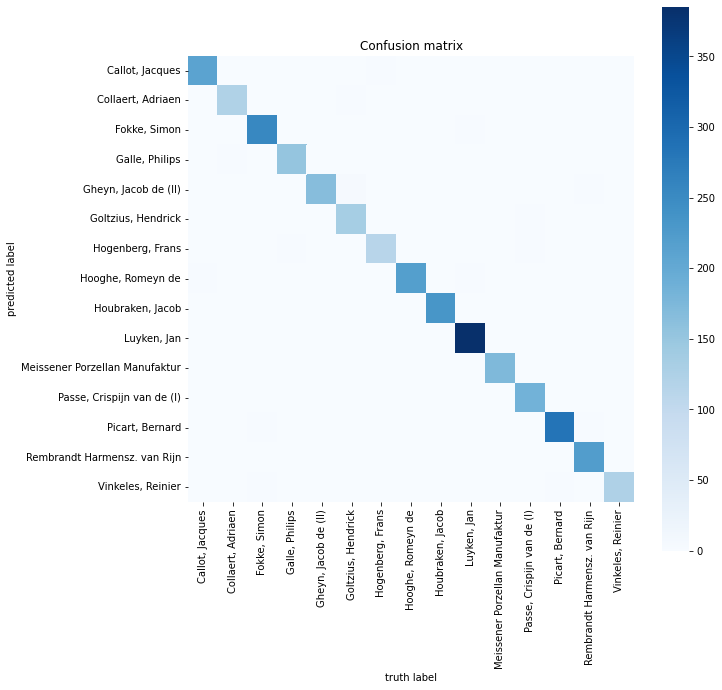

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
sns.heatmap(c_eval[5],square=True,fmt='d',cbar=True,xticklabels=encoder_c.classes_,yticklabels=encoder_c.classes_,cmap=plt.cm.Blues,ax=ax)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix')
plt.show()

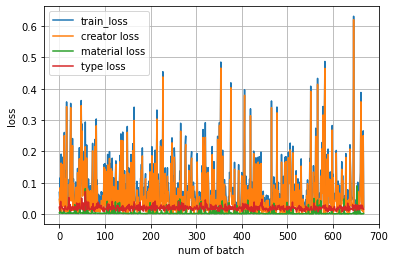

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_1,label='train_loss')
plt.plot(train_loss_each_2[0],label='creator loss')
plt.plot(train_loss_each_2[1],label='material loss')
plt.plot(train_loss_each_2[2],label='type loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(train_loss_each[1],label='material loss')
plt.xlabel('num of batch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
root_path = drive / "model" / "ResNet50_material_v2"
path=os.path.join(root_path / 'model_paramenter_ResNet50_MTL_v7.txt')
torch.save(model.state_dict(),path)

path2=os.path.join(root_path / 'optimizer_paramenter_ResNet50_MTL_v7.txt')
torch.save(optimizer.state_dict(),path2)

In [ ]:
with open(drive / "model" / "ResNet50_material_v2" / "loss_4.pickle", 'wb') as pickle_file:
  pickle.dump((train_loss,train_loss_1),pickle_file)
pickle_file.close()

with open(drive / "model" / "ResNet50_material_v2" / "loss_each_4.pickle", 'wb') as pickle_file:
  pickle.dump((train_loss_each,train_loss_each_2),pickle_file)
pickle_file.close()